In [1]:
import os
import PIL
import cv2
import uuid
import shutil
import random
import glob as gb
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from tqdm import tqdm  # Progress bar
from scipy.special import gamma

from keras.optimizers import *
from keras.regularizers import l1_l2
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input
from keras.layers import GlobalAveragePooling2D
from keras.callbacks import LearningRateScheduler
from keras.layers import Conv2D, MaxPool2D, BatchNormalization

from tensorflow.keras.metrics import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-02-02 11:30:04.239723: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738485004.251672  355463 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738485004.255278  355463 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-02 11:30:04.269591: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [54]:
import tensorflow as tf

# Check if TensorFlow can detect a GPU
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print(f"GPU is available: {gpu_devices}")
else:
    print("GPU is not available")

GPU is available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [55]:
calc_train = pd.read_csv('/home/maruf/Documents/imagedata/CBIS_DDSM/csv/calc_case_description_train_set.csv')
calc_test = pd.read_csv('/home/maruf/Documents/imagedata/CBIS_DDSM/csv/calc_case_description_test_set.csv')
mass_train = pd.read_csv('/home/maruf/Documents/imagedata/CBIS_DDSM/csv/mass_case_description_train_set.csv')
mass_test = pd.read_csv('/home/maruf/Documents/imagedata/CBIS_DDSM/csv/mass_case_description_test_set.csv')
dicom_df = pd.read_csv('/home/maruf/Documents/imagedata/CBIS_DDSM/csv/dicom_info.csv')

In [56]:
def replace_path(sample, old_path, new_path):
    return sample.replace(old_path, new_path, regex=True)

In [57]:
def plot_smaples(sample, row=15, col=15):
    plt.figure(figsize=(row, col))
    for i, file in enumerate(sample[0:5]):
        cropped_images_show = PIL.Image.open(file)
        gray_img= cropped_images_show.convert("L")
        plt.subplot(1,5,i+1)
        plt.imshow(gray_img, cmap='gray')
        plt.axis('off')
    plt.show()

In [58]:
cropped_images = dicom_df[dicom_df.SeriesDescription=="cropped images"].image_path
full_mammogram = dicom_df[dicom_df.SeriesDescription=="full mammogram images"].image_path
roi_mask = dicom_df[dicom_df.SeriesDescription=="ROI mask images"].image_path

In [59]:
# Replace the path for cropped_images to the correct directory.
correct_dir = "/home/maruf/Documents/imagedata/CBIS_DDSM/jpeg"
cropped_images = replace_path(cropped_images, "CBIS-DDSM/jpeg", correct_dir)
print('Cropped Images paths:')
print(cropped_images.iloc[0]) # Print to ensure everything looks correct.

Cropped Images paths:
/home/maruf/Documents/imagedata/CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg


In [60]:
# Replace the path for full_mammogram images to the correct directory.
correct_dir = "/home/maruf/Documents/imagedata/CBIS_DDSM/jpeg"
full_mammogram = replace_path(full_mammogram, "CBIS-DDSM/jpeg", correct_dir)
print('\nFull mammo Images paths:')
print(full_mammogram.iloc[0]) # Print to ensure everything looks correct.


Full mammo Images paths:
/home/maruf/Documents/imagedata/CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg


In [61]:
# Replace the path for roi_mask images to the correct directory.
correct_dir = "/home/maruf/Documents/imagedata/CBIS_DDSM/jpeg"
roi_mask = replace_path(roi_mask, "CBIS-DDSM/jpeg", correct_dir)
print('\nROI Mask Images paths:')
print(roi_mask.iloc[0]) # Print to ensure everything looks correct.


ROI Mask Images paths:
/home/maruf/Documents/imagedata/CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/2-270.jpg


Here we are creating a "get_image_file_name" function to find the length of each dataset, and ensure this matches and all pictures are implemented as expected.

In [62]:
def get_image_file_name(data, new_dict):

    for dicom in data:
        key = dicom.split('/')[7]
        new_dict[key] = dicom
    print(f"the length of dataset ==> {len(new_dict.keys())}")

In [63]:
cropped_images_dict = dict()
full_mammo_dict = dict()
roi_img_dict = dict()

get_image_file_name(cropped_images, cropped_images_dict)
get_image_file_name(full_mammogram, full_mammo_dict)
get_image_file_name(roi_mask, roi_img_dict)

the length of dataset ==> 3567
the length of dataset ==> 2857
the length of dataset ==> 3247


In [64]:
def fix_image_path(data):
    """Correct dicom paths to correct image paths."""
    for indx, image in enumerate(data.values):

        img_name = image[11].split('/')[2]

        if img_name in full_mammo_dict:
            data.iloc[indx, 11] = full_mammo_dict[img_name]
        else:
            data.iloc[indx, 11] = None
        
        img_name = image[12].split('/')[2]
        if img_name in cropped_images_dict:
            data.iloc[indx, 12] = cropped_images_dict[img_name]
        else:
            data.iloc[indx, 11] = None

        img_name = image[13].split('/')[2]
        if img_name in roi_img_dict:
            data.iloc[indx, 13] = roi_img_dict[img_name]

        else:
            data.iloc[indx, 13] = None

In [65]:
fix_image_path(mass_train)

In [66]:
mass_train = mass_train.rename(columns={'left or right breast': 'left_or_right_breast',
                                        'image view': 'image_view',
                                        'abnormality id': 'abnormality_id',
                                        'abnormality type': 'abnormality_type',
                                        'mass shape': 'mass_shape',
                                        'mass margins': 'mass_margins',
                                        'image file path': 'image_file_path',
                                        'cropped image file path': 'cropped_image_file_path',
                                        'ROI mask file path': 'ROI_mask_file_path'})
mass_train.head(5)

patient_id  breast_density left_or_right_breast image_view  abnormality_id  \
0    P_00001               3                 LEFT         CC               1   
1    P_00001               3                 LEFT        MLO               1   
2    P_00004               3                 LEFT         CC               1   
3    P_00004               3                 LEFT        MLO               1   
4    P_00004               3                RIGHT        MLO               1   

  abnormality_type                          mass_shape   mass_margins  \
0             mass  IRREGULAR-ARCHITECTURAL_DISTORTION     SPICULATED   
1             mass  IRREGULAR-ARCHITECTURAL_DISTORTION     SPICULATED   
2             mass            ARCHITECTURAL_DISTORTION    ILL_DEFINED   
3             mass            ARCHITECTURAL_DISTORTION    ILL_DEFINED   
4             mass                                OVAL  CIRCUMSCRIBED   

   assessment  pathology  subtlety  \
0           4  MALIGNANT         4   
1           4  MALIGNANT         4   
2           4     BENIGN         3   
3           4     BENIGN         3   
4           4     BENIGN         5   

                                     image_file_path  \
0  /home/maruf/Documents/imagedata/CBIS_DDSM/jpeg...   
1  /home/maruf/Documents/imagedata/CBIS_DDSM/jpeg...   
2  /home/maruf/Documents/imagedata/CBIS_DDSM/jpeg...   
3  /home/maruf/Documents/imagedata/CBIS_DDSM/jpeg...   
4  /home/maruf/Documents/imagedata/CBIS_DDSM/jpeg...   

                             cropped_image_file_path  \
0  /home/maruf/Documents/imagedata/CBIS_DDSM/jpeg...   
1  /home/maruf/Documents/imagedata/CBIS_DDSM/jpeg...   
2  /home/maruf/Documents/imagedata/CBIS_DDSM/jpeg...   
3  /home/maruf/Documents/imagedata/CBIS_DDSM/jpeg...   
4  /home/maruf/Documents/imagedata/CBIS_DDSM/jpeg...   

                                  ROI_mask_file_path  
0  /home/maruf/Documents/imagedata/CBIS_DDSM/jpeg...  
1  /home/maruf/Documents/imagedata/CBIS_DDSM/jpeg...  
2  /home/maruf/Documents/imagedata/CBIS_DDSM/jpeg...  
3  /home/maruf/Documents/imagedata/CBIS_DDSM/jpeg...  
4  /home/maruf/Documents/imagedata/CBIS_DDSM/jpeg...

In [67]:
mass_train.pathology.unique()

array(['MALIGNANT', 'BENIGN', 'BENIGN_WITHOUT_CALLBACK'], dtype=object)

In [68]:
fix_image_path(mass_test)

In [69]:
mass_test = mass_test.rename(columns={'left or right breast': 'left_or_right_breast',
                                      'image view': 'image_view',
                                      'abnormality id': 'abnormality_id',
                                      'abnormality type': 'abnormality_type',
                                      'mass shape': 'mass_shape',
                                      'mass margins': 'mass_margins',
                                      'image file path': 'image_file_path',
                                      'cropped image file path': 'cropped_image_file_path',
                                      'ROI mask file path': 'ROI_mask_file_path'})
# view renamed columns
mass_test.head()

patient_id  breast_density left_or_right_breast image_view  abnormality_id  \
0    P_00016               4                 LEFT         CC               1   
1    P_00016               4                 LEFT        MLO               1   
2    P_00017               2                 LEFT         CC               1   
3    P_00017               2                 LEFT        MLO               1   
4    P_00032               3                RIGHT         CC               1   

  abnormality_type mass_shape   mass_margins  assessment  pathology  subtlety  \
0             mass  IRREGULAR     SPICULATED           5  MALIGNANT         5   
1             mass  IRREGULAR     SPICULATED           5  MALIGNANT         5   
2             mass      ROUND  CIRCUMSCRIBED           4  MALIGNANT         4   
3             mass      ROUND    ILL_DEFINED           4  MALIGNANT         4   
4             mass      ROUND       OBSCURED           0     BENIGN         2   

                                     image_file_path  \
0  /home/maruf/Documents/imagedata/CBIS_DDSM/jpeg...   
1  /home/maruf/Documents/imagedata/CBIS_DDSM/jpeg...   
2  /home/maruf/Documents/imagedata/CBIS_DDSM/jpeg...   
3  /home/maruf/Documents/imagedata/CBIS_DDSM/jpeg...   
4  /home/maruf/Documents/imagedata/CBIS_DDSM/jpeg...   

                             cropped_image_file_path  \
0  /home/maruf/Documents/imagedata/CBIS_DDSM/jpeg...   
1  /home/maruf/Documents/imagedata/CBIS_DDSM/jpeg...   
2  /home/maruf/Documents/imagedata/CBIS_DDSM/jpeg...   
3  /home/maruf/Documents/imagedata/CBIS_DDSM/jpeg...   
4  /home/maruf/Documents/imagedata/CBIS_DDSM/jpeg...   

                                  ROI_mask_file_path  
0  /home/maruf/Documents/imagedata/CBIS_DDSM/jpeg...  
1  /home/maruf/Documents/imagedata/CBIS_DDSM/jpeg...  
2  /home/maruf/Documents/imagedata/CBIS_DDSM/jpeg...  
3  /home/maruf/Documents/imagedata/CBIS_DDSM/jpeg...  
4  /home/maruf/Documents/imagedata/CBIS_DDSM/jpeg...

In [70]:
fix_image_path(calc_train)

In [71]:
calc_train = calc_train.rename(columns={'left or right breast': 'left_or_right_breast',
                                        'image view': 'image_view',
                                        'abnormality id': 'abnormality_id',
                                        'abnormality type': 'abnormality_type',
                                        'mass shape': 'mass_shape',
                                        'mass margins': 'mass_margins',
                                        'image file path': 'image_file_path',
                                        'cropped image file path': 'cropped_image_file_path',
                                        'ROI mask file path': 'ROI_mask_file_path'})
# view renamed columns
calc_train.head()

patient_id  breast density left_or_right_breast image_view  abnormality_id  \
0    P_00005               3                RIGHT         CC               1   
1    P_00005               3                RIGHT        MLO               1   
2    P_00007               4                 LEFT         CC               1   
3    P_00007               4                 LEFT        MLO               1   
4    P_00008               1                 LEFT         CC               1   

  abnormality_type    calc type calc distribution  assessment  \
0    calcification    AMORPHOUS         CLUSTERED           3   
1    calcification    AMORPHOUS         CLUSTERED           3   
2    calcification  PLEOMORPHIC            LINEAR           4   
3    calcification  PLEOMORPHIC            LINEAR           4   
4    calcification          NaN          REGIONAL           2   

                 pathology  subtlety  \
0                MALIGNANT         3   
1                MALIGNANT         3   
2                   BENIGN         4   
3                   BENIGN         4   
4  BENIGN_WITHOUT_CALLBACK         3   

                                     image_file_path  \
0  /home/maruf/Documents/imagedata/CBIS_DDSM/jpeg...   
1  /home/maruf/Documents/imagedata/CBIS_DDSM/jpeg...   
2  /home/maruf/Documents/imagedata/CBIS_DDSM/jpeg...   
3  /home/maruf/Documents/imagedata/CBIS_DDSM/jpeg...   
4  /home/maruf/Documents/imagedata/CBIS_DDSM/jpeg...   

                             cropped_image_file_path  \
0  /home/maruf/Documents/imagedata/CBIS_DDSM/jpeg...   
1  /home/maruf/Documents/imagedata/CBIS_DDSM/jpeg...   
2  /home/maruf/Documents/imagedata/CBIS_DDSM/jpeg...   
3  /home/maruf/Documents/imagedata/CBIS_DDSM/jpeg...   
4  /home/maruf/Documents/imagedata/CBIS_DDSM/jpeg...   

                                  ROI_mask_file_path  
0  /home/maruf/Documents/imagedata/CBIS_DDSM/jpeg...  
1  /home/maruf/Documents/imagedata/CBIS_DDSM/jpeg...  
2  /home/maruf/Documents/imagedata/CBIS_DDSM/jpeg...  
3  /home/maruf/Documents/imagedata/CBIS_DDSM/jpeg...  
4  /home/maruf/Documents/imagedata/CBIS_DDSM/jpeg...

In [72]:
fix_image_path(calc_test)

In [73]:
calc_test = calc_test.rename(columns={'left or right breast': 'left_or_right_breast',
                                      'image view': 'image_view',
                                      'abnormality id': 'abnormality_id',
                                      'abnormality type': 'abnormality_type',
                                      'mass shape': 'mass_shape',
                                      'mass margins': 'mass_margins',
                                      'image file path': 'image_file_path',
                                      'cropped image file path': 'cropped_image_file_path',
                                      'ROI mask file path': 'ROI_mask_file_path'})
# view renamed columns
calc_test.head()

patient_id  breast density left_or_right_breast image_view  abnormality_id  \
0    P_00038               2                 LEFT         CC               1   
1    P_00038               2                 LEFT        MLO               1   
2    P_00038               2                RIGHT         CC               1   
3    P_00038               2                RIGHT         CC               2   
4    P_00038               2                RIGHT        MLO               1   

  abnormality_type             calc type calc distribution  assessment  \
0    calcification  PUNCTATE-PLEOMORPHIC         CLUSTERED           4   
1    calcification  PUNCTATE-PLEOMORPHIC         CLUSTERED           4   
2    calcification              VASCULAR               NaN           2   
3    calcification              VASCULAR               NaN           2   
4    calcification              VASCULAR               NaN           2   

                 pathology  subtlety image_file_path  \
0                   BENIGN         2            None   
1                   BENIGN         2            None   
2  BENIGN_WITHOUT_CALLBACK         5            None   
3  BENIGN_WITHOUT_CALLBACK         5            None   
4  BENIGN_WITHOUT_CALLBACK         5            None   

                             cropped_image_file_path ROI_mask_file_path  
0  /home/maruf/Documents/imagedata/CBIS_DDSM/jpeg...               None  
1  /home/maruf/Documents/imagedata/CBIS_DDSM/jpeg...               None  
2  /home/maruf/Documents/imagedata/CBIS_DDSM/jpeg...               None  
3  /home/maruf/Documents/imagedata/CBIS_DDSM/jpeg...               None  
4  /home/maruf/Documents/imagedata/CBIS_DDSM/jpeg...               None

In [74]:
def display_images(dataset, column, number):
    """Displays images in dataset, handling missing files and converting formats."""
    
    # create figure and axes
    fig, axes = plt.subplots(1, number, figsize=(15, 5))
    
    # Loop through rows and display images
    for index, (i, row) in enumerate(dataset.head(number).iterrows()):
        image_path = row[column]
        
       # Check if image_path is valid (not None) and exists
        if image_path is None or not os.path.exists(image_path):
            # print(f"File not found or invalid path: {image_path}")
            continue
        
        image = cv2.imread(image_path)
        
        # Handle case when image can't be read
        if image is None:
            # print(f"Error reading image: {image_path}")
            continue
        
        # Convert BGR to RGB if needed (for correct color display)
        if len(image.shape) == 3 and image.shape[2] == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        ax = axes[index]
        ax.imshow(image, cmap='gray' if len(image.shape) == 2 else None)
        ax.set_title(f"{row['pathology']}")
        ax.axis('off')
        print(np.array(image).shape)
    
    plt.tight_layout()
    plt.show()

Full Mammograms:

(4808, 3024, 3)
(4800, 2656, 3)
(5491, 2986, 3)
(5491, 3046, 3)
(5491, 2911, 3)


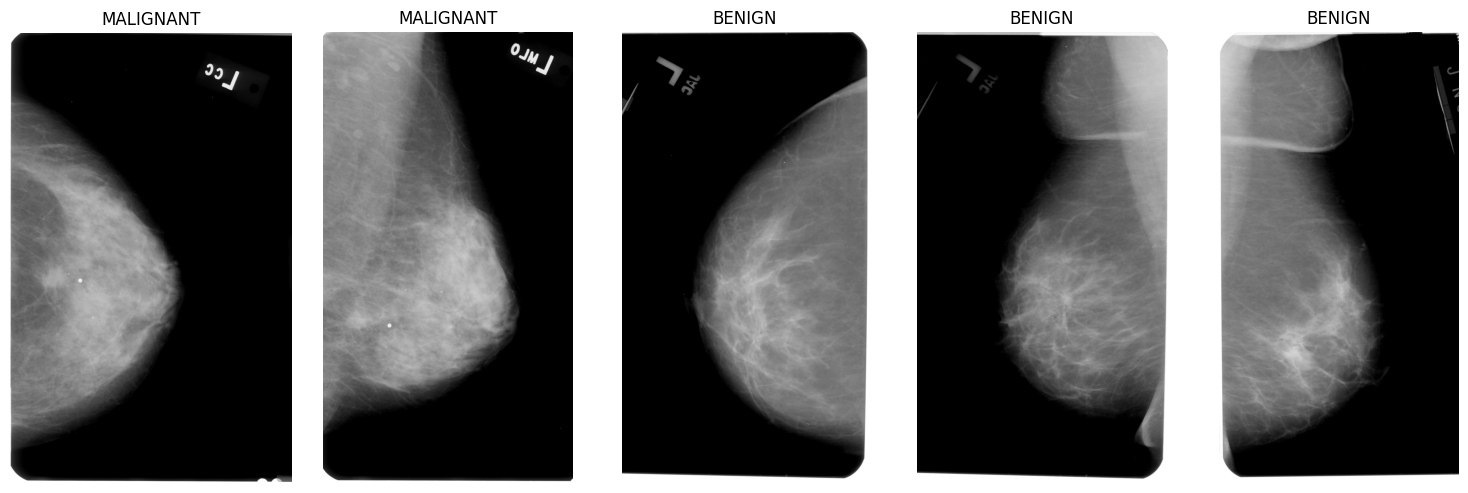

Cropped Mammograms:

(515, 431, 3)
(292, 256, 3)
(466, 423, 3)
(427, 422, 3)
(399, 465, 3)


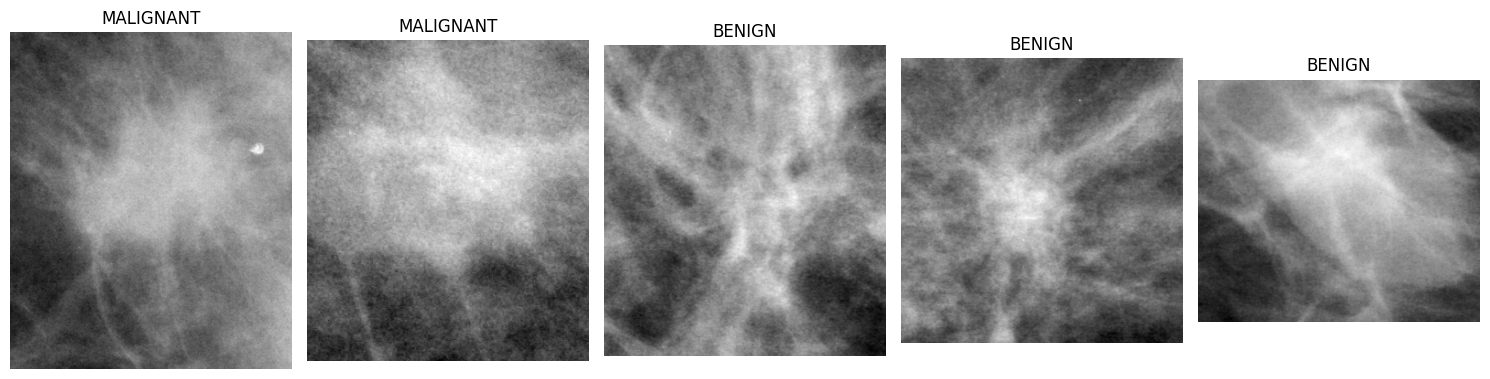

ROI_mask:

(4808, 3024, 3)
(4800, 2656, 3)
(5491, 2986, 3)
(5491, 3046, 3)
(5491, 2911, 3)


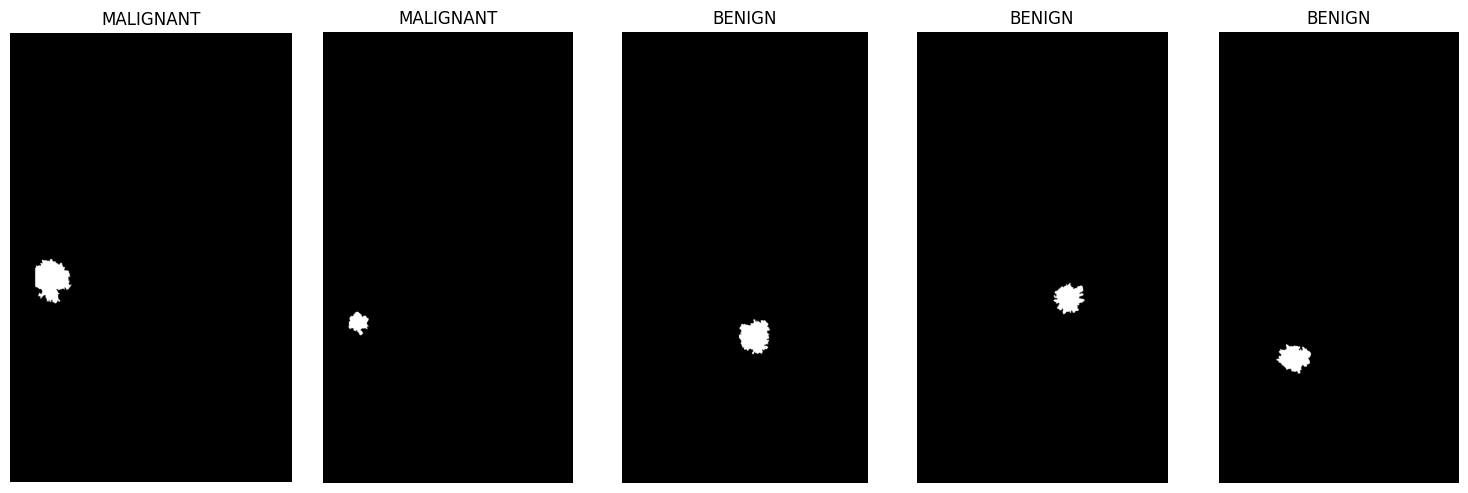

In [75]:
print('Full Mammograms:\n')
display_images(mass_train, 'image_file_path', 5)
print('Cropped Mammograms:\n')
display_images(mass_train, 'cropped_image_file_path', 5)
print('ROI_mask:\n')
display_images(mass_train, 'ROI_mask_file_path', 5)

Full Mammograms:

(4006, 1846, 3)
(5491, 2011, 3)
(5904, 3200, 3)
(5952, 3352, 3)
(5116, 2641, 3)


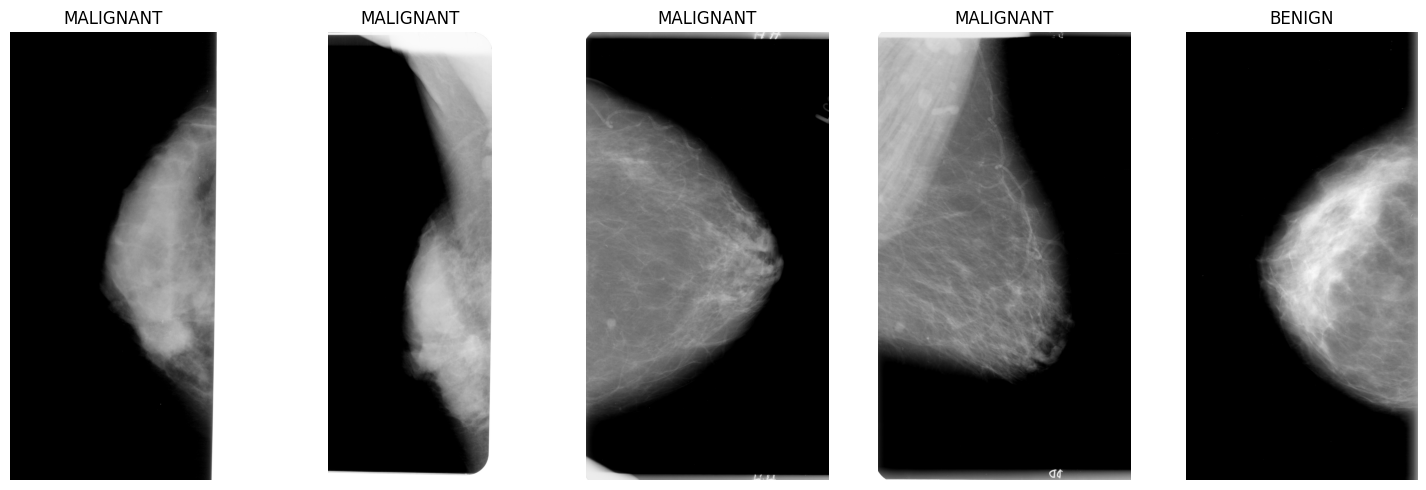

Cropped Mammograms:

(384, 385, 3)
(369, 328, 3)
(214, 195, 3)
(220, 225, 3)
(405, 376, 3)


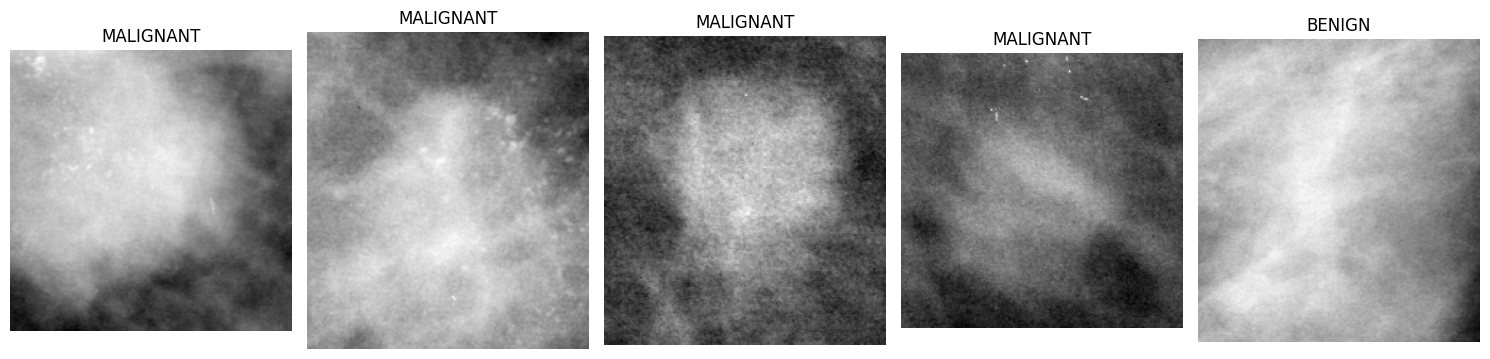

ROI_mask:

(4006, 1846, 3)
(5491, 2011, 3)
(5904, 3200, 3)
(5952, 3352, 3)
(5116, 2641, 3)


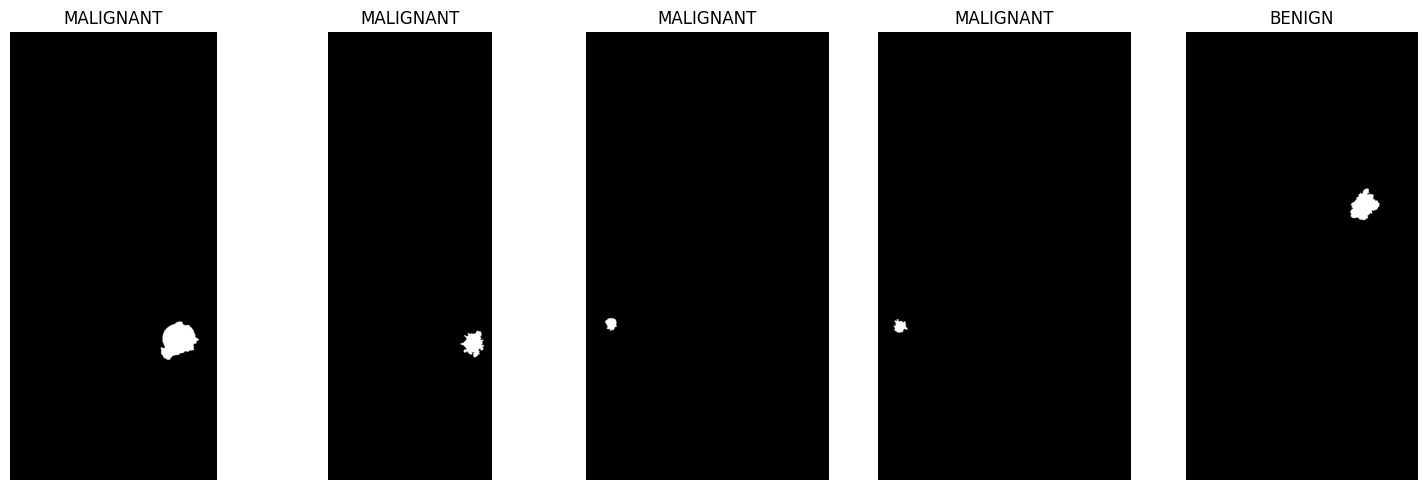

In [76]:
print('Full Mammograms:\n')
display_images(mass_test, 'image_file_path', 5)
print('Cropped Mammograms:\n')
display_images(mass_test, 'cropped_image_file_path', 5)
print('ROI_mask:\n')
display_images(mass_test, 'ROI_mask_file_path', 5)

Full Mammograms:

(5056, 2761, 3)
(5386, 2836, 3)
(5356, 2986, 3)
(5491, 3166, 3)
(4568, 3064, 3)


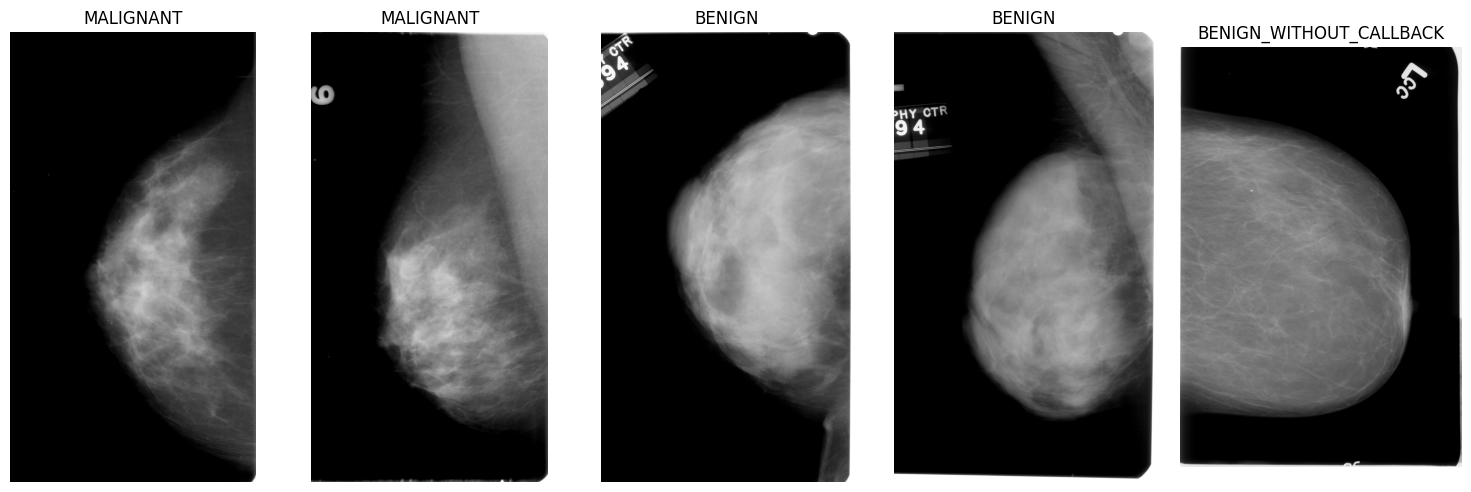

Cropped Mammograms:

(589, 677, 3)
(549, 681, 3)
(681, 577, 3)
(689, 761, 3)
(161, 177, 3)


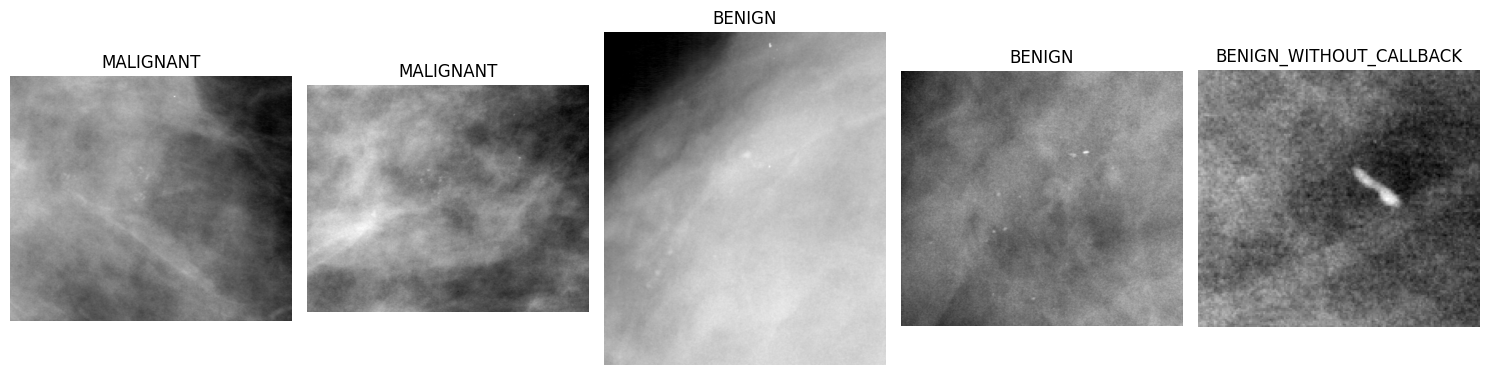

ROI_mask:

(5056, 2761, 3)
(5386, 2836, 3)
(5356, 2986, 3)
(5491, 3166, 3)
(4568, 3064, 3)


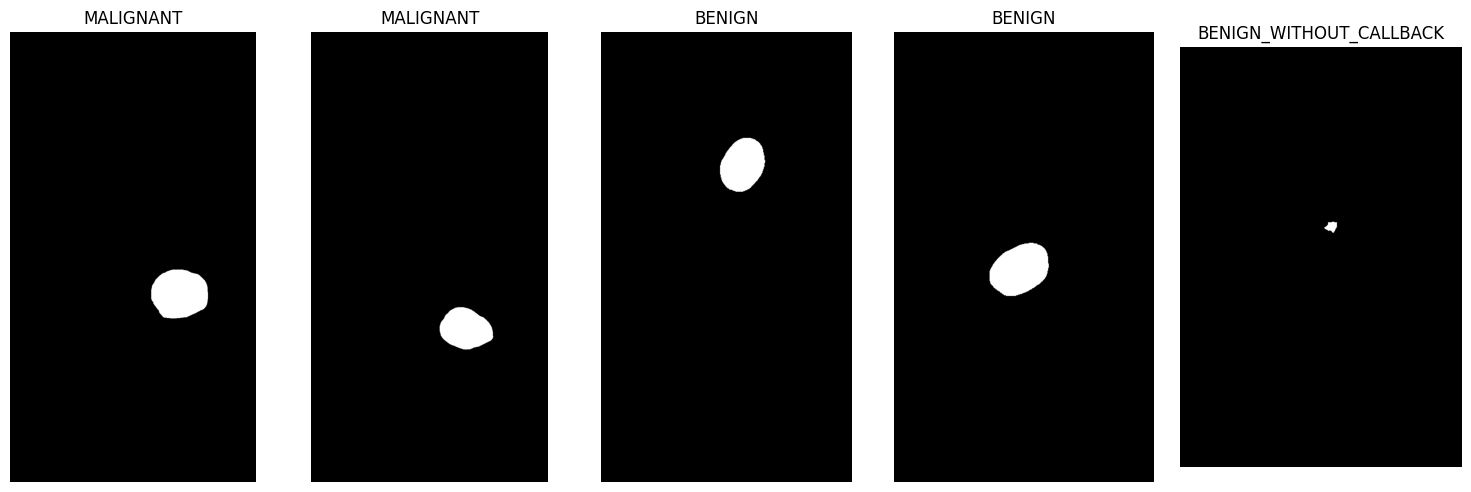

In [77]:
print('Full Mammograms:\n')
display_images(calc_train, 'image_file_path', 5)
print('Cropped Mammograms:\n')
display_images(calc_train, 'cropped_image_file_path', 5)
print('ROI_mask:\n')
display_images(calc_train, 'ROI_mask_file_path', 5)

Full Mammograms:



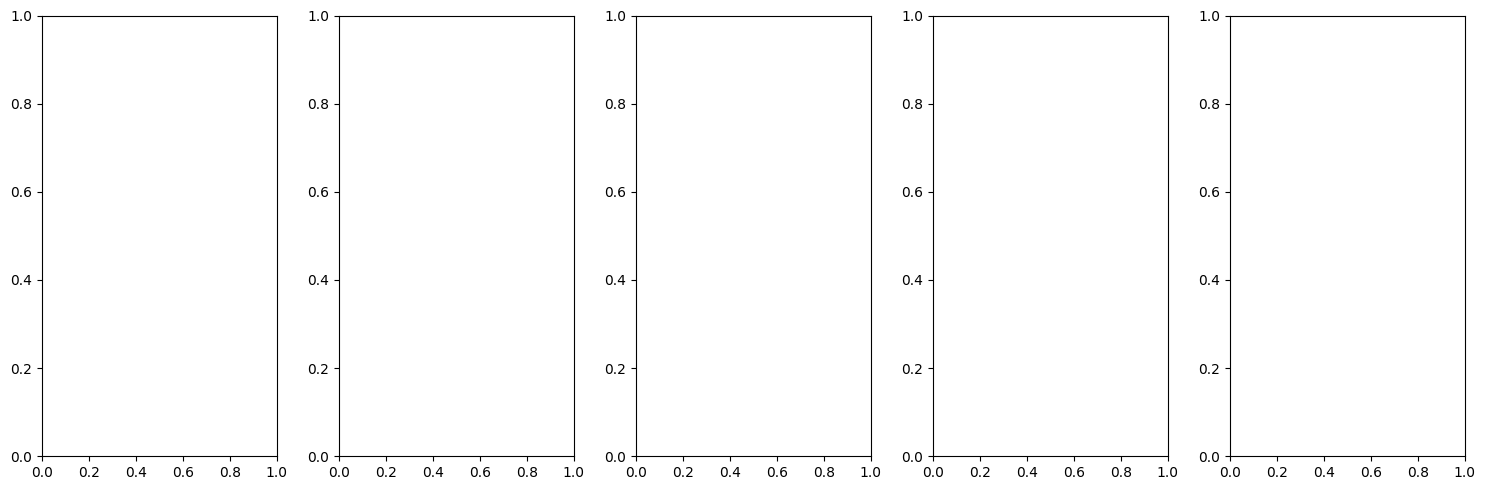

Cropped Mammograms:

(249, 265, 3)
(265, 249, 3)
(409, 660, 3)
(257, 724, 3)
(809, 833, 3)


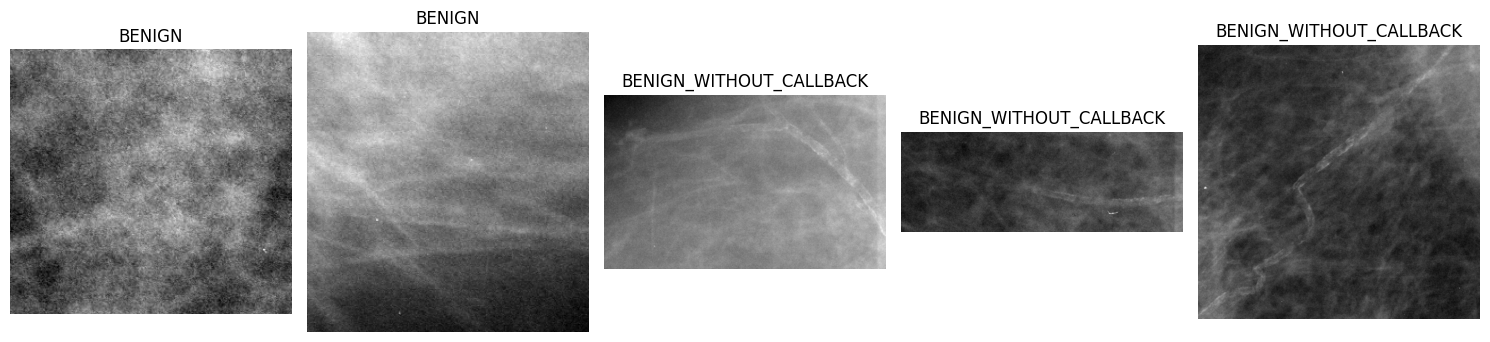

ROI_mask:



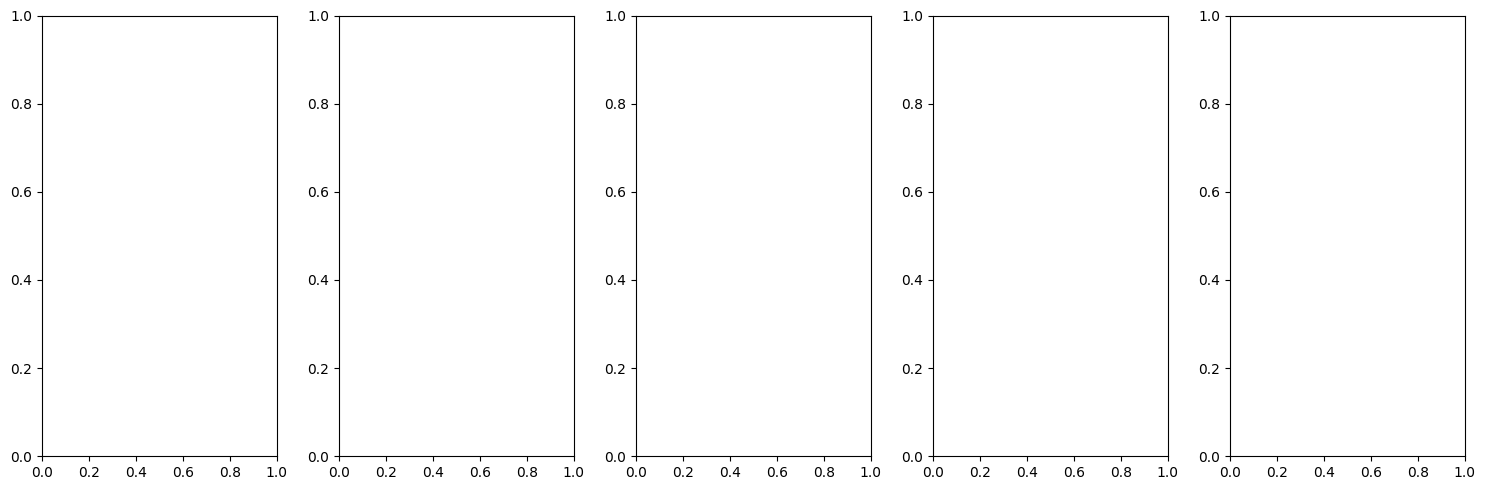

In [78]:
print('Full Mammograms:\n')
display_images(calc_test, 'image_file_path', 5)
print('Cropped Mammograms:\n')
display_images(calc_test, 'cropped_image_file_path', 5)
print('ROI_mask:\n')
display_images(calc_test, 'ROI_mask_file_path', 5)

Combining the datasets into one.

In [79]:
full_dataset_new = pd.concat([mass_train, mass_test, calc_train, calc_test], axis=0)
# try next time

full_dataset = pd.concat([calc_train, calc_test], axis=0)

In [80]:
len(full_dataset_new)

3568

In [81]:
class_mapper = {'MALIGNANT': 1, 'BENIGN': 0, 'BENIGN_WITHOUT_CALLBACK': 0} 

In [82]:
target_size = (224, 224, 3)

# Apply class mapper to pathology column
full_dataset_new['labels'] = full_dataset_new['pathology'].replace(class_mapper).infer_objects(copy=False)

full_images = np.array(full_dataset_new[full_dataset_new["image_file_path"].notna()]["image_file_path"].tolist())
full_labels = np.array(full_dataset_new[full_dataset_new["image_file_path"].notna()]["labels"].tolist())

/tmp/ipykernel_555959/2898076943.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  full_dataset_new['labels'] = full_dataset_new['pathology'].replace(class_mapper).infer_objects(copy=False)


In [83]:
len(full_images)

3284

In [84]:
# If full_labels is a NumPy array, convert it to a Pandas series
full_labels_series = pd.Series(full_labels)

# Count the occurrences of each class
label_counts = full_labels_series.value_counts()

# Assuming 0 = benign and 1 = malignant
benign_count = label_counts.get(0, 0)
malignant_count = label_counts.get(1, 0)

print(f"Benign images: {benign_count}")
print(f"Malignant images: {malignant_count}")

Benign images: 1930
Malignant images: 1354


In [85]:
num_classes = len(full_dataset_new['labels'].unique())
num_classes

2

In [86]:
class_names = ['Benign', 'Malignant']

In [87]:
# Check the distribution of labels
label_counts = full_dataset_new['labels'].value_counts()
print(label_counts)

labels
0    2111
1    1457
Name: count, dtype: int64


In [88]:
# Define a function for data augmentation
def augment_image(image):
    # Apply data augmentation using tf.image functions
    image = tf.image.random_flip_left_right(image)
#     image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    return image

# Function to resize image to (224, 224, 3)
def resize_image(image_tensor):
    return tf.image.resize(image_tensor, [224, 224])

# Function to balance classes by augmenting images
def copy_images_with_unique_filenames(images, labels, source, destination, target_count=None):
    """
    Copy images from source to destination in subfolders '0' and '1',
    ensuring unique filenames and applying data augmentation and balancing.
    """
    benign_images = 0
    malignant_images = 0
    skipped_images = []

    # Create the destination subfolders '0' and '1'
    category_dest_dir_zero = os.path.join(destination, '0')
    os.makedirs(category_dest_dir_zero, exist_ok=True)

    category_dest_dir_one = os.path.join(destination, '1')
    os.makedirs(category_dest_dir_one, exist_ok=True)

    benign_images_list = []
    malignant_images_list = []

    for i, (image, label) in enumerate(zip(images, labels)):
#         img_name = data_frame.REFNUM[i]
#         abs_path = os.path.join(source, img_name + '.pgm')

        if os.path.exists(image):
            try:
                # Generate a unique filename
                filename = os.path.basename(image)
                unique_filename = f"{uuid.uuid4().hex}_{filename}"
        
                # Open the image using PIL
                with Image.open(image) as img:
                    # Convert the image to RGB mode (for saving as JPEG)
                    img = img.convert('RGB')
                    # Augment the image (convert it to a Tensor first)
                    img_tensor = tf.convert_to_tensor(img)
                    # Resize the image to (224, 224, 3)
                    resized_img_tensor = resize_image(img_tensor)
                    augmented_image_tensor = augment_image(resized_img_tensor)
                    # Convert Tensor back to PIL image for saving
                    augmented_image = tf.keras.preprocessing.image.array_to_img(augmented_image_tensor)

                    if label == 0:
                        benign_images_list.append(unique_filename)
                        dest_path = os.path.join(category_dest_dir_zero, unique_filename)
#                         augmented_image.save(dest_path, 'JPEG')
                        augmented_image.save(dest_path, 'JPEG')
                        benign_images += 1

                    elif label == 1:
                        malignant_images_list.append(unique_filename)
                        dest_path = os.path.join(category_dest_dir_one, unique_filename)
#                         augmented_image.save(dest_path, 'JPEG')
                        augmented_image.save(dest_path, 'JPEG')
                        malignant_images += 1
                        
#                 del img, img_tensor, resized_img_tensor, augmented_image_tensor, augmented_image
#                 gc.collect()
            except Exception as e:
                print(f"Error copying image {image}: {e}")
                skipped_images.append(image)
        else:
            print(f"Image not found: {image}")
            skipped_images.append(image)

    # If balancing is needed, duplicate/augment images from the smaller class
    benign_count = len(benign_images_list)
    malignant_count = len(malignant_images_list)

    if benign_count < malignant_count:
#         augment_and_save_images(benign_images_list, category_dest_dir_zero, target_count - benign_count)
        augment_and_save_images(benign_images_list, category_dest_dir_zero, malignant_count - benign_count)

    elif malignant_count < benign_count:
        augment_and_save_images(malignant_images_list, category_dest_dir_one, benign_count - malignant_count)

    augment_and_save_images(benign_images_list, category_dest_dir_zero, target_count)
    augment_and_save_images(malignant_images_list, category_dest_dir_one, target_count)

    print(f"\nCopying complete.")
    print(f"Benign images copied (label 0): {benign_images}")
    print(f"Benign count (label 0): {benign_count}")
    print(f"Malignant images copied (label 1): {malignant_images}")
    print(f"Malignant count (label 1): {malignant_count}")
    print(f"Total skipped images: {len(skipped_images)}")
    if skipped_images:
        print("Skipped images:")
        for img in skipped_images:
            print(img)
            

# Function to augment and save images to balance the dataset
def augment_and_save_images(images_list, destination_dir, num_augments):
    """
    Augment and save images to balance the dataset.
    """
    for i in range(num_augments):
        img_name = random.choice(images_list)
        abs_path = os.path.join(destination_dir, img_name)

        try:
            with Image.open(abs_path) as img:
                img = img.convert('RGB')
                # Augment the image
                img_tensor = tf.convert_to_tensor(img)
                # Resize the image
#                 resized_img_tensor = resize_image(img_tensor)
                augmented_image_tensor = augment_image(img_tensor)
                # Convert Tensor back to PIL image for saving
                augmented_image = tf.keras.preprocessing.image.array_to_img(augmented_image_tensor)
                # Remove the original extension from img_name 1-285.jpg --> 1-285
                img_name_without_ext = os.path.splitext(img_name)[0]
                # Save augmented image with a unique name
                augmented_image.save(os.path.join(destination_dir, img_name_without_ext + f'_aug{i}.jpg'), 'JPEG')
            
        except Exception as e:
            print(f"Error augmenting image {abs_path}: {e}")

source_dir = "/home/maruf/Documents/imagedata/CBIS_DDSM/jpeg"
destination_dir = "/home/maruf/Documents/imagedata/CBIS_DDSM/merged_images_new"

# target_count=0 meaning no Augmentation, There's just Data-Balance
target_count = (len(full_labels) * 3) - len(full_labels)
copy_images_with_unique_filenames(full_images, full_labels, source_dir, destination_dir, target_count)


Copying complete.
Benign images copied (label 0): 1930
Benign count (label 0): 1930
Malignant images copied (label 1): 1354
Malignant count (label 1): 1354
Total skipped images: 0


In [2]:
# Check the number of images in each class folder after merging
zero_class_count = len(os.listdir("/home/maruf/Documents/imagedata/CBIS_DDSM/merged_images/0"))
one_class_count  = len(os.listdir("/home/maruf/Documents/imagedata/CBIS_DDSM/merged_images/1"))

zero_class_count_new = len(os.listdir("/home/maruf/Documents/imagedata/CBIS_DDSM/merged_images_new/0"))
one_class_count_new  = len(os.listdir("/home/maruf/Documents/imagedata/CBIS_DDSM/merged_images_new/1"))

print(f"Number of images in class 0: {zero_class_count}")
print(f"Number of images in class 1: {one_class_count}")

print(f"Number of images in class 0: {zero_class_count_new}")
print(f"Number of images in class 1: {one_class_count_new}")

Number of images in class 0: 12582
Number of images in class 1: 12578
Number of images in class 0: 8498
Number of images in class 1: 8498


In [2]:
import tensorflow as tf

data_dir = '/home/maruf/Documents/imagedata/CBIS_DDSM/merged_images_new/'  # Update with the dataset path

# Create a dataset for the entire data to use for split
full_dataset_new = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    # image_size=(224, 224),
    image_size=(224, 224),
    seed=50,
    shuffle=True,
    batch_size=16
)
# Calculate the total number of samples
total_sample_new = tf.data.experimental.cardinality(full_dataset_new).numpy()


train_size = int(0.8 * total_sample_new)                 # 70% for training
val_size   = int(0.15 * total_sample_new)                # 20% for validation
test_size = total_sample_new - train_size - val_size     # 10% for testing

# Create train, validation, and test datasets
train_dataset       = full_dataset_new.take(train_size)
validation_dataset  = full_dataset_new.skip(train_size).take(val_size)
test_dataset        = full_dataset_new.skip(train_size + val_size)

train_dataset      = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset       = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Print the number of samples in each dataset
print(f"Train samples:      {train_size}     batches(16/32) ==> {train_size*32}")
print(f"Validation samples: {val_size}       batches(16/13) ==> {val_size*32}")
print(f"Test samples:       {test_size}      batches(16/13) ==> {test_size*32}")


Found 16996 files belonging to 2 classes.


I0000 00:00:1738485015.090196  355463 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2161 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Train samples:      850     batches(16/32) ==> 27200
Validation samples: 159       batches(16/13) ==> 5088
Test samples:       54      batches(16/13) ==> 1728


1. ResNet50

In [4]:
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def try_model_ResNet50():
    # Load the ResNet50 base model
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze all layers initially
    for layer in base_model.layers:
        layer.trainable = False

    # Calculate the index to start unfreezing layers
    from_index = int(np.round((len(base_model.layers) - 1) * (1.0 - 70.0 / 100.0)))
    
    # Unfreeze layers from the calculated index onwards
    for layer in base_model.layers[from_index:]:
        layer.trainable = True

    # Add custom layers on top (Upper-Layers)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    predictions = Dense(2, activation='softmax')(x)  # Sigmoid for binary classification

    # Create the model
    ResNet50_model = Model(inputs=base_model.input, outputs=predictions)

    # Define callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
    checkpoint = ModelCheckpoint(
        'best_resnet50_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    return ResNet50_model, early_stopping, checkpoint


In [5]:
import tensorflow as tf
import gc
import pickle
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam



# Unpack the model and early_stopping
ResNet50_model, early_stopping, checkpoint= try_model_ResNet50()

# Compile the model
ResNet50_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

# Summary
# ResNet50_model.summary()

ResNet50_model_history_new = ResNet50_model.fit(
            train_dataset,
            validation_data=validation_dataset,
            batch_size=32,
            callbacks=[early_stopping, checkpoint],
            epochs=50
        )

ResNet50_model.save("resnet50_model_new.h5")


# Assume `model_history` is the variable storing the history returned by model.fit()
with open('ResNet50_model_history_new.pkl', 'wb') as file:
    pickle.dump(ResNet50_model_history_new.history, file)


Epoch 1/50


I0000 00:00:1737945759.180970  605593 service.cc:148] XLA service 0x7461c8002390 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737945759.181007  605593 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2025-01-27 05:42:39.664934: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737945761.585295  605593 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-27 05:42:43.568297: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12171_0', 112 bytes spill stores, 224 bytes spill loads

2025-01-27 05:42:43.706734: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_

425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.5072 - loss: 26.6814 - precision: 0.5072 - recall: 0.5072

2025-01-27 05:44:33.748824: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1768_0', 88 bytes spill stores, 120 bytes spill loads

2025-01-27 05:44:33.954728: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1768', 220 bytes spill stores, 220 bytes spill loads




Epoch 1: val_loss improved from inf to 25.04569, saving model to best_resnet50_model.keras
425/425 ━━━━━━━━━━━━━━━━━━━━ 138s 241ms/step - accuracy: 0.5073 - loss: 26.6802 - precision: 0.5073 - recall: 0.5073 - val_accuracy: 0.6527 - val_loss: 25.0457 - val_precision: 0.6527 - val_recall: 0.6527
Epoch 2/50
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.6083 - loss: 24.5400 - precision: 0.6083 - recall: 0.6083
Epoch 2: val_loss improved from 25.04569 to 22.91463, saving model to best_resnet50_model.keras
425/425 ━━━━━━━━━━━━━━━━━━━━ 97s 229ms/step - accuracy: 0.6084 - loss: 24.5387 - precision: 0.6084 - recall: 0.6084 - val_accuracy: 0.6962 - val_loss: 22.9146 - val_precision: 0.6962 - val_recall: 0.6962
Epoch 3/50
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.7001 - loss: 22.4122 - precision: 0.7001 - recall: 0.7001
Epoch 3: val_loss improved from 22.91463 to 20.81269, saving model to best_resnet50_model.keras
425/425 ━━━━━━━━━━━━━━━━━━━━ 97s 229ms/step - accuracy:

2025-01-27 05:59:15.231706: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554688 bytes after encountering the first element of size 33554688 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 10: val_loss improved from 10.25564 to 8.84823, saving model to best_resnet50_model.keras
425/425 ━━━━━━━━━━━━━━━━━━━━ 98s 230ms/step - accuracy: 0.9881 - loss: 9.6859 - precision: 0.9881 - recall: 0.9881 - val_accuracy: 0.9355 - val_loss: 8.8482 - val_precision: 0.9355 - val_recall: 0.9355
Epoch 11/50
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.9906 - loss: 8.2908 - precision: 0.9906 - recall: 0.9906
Epoch 11: val_loss improved from 8.84823 to 7.60113, saving model to best_resnet50_model.keras
425/425 ━━━━━━━━━━━━━━━━━━━━ 98s 229ms/step - accuracy: 0.9906 - loss: 8.2901 - precision: 0.9906 - recall: 0.9906 - val_accuracy: 0.9264 - val_loss: 7.6011 - val_precision: 0.9264 - val_recall: 0.9264
Epoch 12/50
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.9917 - loss: 7.0395 - precision: 0.9917 - recall: 0.9917
Epoch 12: val_loss improved from 7.60113 to 6.40608, saving model to best_resnet50_model.keras
425/425 ━━━━━━━━━━━━━━━━━━━━ 98s 230ms/step - accuracy: 0

2025-01-27 06:41:36.483231: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554688 bytes after encountering the first element of size 33554688 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 36: val_loss improved from 0.33023 to 0.31061, saving model to best_resnet50_model.keras
425/425 ━━━━━━━━━━━━━━━━━━━━ 99s 232ms/step - accuracy: 0.9968 - loss: 0.1672 - precision: 0.9968 - recall: 0.9968 - val_accuracy: 0.9545 - val_loss: 0.3106 - val_precision: 0.9545 - val_recall: 0.9545
Epoch 37/50
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.9968 - loss: 0.1524 - precision: 0.9968 - recall: 0.9968
Epoch 37: val_loss improved from 0.31061 to 0.28907, saving model to best_resnet50_model.keras
425/425 ━━━━━━━━━━━━━━━━━━━━ 98s 232ms/step - accuracy: 0.9968 - loss: 0.1524 - precision: 0.9968 - recall: 0.9968 - val_accuracy: 0.9529 - val_loss: 0.2891 - val_precision: 0.9529 - val_recall: 0.9529
Epoch 38/50
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.9961 - loss: 0.1382 - precision: 0.9961 - recall: 0.9961
Epoch 38: val_loss did not improve from 0.28907
425/425 ━━━━━━━━━━━━━━━━━━━━ 97s 229ms/step - accuracy: 0.9961 - loss: 0.1382 - precision: 0.9961 - recal

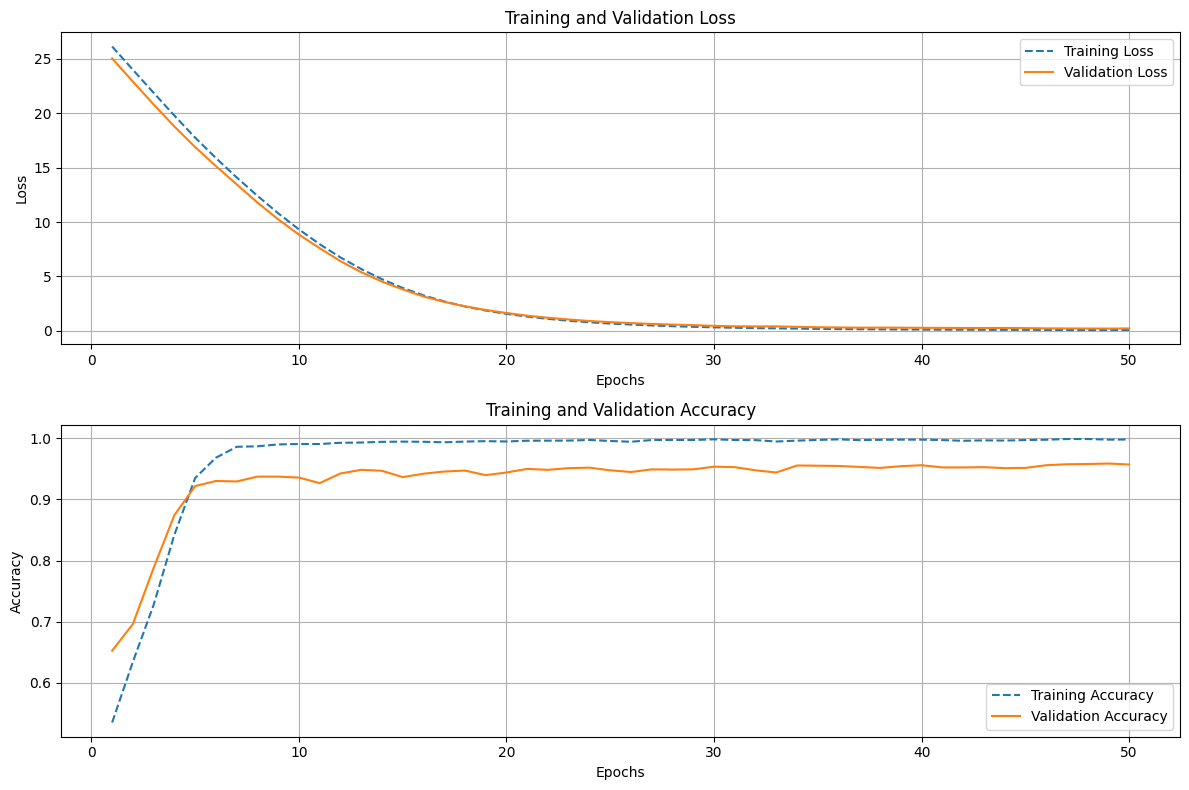

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


2025-01-27 07:07:43.488050: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1687_0', 8 bytes spill stores, 8 bytes spill loads

2025-01-27 07:07:44.158762: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1694', 4 bytes spill stores, 4 bytes spill loads

2025-01-27 07:07:44.281582: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1694', 220 bytes spill stores, 220 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


2025-01-27 07:07:47.336028: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


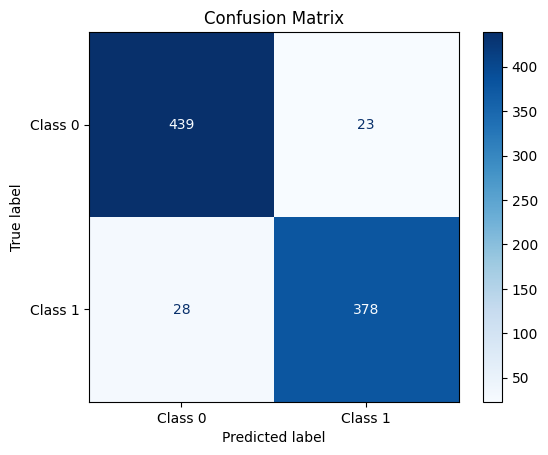


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.94      0.95      0.95       462
     Class 1       0.94      0.93      0.94       406

    accuracy                           0.94       868
   macro avg       0.94      0.94      0.94       868
weighted avg       0.94      0.94      0.94       868


Accuracy: 0.94


In [6]:
# Plot training and validation metrics
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score


# Extract the number of epochs
epochs = range(1, len(ResNet50_model_history_new.history['loss']) + 1)

# Create subplots
plt.figure(figsize=(12, 8))

# Plot accuracy (training and validation)
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second subplot
plt.plot(epochs, ResNet50_model_history_new.history['accuracy'], label='Training Accuracy', linestyle='--')
plt.plot(epochs, ResNet50_model_history_new.history['val_accuracy'], label='Validation Accuracy', linestyle='-')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss (training and validation)
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first subplot
plt.plot(epochs, ResNet50_model_history_new.history['loss'], label='Training Loss', linestyle='--')
plt.plot(epochs, ResNet50_model_history_new.history['val_loss'], label='Validation Loss', linestyle='-')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


# Adjust layout and show the plots
plt.tight_layout()
plt.show()




# Step 1: Get True Labels and Predictions
true_labels = []
predicted_labels = []

# Iterate through the test dataset to get all labels and predictions
for images, labels in test_dataset:
    true_labels.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot to class index
    predictions = ResNet50_model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))  # Get predicted class index

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Step 2: Build and Display Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])  # Update labels as per your classes
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Step 3: Calculate Metrics
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=["Class 0", "Class 1"]))

# Calculate overall accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"\nAccuracy: {accuracy:.2f}")



In [13]:
import tensorflow as tf

tf.compat.v1.reset_default_graph()
tf.keras.backend.clear_session()
gc.collect()

0

2. ResNet101

In [2]:
import numpy as np
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def try_resnet101_model():
    # Load the ResNet101 base model
    base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze all layers initially
    for layer in base_model.layers:
        layer.trainable = False

    # Calculate the index to start unfreezing layers
    from_index = int(np.round((len(base_model.layers) - 1) * (1.0 - 70.0 / 100.0)))

    # Unfreeze layers from the calculated index onwards
    for layer in base_model.layers[from_index:]:
        layer.trainable = True

    # Add custom layers on top (Upper-Layers)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    predictions = Dense(2, activation='softmax')(x)  # Sigmoid for binary classification  # Sigmoid for binary classification

    # Create the model
    ResNet101_model = Model(inputs=base_model.input, outputs=predictions)

    # Define callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
    checkpoint = ModelCheckpoint(
        'best_ResNet101_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    return ResNet101_model, early_stopping, checkpoint


In [3]:
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
import pickle


# Unpack the model and early_stopping
ResNet101_model, early_stopping, checkpoint= try_resnet101_model()

# Compile the model
ResNet101_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

# Summary
# ResNet101.summary()


# Train the model with a unique history variable name
ResNet101_history_new = ResNet101_model.fit(
    train_dataset,  # Replace with your training dataset
    validation_data=validation_dataset,  # Replace with your validation dataset
    epochs=50,  # Number of epochs
    batch_size=16,
    callbacks=[early_stopping, checkpoint]
)

# Save the trained model
ResNet101_model.save("ResNet101_model_new.h5")

# Assume `model_history` is the variable storing the history returned by model.fit()
with open('ResNet101_history_new.pkl', 'wb') as file:
    pickle.dump(ResNet101_history_new.history, file)


Epoch 1/50


I0000 00:00:1738221792.722478 1004575 service.cc:148] XLA service 0x7995e4037540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738221792.722495 1004575 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2025-01-30 10:23:13.639007: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738221797.031099 1004575 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-30 10:23:20.402637: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_23370_0', 204 bytes spill stores, 204 bytes spill loads

I0000 00:00:1738221813.329051 1004575 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.5219 - loss: 26.2094 - precision: 0.5219 - recall: 0.5219
Epoch 1: val_loss improved from inf to 23.33212, saving model to best_ResNet101_model.keras
850/850 ━━━━━━━━━━━━━━━━━━━━ 256s 251ms/step - accuracy: 0.5220 - loss: 26.2083 - precision: 0.5220 - recall: 0.5220 - val_accuracy: 0.6384 - val_loss: 23.3321 - val_precision: 0.6384 - val_recall: 0.6384
Epoch 2/50
850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.6329 - loss: 22.4439 - precision: 0.6329 - recall: 0.6329
Epoch 2: val_loss improved from 23.33212 to 19.76977, saving model to best_ResNet101_model.keras
850/850 ━━━━━━━━━━━━━━━━━━━━ 207s 244ms/step - accuracy: 0.6329 - loss: 22.4428 - precision: 0.6329 - recall: 0.6329 - val_accuracy: 0.7319 - val_loss: 19.7698 - val_precision: 0.7319 - val_recall: 0.7319
Epoch 3/50
850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.7680 - loss: 18.9463 - precision: 0.7680 - recall: 0.7680
Epoch 3: val_loss improved from 19

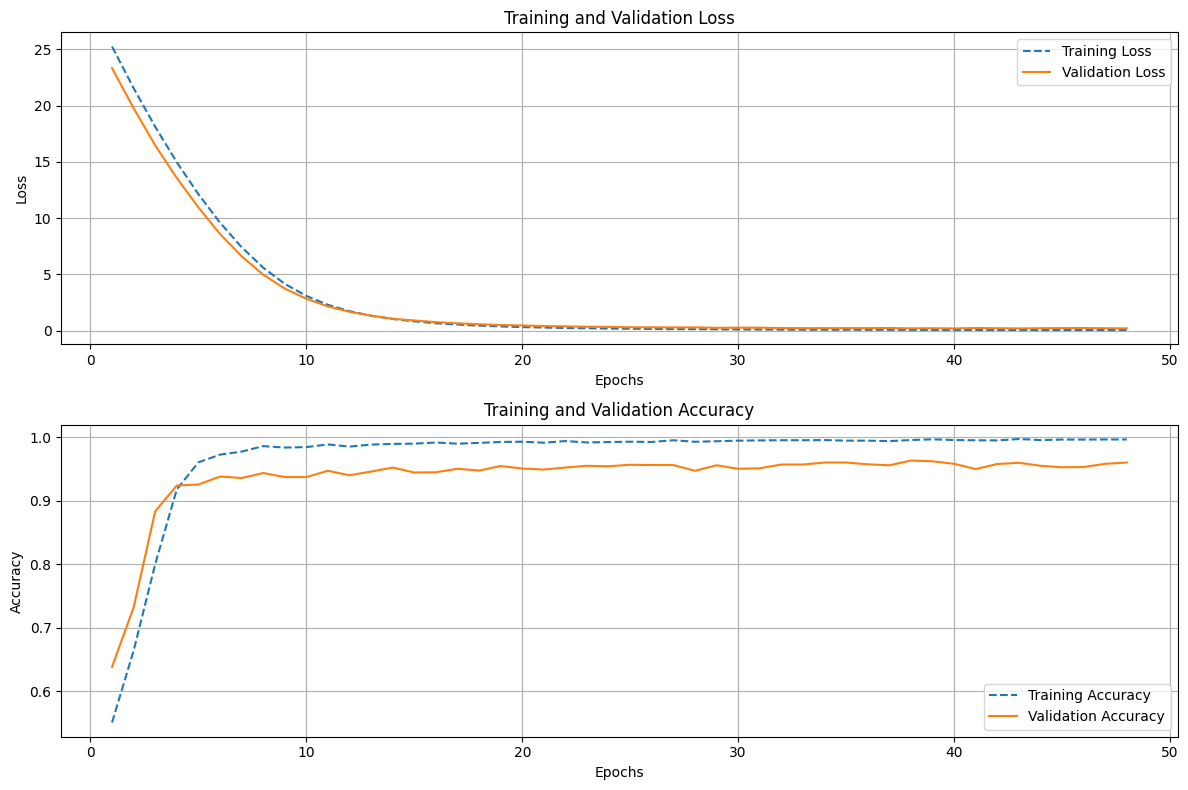

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━

2025-01-30 13:13:48.163128: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3285_0', 8 bytes spill stores, 8 bytes spill loads

2025-01-30 13:13:48.726225: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3292', 220 bytes spill stores, 220 bytes spill loads

2025-01-30 13:13:48.933837: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3292', 4 bytes spill stores, 4 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


2025-01-30 13:13:51.888889: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


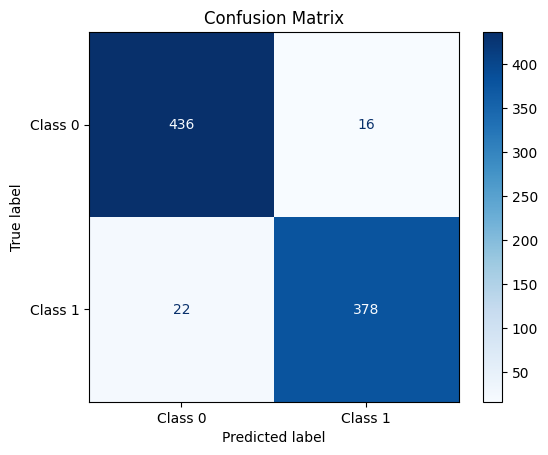


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.95      0.96      0.96       452
     Class 1       0.96      0.94      0.95       400

    accuracy                           0.96       852
   macro avg       0.96      0.95      0.96       852
weighted avg       0.96      0.96      0.96       852


Accuracy: 0.96


In [4]:
# Plot training and validation metrics
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import matplotlib.pyplot as plt

# Extract the number of epochs
epochs = range(1, len(ResNet101_history_new.history['loss']) + 1)

# Create subplots
plt.figure(figsize=(12, 8))

# Plot accuracy (training and validation)
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second subplot
plt.plot(epochs, ResNet101_history_new.history['accuracy'], label='Training Accuracy', linestyle='--')
plt.plot(epochs, ResNet101_history_new.history['val_accuracy'], label='Validation Accuracy', linestyle='-')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss (training and validation)
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first subplot
plt.plot(epochs, ResNet101_history_new.history['loss'], label='Training Loss', linestyle='--')
plt.plot(epochs, ResNet101_history_new.history['val_loss'], label='Validation Loss', linestyle='-')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


# Adjust layout and show the plots
plt.tight_layout()
plt.show()




# Step 1: Get True Labels and Predictions
true_labels = []
predicted_labels = []

# Iterate through the test dataset to get all labels and predictions
for images, labels in test_dataset:
    true_labels.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot to class index
    predictions = ResNet101_model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))  # Get predicted class index

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Step 2: Build and Display Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])  # Update labels as per your classes
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Step 3: Calculate Metrics
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=["Class 0", "Class 1"]))

# Calculate overall accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"\nAccuracy: {accuracy:.2f}")



3. ResNet152

In [ ]:
# import numpy as np
# from tensorflow.keras.applications import ResNet152
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, Concatenate
# from tensorflow.keras.models import Model
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.regularizers import l2

# def try_resnet152_with_radiomics_model(radiomics_input_shape):
#     # Load the ResNet152 base model (image input)
#     base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#     # Freeze all layers initially
#     for layer in base_model.layers:
#         layer.trainable = False

#     # Calculate the index to start unfreezing layers
#     from_index = int(np.round((len(base_model.layers) - 1) * (1.0 - 70.0 / 100.0)))

#     # Unfreeze layers from the calculated index onwards
#     for layer in base_model.layers[from_index:]:
#         layer.trainable = True

#     # Image input part (ResNet152 base model)
#     image_input = Input(shape=(224, 224, 3))
#     x = base_model(image_input)
#     x = GlobalAveragePooling2D()(x)
    
#     # Radiomics input part (additional input for radiomics features)
#     radiomics_input = Input(shape=(radiomics_input_shape,))
#     radiomics_x = Dense(64, activation='relu')(radiomics_input)  # A simple dense layer for radiomics input
#     radiomics_x = Dropout(0.3)(radiomics_x)
    
#     # Concatenate the image features with radiomics features
#     combined = Concatenate()([x, radiomics_x])
    
#     # Add dense layers
#     x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(combined)
#     x = Dropout(0.3)(x)
#     x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
#     x = Dropout(0.3)(x)
#     x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
#     x = Dropout(0.3)(x)
#     x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
#     x = Dropout(0.3)(x)
#     x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
#     x = Dropout(0.3)(x)
#     predictions = Dense(2, activation='softmax')(x)  # Sigmoid for binary classification
    
#     # Create the final model
#     model = Model(inputs=[image_input, radiomics_input], outputs=predictions)

#     # Define callbacks
#     early_stopping = EarlyStopping(
#         monitor='val_loss',
#         patience=5,
#         restore_best_weights=True,
#         verbose=1
#     )
#     checkpoint = ModelCheckpoint(
#         'best_resnet152_with_radiomics_model.keras',
#         monitor='val_loss',
#         save_best_only=True,
#         verbose=1
#     )

#     return model, early_stopping, checkpoint

# # Compile the model
# radiomics_input_shape = 100  # Set this to the number of radiomics features
# ResNet152_with_radiomics_model, early_stopping, checkpoint = try_resnet152_with_radiomics_model(radiomics_input_shape)

# ResNet152_with_radiomics_model.compile(
#     optimizer=Adam(learning_rate=1e-5),
#     loss='categorical_crossentropy',
#     metrics=['accuracy', 'precision', 'recall']
# )

# # Training the model
# history = ResNet152_with_radiomics_model.fit(
#     [train_images, train_radiomics],  # Train with both image and radiomics features
#     validation_data=([validation_images, validation_radiomics], validation_labels),  # Validation
#     epochs=50,
#     batch_size=32,
#     callbacks=[early_stopping, checkpoint]
# )

# # Save the trained model
# ResNet152_with_radiomics_model.save("resnet152_with_radiomics_model_new.h5")

# # Optionally, save the training history for later analysis
# with open('resnet152_with_radiomics_history.pkl', 'wb') as file:
#     pickle.dump(history.history, file)


In [3]:
import numpy as np
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def try_resnet152_model():
    # Load the ResNet152 base model
    base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze all layers initially
    for layer in base_model.layers:
        layer.trainable = False

    # Calculate the index to start unfreezing layers
    from_index = int(np.round((len(base_model.layers) - 1) * (1.0 - 70.0 / 100.0)))

    # Unfreeze layers from the calculated index onwards
    for layer in base_model.layers[from_index:]:
        layer.trainable = True

    # Add custom layers on top (Upper-Layers)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    predictions = Dense(2, activation='softmax')(x) # Sigmoid for binary classification

    # Create the model
    ResNet152_model = Model(inputs=base_model.input, outputs=predictions)

    # Define callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
    checkpoint = ModelCheckpoint(
        'best_resnet152_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    return ResNet152_model, early_stopping, checkpoint


In [4]:
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
import pickle


# Unpack the model and early_stopping
ResNet152_model, early_stopping, checkpoint= try_resnet152_model()

# Compile the model
ResNet152_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

# Summary
# ResNet152_model.summary()


# Train the model with a unique history variable name
resnet152_history_new = ResNet152_model.fit(
    train_dataset,  # Replace with your training dataset
    validation_data=validation_dataset,  # Replace with your validation dataset
    epochs=50,  # Number of epochs
    batch_size=16,
    callbacks=[early_stopping, checkpoint]
)

# Save the trained model
ResNet152_model.save("resnet152_model_new.h5")

# Assume `model_history` is the variable storing the history returned by model.fit()
with open('resnet152_history_new.pkl', 'wb') as file:
    pickle.dump(resnet152_history_new.history, file)


Epoch 1/50


I0000 00:00:1738232207.553904 1020800 service.cc:148] XLA service 0x70252c001ac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738232207.553946 1020800 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2025-01-30 13:16:49.161377: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738232215.713623 1020800 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-30 13:17:01.040737: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_34690_0', 204 bytes spill stores, 204 bytes spill loads

I0000 00:00:1738232238.196737 1020800 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.5281 - loss: 26.3970 - precision: 0.5281 - recall: 0.5281
Epoch 1: val_loss improved from inf to 23.93393, saving model to best_resnet152_model.keras
850/850 ━━━━━━━━━━━━━━━━━━━━ 371s 359ms/step - accuracy: 0.5281 - loss: 26.3960 - precision: 0.5281 - recall: 0.5281 - val_accuracy: 0.6718 - val_loss: 23.9339 - val_precision: 0.6718 - val_recall: 0.6718
Epoch 2/50
850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.6511 - loss: 23.1755 - precision: 0.6511 - recall: 0.6511
Epoch 2: val_loss improved from 23.93393 to 20.77996, saving model to best_resnet152_model.keras
850/850 ━━━━━━━━━━━━━━━━━━━━ 298s 351ms/step - accuracy: 0.6512 - loss: 23.1746 - precision: 0.6512 - recall: 0.6512 - val_accuracy: 0.7626 - val_loss: 20.7800 - val_precision: 0.7626 - val_recall: 0.7626
Epoch 3/50
850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.7838 - loss: 20.0605 - precision: 0.7838 - recall: 0.7838
Epoch 3: val_loss improved from 20

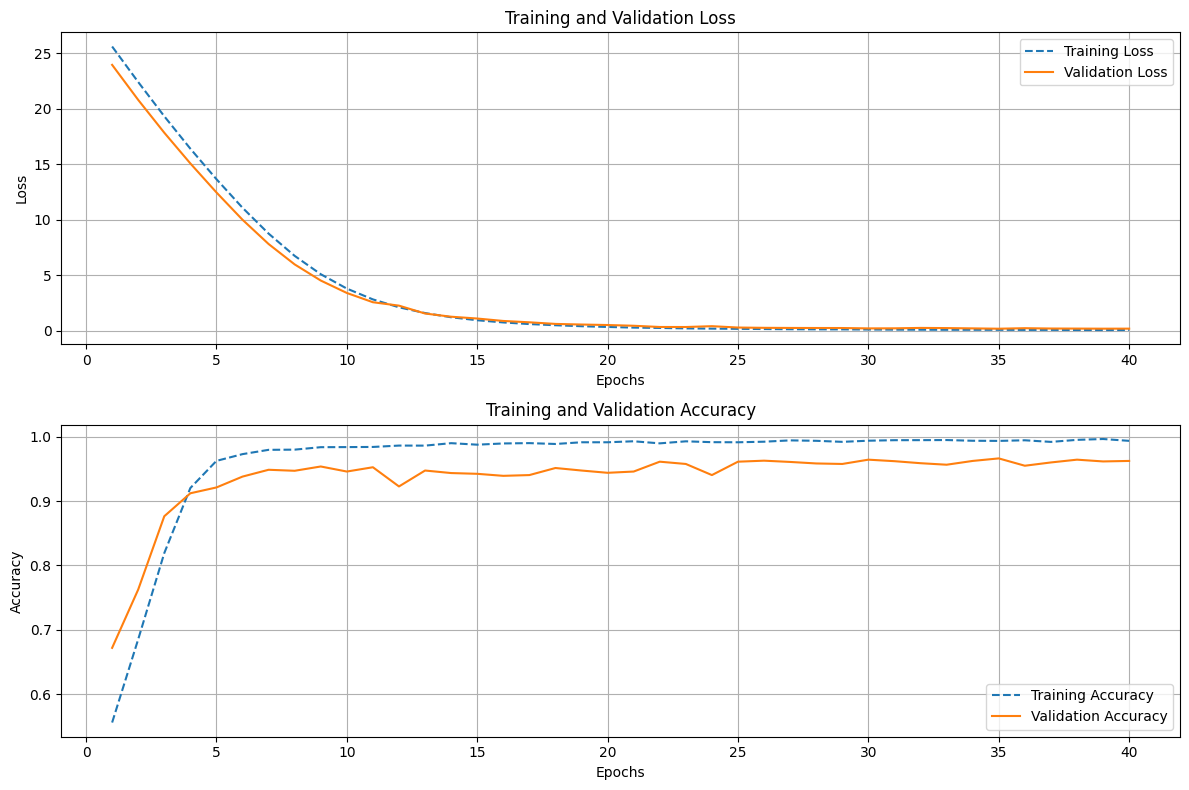

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

2025-01-30 19:59:29.424486: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4883_0', 8 bytes spill stores, 8 bytes spill loads

2025-01-30 19:59:29.881213: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4890', 220 bytes spill stores, 220 bytes spill loads

2025-01-30 19:59:30.183955: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4890', 4 bytes spill stores, 4 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


2025-01-30 19:59:33.401577: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


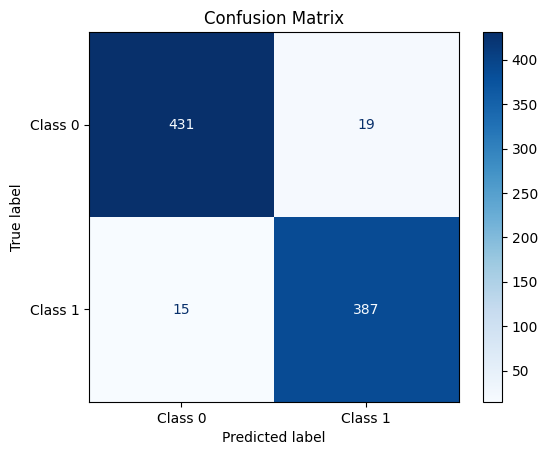


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.97      0.96      0.96       450
     Class 1       0.95      0.96      0.96       402

    accuracy                           0.96       852
   macro avg       0.96      0.96      0.96       852
weighted avg       0.96      0.96      0.96       852


Accuracy: 0.96


In [5]:
# Plot training and validation metrics
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import matplotlib.pyplot as plt


# Extract the number of epochs
epochs = range(1, len(resnet152_history_new.history['loss']) + 1)

plt.figure(figsize=(12, 8))

# Plot accuracy (training and validation)
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second subplot
plt.plot(epochs, resnet152_history_new.history['accuracy'], label='Training Accuracy', linestyle='--')
plt.plot(epochs, resnet152_history_new.history['val_accuracy'], label='Validation Accuracy', linestyle='-')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss (training and validation)
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first subplot
plt.plot(epochs, resnet152_history_new.history['loss'], label='Training Loss', linestyle='--')
plt.plot(epochs, resnet152_history_new.history['val_loss'], label='Validation Loss', linestyle='-')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


# Adjust layout and show the plots
plt.tight_layout()
plt.show()



# Step 1: Get True Labels and Predictions
true_labels = []
predicted_labels = []

# Iterate through the test dataset to get all labels and predictions
for images, labels in test_dataset:
    true_labels.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot to class index
    predictions = ResNet152_model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))  # Get predicted class index

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Step 2: Build and Display Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])  # Update labels as per your classes
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Step 3: Calculate Metrics
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=["Class 0", "Class 1"]))

# Calculate overall accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"\nAccuracy: {accuracy:.2f}")



In [ ]:
import gc
# After training, free up memory
tf.keras.backend.clear_session()
gc.collect()

4. MobileNet

In [7]:
import numpy as np
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def Mobile_Net_try_model():
    # Load the MobileNet base model
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze all layers initially
    for layer in base_model.layers:
        layer.trainable = False

    # Calculate the index to start unfreezing layers
    from_index = int(np.round((len(base_model.layers) - 1) * (1.0 - 70.0 / 100.0)))

    # Unfreeze layers from the calculated index onwards
    for layer in base_model.layers[from_index:]:
        layer.trainable = True

    # Add custom layers on top (Upper-Layers)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    predictions = Dense(2, activation='softmax', kernel_regularizer=l2(0.01))(x) 

    # Create the model
    Mobile_model = Model(inputs=base_model.input, outputs=predictions)

    # Define callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
    checkpoint = ModelCheckpoint(
        'best_MobileNet_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    return Mobile_model, early_stopping, checkpoint

In [8]:
import pickle, gc
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam


# Unpack the model and early_stopping
Mobile_model, early_stopping, checkpoint= Mobile_Net_try_model()

# Compile the model
Mobile_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

# Train the model with a unique history variable name
Mobile_Net_history_new = Mobile_model.fit(
    train_dataset,  # Replace with your training dataset
    validation_data=validation_dataset,  # Replace with your validation dataset
    epochs=50,  # Number of epochs
    batch_size=32,
    callbacks=[early_stopping, checkpoint]
)

# Save the trained model
Mobile_model.save("Mobile_Net_new.h5")

# Assume `model_history` is the variable storing the history returned by model.fit()
with open('Mobile_Net_history_new.pkl', 'wb') as file:
    pickle.dump(Mobile_Net_history_new.history, file)



Epoch 1/50


2025-01-27 15:50:14.429738: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5480_0', 100 bytes spill stores, 100 bytes spill loads

2025-01-27 15:50:14.561515: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5480', 204 bytes spill stores, 204 bytes spill loads

2025-01-27 15:50:14.934783: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5480_0', 204 bytes spill stores, 204 bytes spill loads

2025-01-27 15:50:15.288858: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8119', 60 bytes spill stores, 64 bytes spill loads

2025-01-27 15:50:15.582221: I external/local_xla/x

425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5200 - loss: 23.4311 - precision: 0.5200 - recall: 0.5200
Epoch 1: val_loss improved from inf to 22.20622, saving model to best_MobileNet_model.keras
425/425 ━━━━━━━━━━━━━━━━━━━━ 47s 71ms/step - accuracy: 0.5200 - loss: 23.4301 - precision: 0.5200 - recall: 0.5200 - val_accuracy: 0.5989 - val_loss: 22.2062 - val_precision: 0.5989 - val_recall: 0.5989
Epoch 2/50
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5266 - loss: 21.8443 - precision: 0.5266 - recall: 0.5266
Epoch 2: val_loss improved from 22.20622 to 20.65968, saving model to best_MobileNet_model.keras
425/425 ━━━━━━━━━━━━━━━━━━━━ 28s 66ms/step - accuracy: 0.5267 - loss: 21.8434 - precision: 0.5267 - recall: 0.5267 - val_accuracy: 0.6167 - val_loss: 20.6597 - val_precision: 0.6167 - val_recall: 0.6167
Epoch 3/50
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5780 - loss: 20.2878 - precision: 0.5780 - recall: 0.5780
Epoch 3: val_loss improved from 20.65968 

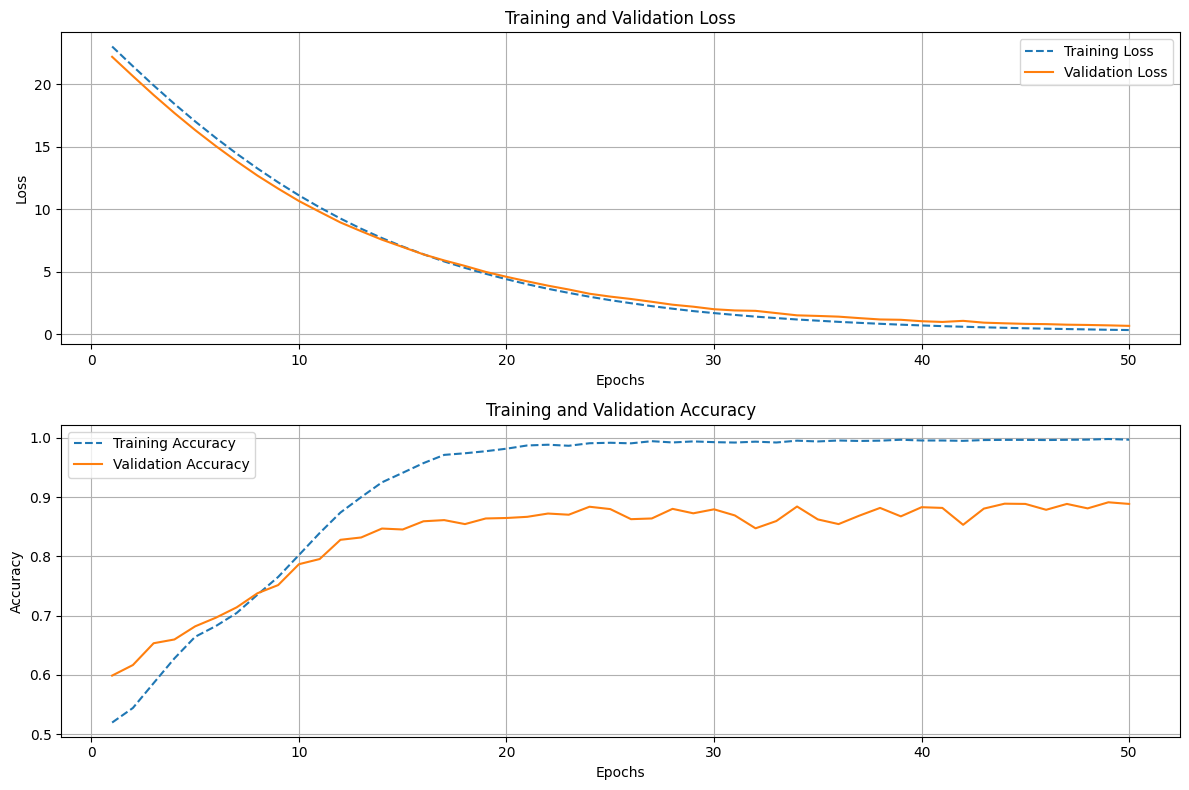

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━

2025-01-27 16:19:42.905258: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_671', 4 bytes spill stores, 4 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


2025-01-27 16:19:44.901830: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


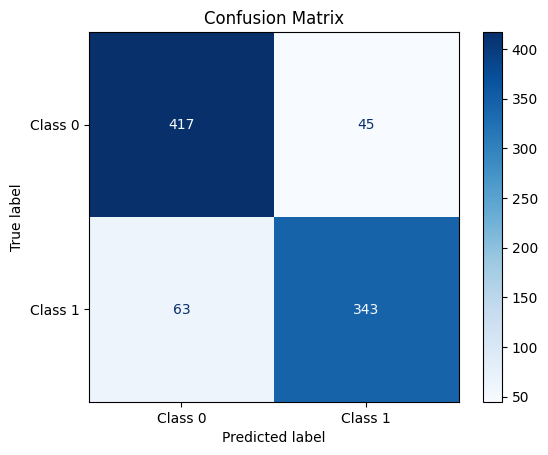


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.87      0.90      0.89       462
     Class 1       0.88      0.84      0.86       406

    accuracy                           0.88       868
   macro avg       0.88      0.87      0.87       868
weighted avg       0.88      0.88      0.88       868


Accuracy: 0.88


In [9]:
# Plot training and validation metrics
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import matplotlib.pyplot as plt

# Extract the number of epochs
epochs = range(1, len(Mobile_Net_history_new.history['loss']) + 1)

# Create subplots
plt.figure(figsize=(12, 8))

# Plot accuracy (training and validation)
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second subplot
plt.plot(epochs, Mobile_Net_history_new.history['accuracy'], label='Training Accuracy', linestyle='--')
plt.plot(epochs, Mobile_Net_history_new.history['val_accuracy'], label='Validation Accuracy', linestyle='-')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss (training and validation)
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first subplot
plt.plot(epochs, Mobile_Net_history_new.history['loss'], label='Training Loss', linestyle='--')
plt.plot(epochs, Mobile_Net_history_new.history['val_loss'], label='Validation Loss', linestyle='-')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


# Adjust layout and show the plots
plt.tight_layout()
plt.show()



# Step 1: Get True Labels and Predictions
true_labels = []
predicted_labels = []

# Iterate through the test dataset to get all labels and predictions
for images, labels in test_dataset:
    true_labels.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot to class index
    predictions = Mobile_model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))  # Get predicted class index

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Step 2: Build and Display Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])  # Update labels as per your classes
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Step 3: Calculate Metrics
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=["Class 0", "Class 1"]))

# Calculate overall accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"\nAccuracy: {accuracy:.2f}")


In [ ]:
import gc
# After training, free up memory
tf.keras.backend.clear_session()
gc.collect()

5. VGG16

In [3]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import pickle

def try_model_vgg16():
    # Load the base model with VGG16
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze all layers initially
    for layer in base_model.layers:
        layer.trainable = False

    # Calculate the index to start unfreezing layers
    from_index = int(np.round((len(base_model.layers) - 1) * (1.0 - 70.0 / 100.0)))

    # Unfreeze layers from the calculated index onwards
    for layer in base_model.layers[from_index:]:
        layer.trainable = True

    # Add custom layers on top (Upper-Layers)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    predictions = Dense(2, activation='softmax', kernel_regularizer=l2(0.01))(x)  # Assuming binary classification

    vgg16_model = Model(inputs=base_model.input, outputs=predictions)
    
    # Define callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
    checkpoint = ModelCheckpoint(
        'best_vgg16_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
    
    return vgg16_model, early_stopping, checkpoint

# Create the model
vgg16_model, early_stopping, checkpoint = try_model_vgg16()

# Compile the model
vgg16_model.compile(optimizer=Adam(learning_rate=1e-4),
                       loss='categorical_crossentropy',
                       metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])



# Train the model
vgg16_model_history_new = vgg16_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size=32,
    epochs=50,
    callbacks=[early_stopping, checkpoint]
)

vgg16_model.save('model_vgg16_new.h5')

# Assume `model_history` is the variable storing the history returned by model.fit()
with open('vgg16_model_history_new.pkl', 'wb') as file:
    pickle.dump(vgg16_model_history_new.history, file)


Epoch 1/50


I0000 00:00:1737984125.431191  683772 service.cc:148] XLA service 0x7abaac00bee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737984125.431244  683772 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2025-01-27 16:22:05.509619: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737984125.868707  683772 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-27 16:22:07.638700: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3312', 104 bytes spill stores, 104 bytes spill loads

2025-01-27 16:22:07.832930: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot

425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.5252 - loss: 16.1381 - precision: 0.5252 - recall: 0.5252

2025-01-27 16:24:57.220403: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_271_0', 88 bytes spill stores, 120 bytes spill loads

2025-01-27 16:24:57.479820: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_271', 220 bytes spill stores, 220 bytes spill loads




Epoch 1: val_loss improved from inf to 6.76211, saving model to best_vgg16_model.keras
425/425 ━━━━━━━━━━━━━━━━━━━━ 194s 380ms/step - accuracy: 0.5252 - loss: 16.1295 - precision: 0.5252 - recall: 0.5252 - val_accuracy: 0.5439 - val_loss: 6.7621 - val_precision: 0.5439 - val_recall: 0.5439
Epoch 2/50
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.6250 - loss: 5.3364 - precision: 0.6250 - recall: 0.6250
Epoch 2: val_loss improved from 6.76211 to 2.63734, saving model to best_vgg16_model.keras
425/425 ━━━━━━━━━━━━━━━━━━━━ 152s 359ms/step - accuracy: 0.6250 - loss: 5.3339 - precision: 0.6250 - recall: 0.6250 - val_accuracy: 0.6503 - val_loss: 2.6373 - val_precision: 0.6503 - val_recall: 0.6503
Epoch 3/50
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.6663 - loss: 2.2382 - precision: 0.6663 - recall: 0.6663
Epoch 3: val_loss improved from 2.63734 to 1.38750, saving model to best_vgg16_model.keras
425/425 ━━━━━━━━━━━━━━━━━━━━ 152s 358ms/step - accuracy: 0.6663 - loss: 2

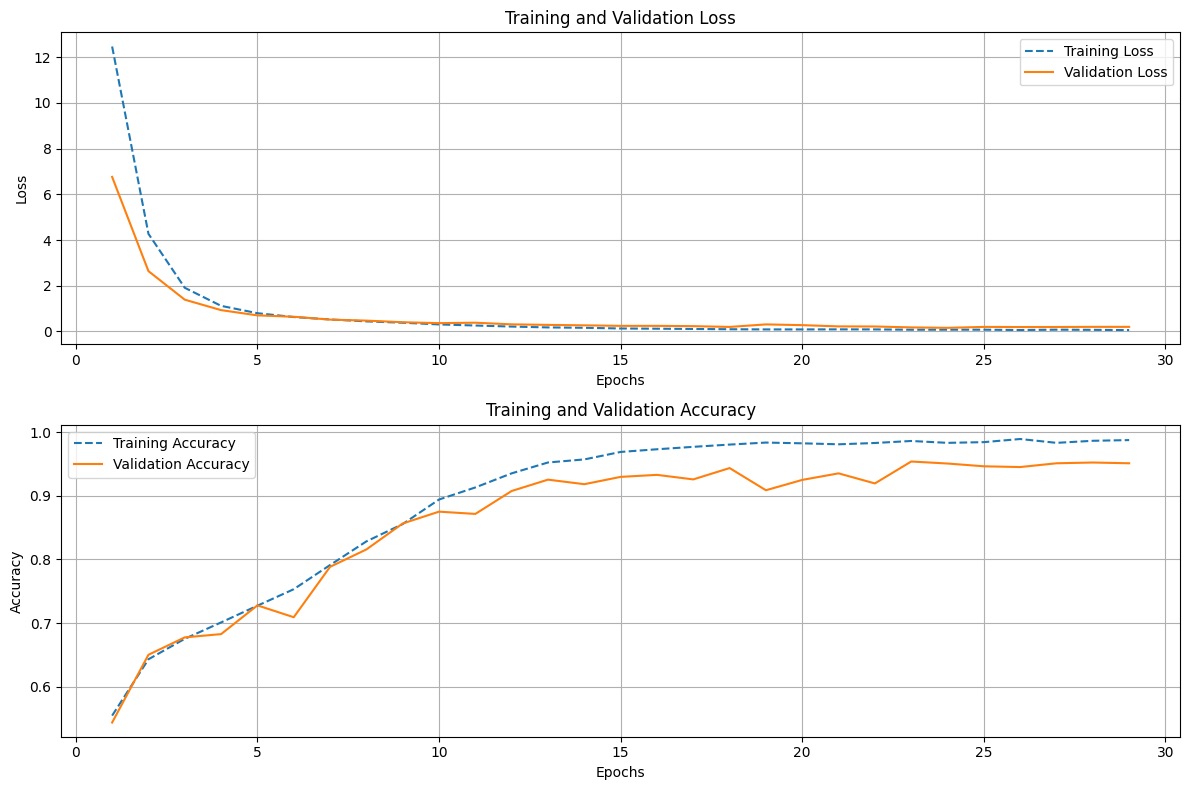

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

2025-01-27 18:38:55.508800: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_197', 220 bytes spill stores, 220 bytes spill loads

2025-01-27 18:38:56.055437: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_197', 4 bytes spill stores, 4 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


2025-01-27 18:38:59.593909: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


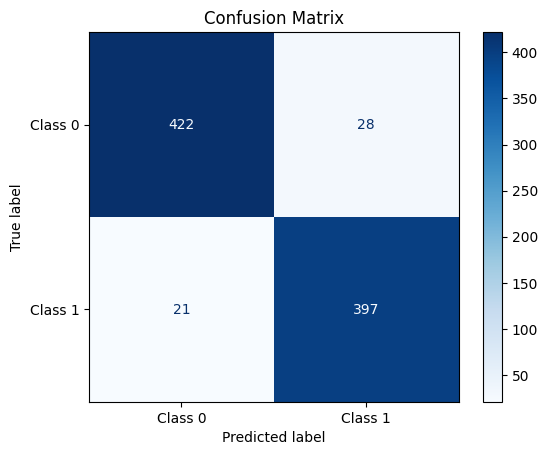


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.95      0.94      0.95       450
     Class 1       0.93      0.95      0.94       418

    accuracy                           0.94       868
   macro avg       0.94      0.94      0.94       868
weighted avg       0.94      0.94      0.94       868


Accuracy: 0.94


In [4]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import matplotlib.pyplot as plt

# Extract the number of epochs
epochs = range(1, len(vgg16_model_history_new.history['loss']) + 1)

# Create subplots
plt.figure(figsize=(12, 8))

# Plot accuracy (training and validation)
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second subplot
plt.plot(epochs, vgg16_model_history_new.history['accuracy'], label='Training Accuracy', linestyle='--')
plt.plot(epochs, vgg16_model_history_new.history['val_accuracy'], label='Validation Accuracy', linestyle='-')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss (training and validation)
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first subplot
plt.plot(epochs, vgg16_model_history_new.history['loss'], label='Training Loss', linestyle='--')
plt.plot(epochs, vgg16_model_history_new.history['val_loss'], label='Validation Loss', linestyle='-')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


# Adjust layout and show the plots
plt.tight_layout()
plt.show()



# Step 1: Get True Labels and Predictions
true_labels = []
predicted_labels = []

# Iterate through the test dataset to get all labels and predictions
for images, labels in test_dataset:
    true_labels.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot to class index
    predictions = vgg16_model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))  # Get predicted class index

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Step 2: Build and Display Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])  # Update labels as per your classes
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Step 3: Calculate Metrics
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=["Class 0", "Class 1"]))

# Calculate overall accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"\nAccuracy: {accuracy:.2f}")



In [ ]:
import gc
# After training, free up memory
tf.keras.backend.clear_session()
gc.collect()

6. VGG19

In [3]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import pickle


def try_model_vgg19():
    # Load the base model with VGG16
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze all layers initially
    for layer in base_model.layers:
        layer.trainable = False

    # Calculate the index to start unfreezing layers
    from_index = int(np.round((len(base_model.layers) - 1) * (1.0 - 70.0 / 100.0)))

    # Unfreeze layers from the calculated index onwards
    for layer in base_model.layers[from_index:]:
        layer.trainable = True

    # Add custom layers on top (Upper-Layers)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    predictions = Dense(2, activation='softmax', kernel_regularizer=l2(0.01))(x)  # Assuming binary classification

    vgg19_model = Model(inputs=base_model.input, outputs=predictions)
    
    # Define callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
    checkpoint = ModelCheckpoint(
        'best_vgg19_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
    
    return vgg19_model, early_stopping, checkpoint

# Create the model
vgg19_model, early_stopping, checkpoint = try_model_vgg19()

# Compile the model
vgg19_model.compile(optimizer=Adam(learning_rate=1e-5),
                       loss='categorical_crossentropy',
                       metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

# Train the model
vgg19_model_history_new = vgg19_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size=32,
    epochs=50,
    callbacks=[early_stopping, checkpoint]
)

vgg19_model.save('model_vgg19_new.h5')

# Assume `model_history` is the variable storing the history returned by model.fit()
with open('vgg19_model_history_new.pkl', 'wb') as file:
    pickle.dump(vgg19_model_history_new.history, file)


Epoch 1/50


I0000 00:00:1737956772.617393  623698 service.cc:148] XLA service 0x73eed4020c70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737956772.617462  623698 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2025-01-27 08:46:12.705144: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737956773.108106  623698 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-27 08:46:14.509646: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3813', 68 bytes spill stores, 72 bytes spill loads

2025-01-27 08:46:14.810295: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3

425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.5115 - loss: 20.0376 - precision: 0.5115 - recall: 0.5115

2025-01-27 08:49:29.549660: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_301_0', 88 bytes spill stores, 120 bytes spill loads

2025-01-27 08:49:29.956433: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_301', 220 bytes spill stores, 220 bytes spill loads




Epoch 1: val_loss improved from inf to 18.50238, saving model to best_vgg19_model.keras
425/425 ━━━━━━━━━━━━━━━━━━━━ 221s 450ms/step - accuracy: 0.5115 - loss: 20.0363 - precision: 0.5115 - recall: 0.5115 - val_accuracy: 0.5906 - val_loss: 18.5024 - val_precision: 0.5906 - val_recall: 0.5906
Epoch 2/50
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.5510 - loss: 17.9985 - precision: 0.5510 - recall: 0.5510
Epoch 2: val_loss improved from 18.50238 to 16.50222, saving model to best_vgg19_model.keras
425/425 ━━━━━━━━━━━━━━━━━━━━ 183s 430ms/step - accuracy: 0.5511 - loss: 17.9973 - precision: 0.5511 - recall: 0.5511 - val_accuracy: 0.6195 - val_loss: 16.5022 - val_precision: 0.6195 - val_recall: 0.6195
Epoch 3/50
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.6083 - loss: 16.0326 - precision: 0.6083 - recall: 0.6083
Epoch 3: val_loss improved from 16.50222 to 14.64152, saving model to best_vgg19_model.keras
425/425 ━━━━━━━━━━━━━━━━━━━━ 183s 429ms/step - accuracy: 0.6083

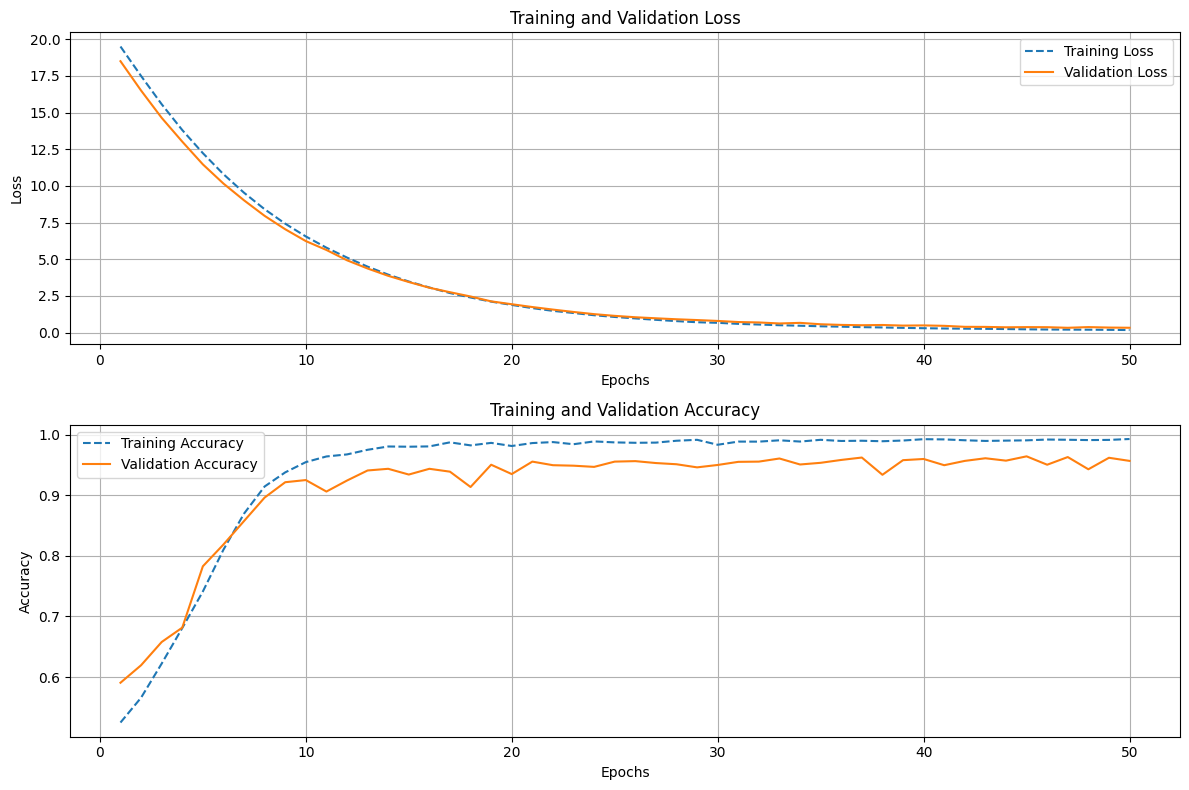

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

2025-01-27 11:20:58.824243: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_227', 220 bytes spill stores, 220 bytes spill loads

2025-01-27 11:20:59.670993: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_227', 4 bytes spill stores, 4 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


2025-01-27 11:21:02.630898: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


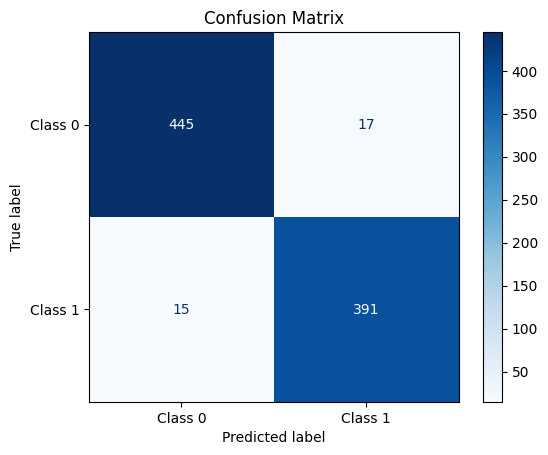


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.97      0.96      0.97       462
     Class 1       0.96      0.96      0.96       406

    accuracy                           0.96       868
   macro avg       0.96      0.96      0.96       868
weighted avg       0.96      0.96      0.96       868


Accuracy: 0.96


In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

import matplotlib.pyplot as plt

# Extract the number of epochs
epochs = range(1, len(vgg19_model_history_new.history['loss']) + 1)

# Create subplots
plt.figure(figsize=(12, 8))

# Plot loss (training and validation)
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first subplot
plt.plot(epochs, vgg19_model_history_new.history['loss'], label='Training Loss', linestyle='--')
plt.plot(epochs, vgg19_model_history_new.history['val_loss'], label='Validation Loss', linestyle='-')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot accuracy (training and validation)
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second subplot
plt.plot(epochs, vgg19_model_history_new.history['accuracy'], label='Training Accuracy', linestyle='--')
plt.plot(epochs, vgg19_model_history_new.history['val_accuracy'], label='Validation Accuracy', linestyle='-')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

# Step 1: Get True Labels and Predictions
true_labels = []
predicted_labels = []

# Iterate through the test dataset to get all labels and predictions
for images, labels in test_dataset:
    true_labels.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot to class index
    predictions = vgg19_model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))  # Get predicted class index

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Step 2: Build and Display Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])  # Update labels as per your classes
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Step 3: Calculate Metrics
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=["Class 0", "Class 1"]))

# Calculate overall accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"\nAccuracy: {accuracy:.2f}")


In [ ]:
import gc
# After training, free up memory
tf.keras.backend.clear_session()
gc.collect()

7. DenseNet121

In [3]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import pickle

def try_model_DenseNet121():
    # Load the base model with VGG16
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze all layers initially
    for layer in base_model.layers:
        layer.trainable = False

    # Calculate the index to start unfreezing layers
    from_index = int(np.round((len(base_model.layers) - 1) * (1.0 - 70.0 / 100.0)))

    # Unfreeze layers from the calculated index onwards
    for layer in base_model.layers[from_index:]:
        layer.trainable = True

    # Add custom layers on top (Upper-Layers)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    predictions = Dense(2, activation='softmax', kernel_regularizer=l2(0.01))(x)

    DenseNet121_model = Model(inputs=base_model.input, outputs=predictions)
    
    # Define callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
    checkpoint = ModelCheckpoint(
        'best_DenseNet121_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
    
    return DenseNet121_model, early_stopping, checkpoint

# Create the model
DenseNet121_model, early_stopping, checkpoint = try_model_DenseNet121()

# Compile the model
DenseNet121_model.compile(optimizer=Adam(learning_rate=1e-5),
                       loss='categorical_crossentropy',
                       metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])


# Train the model
DenseNet121_model_history_new = DenseNet121_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size=32,
    epochs=50,
    callbacks=[early_stopping, checkpoint]
)

DenseNet121_model.save('model_DenseNet121_new.h5')



# Assume `model_history` is the variable storing the history returned by model.fit()
with open('DenseNet121_model_history_new.pkl', 'wb') as file:
    pickle.dump(DenseNet121_model_history_new.history, file)


Epoch 1/50


I0000 00:00:1737966318.323686  639221 service.cc:148] XLA service 0x77972c0028c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737966318.323725  639221 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2025-01-27 11:25:19.331223: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737966323.079102  639221 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-27 11:25:26.522307: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_26399_0', 100 bytes spill stores, 100 bytes spill loads

2025-01-27 11:25:26.985363: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_

425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.5017 - loss: 23.1887 - precision: 0.5017 - recall: 0.5017

2025-01-27 11:27:32.704811: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3402_0', 88 bytes spill stores, 120 bytes spill loads

2025-01-27 11:27:33.844905: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3402', 220 bytes spill stores, 220 bytes spill loads




Epoch 1: val_loss improved from inf to 21.33049, saving model to best_DenseNet121_model.keras
425/425 ━━━━━━━━━━━━━━━━━━━━ 172s 182ms/step - accuracy: 0.5017 - loss: 23.1872 - precision: 0.5017 - recall: 0.5017 - val_accuracy: 0.5906 - val_loss: 21.3305 - val_precision: 0.5906 - val_recall: 0.5906
Epoch 2/50
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.5480 - loss: 20.7838 - precision: 0.5480 - recall: 0.5480
Epoch 2: val_loss improved from 21.33049 to 19.14271, saving model to best_DenseNet121_model.keras
425/425 ━━━━━━━━━━━━━━━━━━━━ 67s 157ms/step - accuracy: 0.5480 - loss: 20.7825 - precision: 0.5480 - recall: 0.5480 - val_accuracy: 0.6519 - val_loss: 19.1427 - val_precision: 0.6519 - val_recall: 0.6519
Epoch 3/50
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.5925 - loss: 18.6478 - precision: 0.5925 - recall: 0.5925
Epoch 3: val_loss improved from 19.14271 to 17.15965, saving model to best_DenseNet121_model.keras
425/425 ━━━━━━━━━━━━━━━━━━━━ 67s 158ms/step - 

2025-01-27 11:42:05.405424: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554688 bytes after encountering the first element of size 33554688 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 14: val_loss improved from 5.76147 to 5.12420, saving model to best_DenseNet121_model.keras
425/425 ━━━━━━━━━━━━━━━━━━━━ 67s 157ms/step - accuracy: 0.9828 - loss: 5.3649 - precision: 0.9828 - recall: 0.9828 - val_accuracy: 0.9276 - val_loss: 5.1242 - val_precision: 0.9276 - val_recall: 0.9276
Epoch 15/50
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9863 - loss: 4.7375 - precision: 0.9863 - recall: 0.9863
Epoch 15: val_loss improved from 5.12420 to 4.54403, saving model to best_DenseNet121_model.keras
425/425 ━━━━━━━━━━━━━━━━━━━━ 66s 156ms/step - accuracy: 0.9863 - loss: 4.7372 - precision: 0.9863 - recall: 0.9863 - val_accuracy: 0.9217 - val_loss: 4.5440 - val_precision: 0.9217 - val_recall: 0.9217
Epoch 16/50
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9857 - loss: 4.1825 - precision: 0.9857 - recall: 0.9857
Epoch 16: val_loss improved from 4.54403 to 4.02919, saving model to best_DenseNet121_model.keras
425/425 ━━━━━━━━━━━━━━━━━━━━ 66s 155ms/step - acc

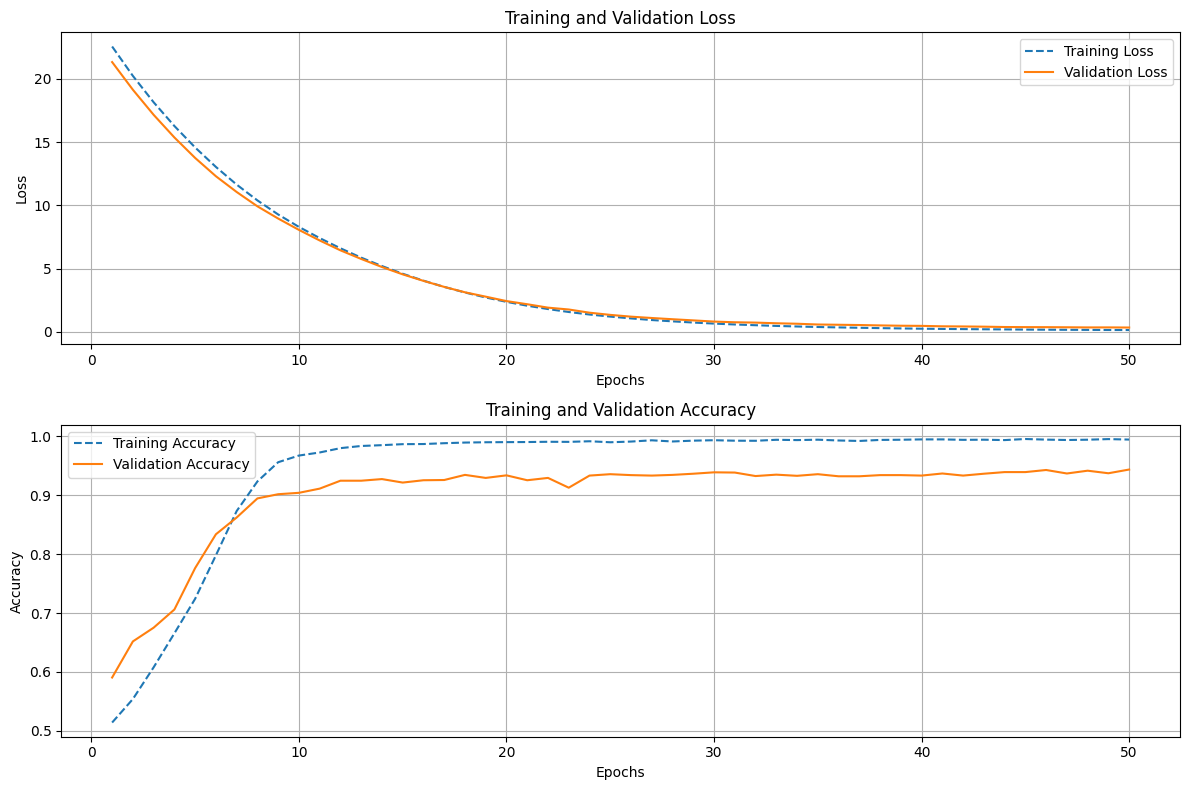

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━

2025-01-27 12:31:44.090505: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3281', 4 bytes spill stores, 4 bytes spill loads

2025-01-27 12:31:44.539942: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3288', 220 bytes spill stores, 220 bytes spill loads

2025-01-27 12:31:45.636831: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3288', 4 bytes spill stores, 4 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


2025-01-27 12:31:56.231582: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


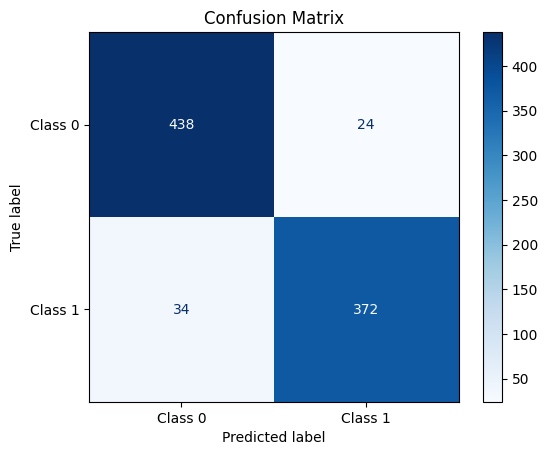


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.93      0.95      0.94       462
     Class 1       0.94      0.92      0.93       406

    accuracy                           0.93       868
   macro avg       0.93      0.93      0.93       868
weighted avg       0.93      0.93      0.93       868


Accuracy: 0.93


In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

# Extract the number of epochs
epochs = range(1, len(DenseNet121_model_history_new.history['loss']) + 1)

# Create subplots
plt.figure(figsize=(12, 8))

# Plot accuracy (training and validation)
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second subplot
plt.plot(epochs, DenseNet121_model_history_new.history['accuracy'], label='Training Accuracy', linestyle='--')
plt.plot(epochs, DenseNet121_model_history_new.history['val_accuracy'], label='Validation Accuracy', linestyle='-')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss (training and validation)
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first subplot
plt.plot(epochs, DenseNet121_model_history_new.history['loss'], label='Training Loss', linestyle='--')
plt.plot(epochs, DenseNet121_model_history_new.history['val_loss'], label='Validation Loss', linestyle='-')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


# Adjust layout and show the plots
plt.tight_layout()
plt.show()


# Step 1: Get True Labels and Predictions
true_labels = []
predicted_labels = []

# Iterate through the test dataset to get all labels and predictions
for images, labels in test_dataset:
    true_labels.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot to class index
    predictions = DenseNet121_model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))  # Get predicted class index

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Step 2: Build and Display Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])  # Update labels as per your classes
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Step 3: Calculate Metrics
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=["Class 0", "Class 1"]))

# Calculate overall accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"\nAccuracy: {accuracy:.2f}")


In [ ]:
import gc
# After training, free up memory
tf.keras.backend.clear_session()
gc.collect()

8. InceptionV3

In [3]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import pickle

def try_model_InceptionV3():
    # Load the base model with VGG16
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze all layers initially
    for layer in base_model.layers:
        layer.trainable = False

    # Calculate the index to start unfreezing layers
    from_index = int(np.round((len(base_model.layers) - 1) * (1.0 - 70.0 / 100.0)))

    # Unfreeze layers from the calculated index onwards
    for layer in base_model.layers[from_index:]:
        layer.trainable = True

    # Add custom layers on top (Upper-Layers)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    predictions = Dense(2, activation='softmax', kernel_regularizer=l2(0.01))(x)  # Assuming binary classification

    InceptionV3_model = Model(inputs=base_model.input, outputs=predictions)
    
    # Define callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
    checkpoint = ModelCheckpoint(
        'best_InceptionV3_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
    
    return InceptionV3_model, early_stopping, checkpoint

# Create the model
InceptionV3_model, early_stopping, checkpoint = try_model_InceptionV3()

# Compile the model
InceptionV3_model.compile(optimizer=Adam(learning_rate=1e-5),
                       loss='categorical_crossentropy',
                       metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

# Train the model
InceptionV3_model_history_new = InceptionV3_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size=32,
    epochs=50,
    callbacks=[early_stopping, checkpoint]
)

InceptionV3_model.save('InceptionV3_model_new.h5')

# Assume `model_history` is the variable storing the history returned by model.fit()
with open('InceptionV3_model_history_new.pkl', 'wb') as file:
    pickle.dump(InceptionV3_model_history_new.history, file)


Epoch 1/50


I0000 00:00:1737992493.299049  697068 service.cc:148] XLA service 0x7d5c40003300 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737992493.299096  697068 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2025-01-27 18:41:33.807849: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737992495.812752  697068 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-27 18:41:38.021256: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_18669_0', 112 bytes spill stores, 224 bytes spill loads

2025-01-27 18:41:38.331433: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_

  1/425 ━━━━━━━━━━━━━━━━━━━━ 4:58:37 42s/step - accuracy: 0.4375 - loss: 27.2331 - precision: 0.4375 - recall: 0.4375

I0000 00:00:1737992522.995074  697068 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.4977 - loss: 26.4923 - precision: 0.4977 - recall: 0.4977

2025-01-27 18:43:04.092616: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2501_0', 88 bytes spill stores, 120 bytes spill loads

2025-01-27 18:43:04.284093: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2501', 220 bytes spill stores, 220 bytes spill loads




Epoch 1: val_loss improved from inf to 24.36760, saving model to best_InceptionV3_model.keras
425/425 ━━━━━━━━━━━━━━━━━━━━ 113s 166ms/step - accuracy: 0.4977 - loss: 26.4906 - precision: 0.4977 - recall: 0.4977 - val_accuracy: 0.5593 - val_loss: 24.3676 - val_precision: 0.5593 - val_recall: 0.5593
Epoch 2/50
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.5184 - loss: 23.6847 - precision: 0.5184 - recall: 0.5184
Epoch 2: val_loss improved from 24.36760 to 21.62580, saving model to best_InceptionV3_model.keras
425/425 ━━━━━━━━━━━━━━━━━━━━ 65s 153ms/step - accuracy: 0.5184 - loss: 23.6831 - precision: 0.5184 - recall: 0.5184 - val_accuracy: 0.6036 - val_loss: 21.6258 - val_precision: 0.6036 - val_recall: 0.6036
Epoch 3/50
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.5297 - loss: 20.9761 - precision: 0.5297 - recall: 0.5297
Epoch 3: val_loss improved from 21.62580 to 19.04220, saving model to best_InceptionV3_model.keras
425/425 ━━━━━━━━━━━━━━━━━━━━ 65s 153ms/step - 

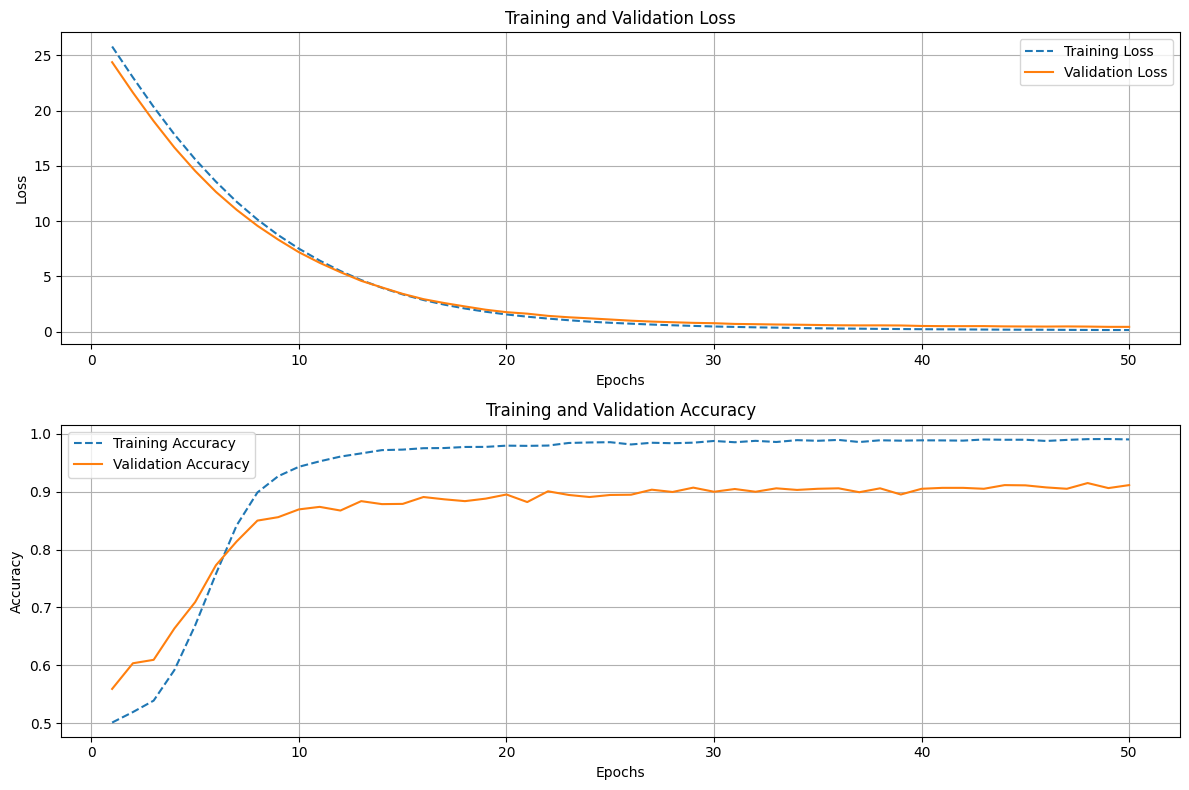

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━

2025-01-27 20:39:14.181775: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2420_0', 8 bytes spill stores, 8 bytes spill loads

2025-01-27 20:39:14.932847: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2427', 220 bytes spill stores, 220 bytes spill loads

2025-01-27 20:39:15.859261: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2427', 4 bytes spill stores, 4 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


2025-01-27 20:39:21.561010: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


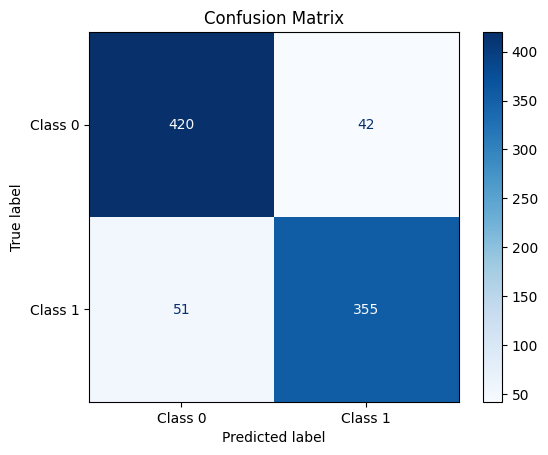


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.89      0.91      0.90       462
     Class 1       0.89      0.87      0.88       406

    accuracy                           0.89       868
   macro avg       0.89      0.89      0.89       868
weighted avg       0.89      0.89      0.89       868


Accuracy: 0.89


In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

# Extract the number of epochs
epochs = range(1, len(InceptionV3_model_history_new.history['loss']) + 1)

# Create subplots
plt.figure(figsize=(12, 8))

# Plot accuracy (training and validation)
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second subplot
plt.plot(epochs, InceptionV3_model_history_new.history['accuracy'], label='Training Accuracy', linestyle='--')
plt.plot(epochs, InceptionV3_model_history_new.history['val_accuracy'], label='Validation Accuracy', linestyle='-')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss (training and validation)
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first subplot
plt.plot(epochs, InceptionV3_model_history_new.history['loss'], label='Training Loss', linestyle='--')
plt.plot(epochs, InceptionV3_model_history_new.history['val_loss'], label='Validation Loss', linestyle='-')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


# Adjust layout and show the plots
plt.tight_layout()
plt.show()

# Step 1: Get True Labels and Predictions
true_labels = []
predicted_labels = []

# Iterate through the test dataset to get all labels and predictions
for images, labels in test_dataset:
    true_labels.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot to class index
    predictions = InceptionV3_model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))  # Get predicted class index

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Step 2: Build and Display Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])  # Update labels as per your classes
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Step 3: Calculate Metrics
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=["Class 0", "Class 1"]))

# Calculate overall accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"\nAccuracy: {accuracy:.2f}")


In [ ]:
import gc
# After training, free up memory
tf.keras.backend.clear_session()
gc.collect()

9. DenseNet169

In [3]:
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import pickle

def try_model_DenseNet169():
    # Load the base model with VGG16
    base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze all layers initially
    for layer in base_model.layers:
        layer.trainable = False

    # Calculate the index to start unfreezing layers
    from_index = int(np.round((len(base_model.layers) - 1) * (1.0 - 70.0 / 100.0)))

    # Unfreeze layers from the calculated index onwards
    for layer in base_model.layers[from_index:]:
        layer.trainable = True

    # Add custom layers on top (Upper-Layers)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    predictions = Dense(2, activation='softmax', kernel_regularizer=l2(0.01))(x)  # Assuming binary classification

    DenseNet169_model = Model(inputs=base_model.input, outputs=predictions)
    
    # Define callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
    checkpoint = ModelCheckpoint(
        'best_DenseNet169_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
    
    return DenseNet169_model, early_stopping, checkpoint

# Create the model
DenseNet169_model, early_stopping, checkpoint = try_model_DenseNet169()

# Compile the model
DenseNet169_model.compile(optimizer=Adam(learning_rate=1e-5),
                       loss='categorical_crossentropy',
                       metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

# Train the model
DenseNet169_model_history_new = DenseNet169_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size=32,
    epochs=50,
    callbacks=[early_stopping, checkpoint]
    
)

DenseNet169_model.save('DenseNet169_model_new.h5')



# Assume `model_history` is the variable storing the history returned by model.fit()
with open('DenseNet169_model_history_new.pkl', 'wb') as file:
    pickle.dump(DenseNet169_model_history_new.history, file)


Epoch 1/50


I0000 00:00:1737970475.147976  652345 service.cc:148] XLA service 0x78b9a0025510 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737970475.148805  652345 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2025-01-27 12:34:36.548672: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737970481.386974  652345 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-27 12:34:45.360342: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_35393', 16 bytes spill stores, 16 bytes spill loads

2025-01-27 12:34:45.657754: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_

425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.5209 - loss: 25.4245 - precision: 0.5209 - recall: 0.5209

2025-01-27 12:37:39.059865: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4674_0', 88 bytes spill stores, 120 bytes spill loads

2025-01-27 12:37:39.273820: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4674', 220 bytes spill stores, 220 bytes spill loads




Epoch 1: val_loss improved from inf to 23.03196, saving model to best_DenseNet169_model.keras
425/425 ━━━━━━━━━━━━━━━━━━━━ 233s 231ms/step - accuracy: 0.5209 - loss: 25.4226 - precision: 0.5209 - recall: 0.5209 - val_accuracy: 0.6582 - val_loss: 23.0320 - val_precision: 0.6582 - val_recall: 0.6582
Epoch 2/50
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.5767 - loss: 22.3277 - precision: 0.5767 - recall: 0.5767
Epoch 2: val_loss improved from 23.03196 to 20.24161, saving model to best_DenseNet169_model.keras
425/425 ━━━━━━━━━━━━━━━━━━━━ 86s 203ms/step - accuracy: 0.5767 - loss: 22.3261 - precision: 0.5767 - recall: 0.5767 - val_accuracy: 0.6812 - val_loss: 20.2416 - val_precision: 0.6812 - val_recall: 0.6812
Epoch 3/50
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.6480 - loss: 19.6361 - precision: 0.6480 - recall: 0.6480
Epoch 3: val_loss improved from 20.24161 to 17.79820, saving model to best_DenseNet169_model.keras
425/425 ━━━━━━━━━━━━━━━━━━━━ 85s 200ms/step - 

2025-01-27 13:42:42.530126: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554688 bytes after encountering the first element of size 33554688 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 47: val_loss improved from 0.29733 to 0.29340, saving model to best_DenseNet169_model.keras
425/425 ━━━━━━━━━━━━━━━━━━━━ 85s 200ms/step - accuracy: 0.9931 - loss: 0.1380 - precision: 0.9931 - recall: 0.9931 - val_accuracy: 0.9482 - val_loss: 0.2934 - val_precision: 0.9482 - val_recall: 0.9482
Epoch 48/50
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.9938 - loss: 0.1331 - precision: 0.9938 - recall: 0.9938
Epoch 48: val_loss improved from 0.29340 to 0.27736, saving model to best_DenseNet169_model.keras
425/425 ━━━━━━━━━━━━━━━━━━━━ 85s 200ms/step - accuracy: 0.9938 - loss: 0.1331 - precision: 0.9938 - recall: 0.9938 - val_accuracy: 0.9561 - val_loss: 0.2774 - val_precision: 0.9561 - val_recall: 0.9561
Epoch 49/50
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.9946 - loss: 0.1255 - precision: 0.9946 - recall: 0.9946
Epoch 49: val_loss improved from 0.27736 to 0.26535, saving model to best_DenseNet169_model.keras
425/425 ━━━━━━━━━━━━━━━━━━━━ 85s 200ms/step - acc

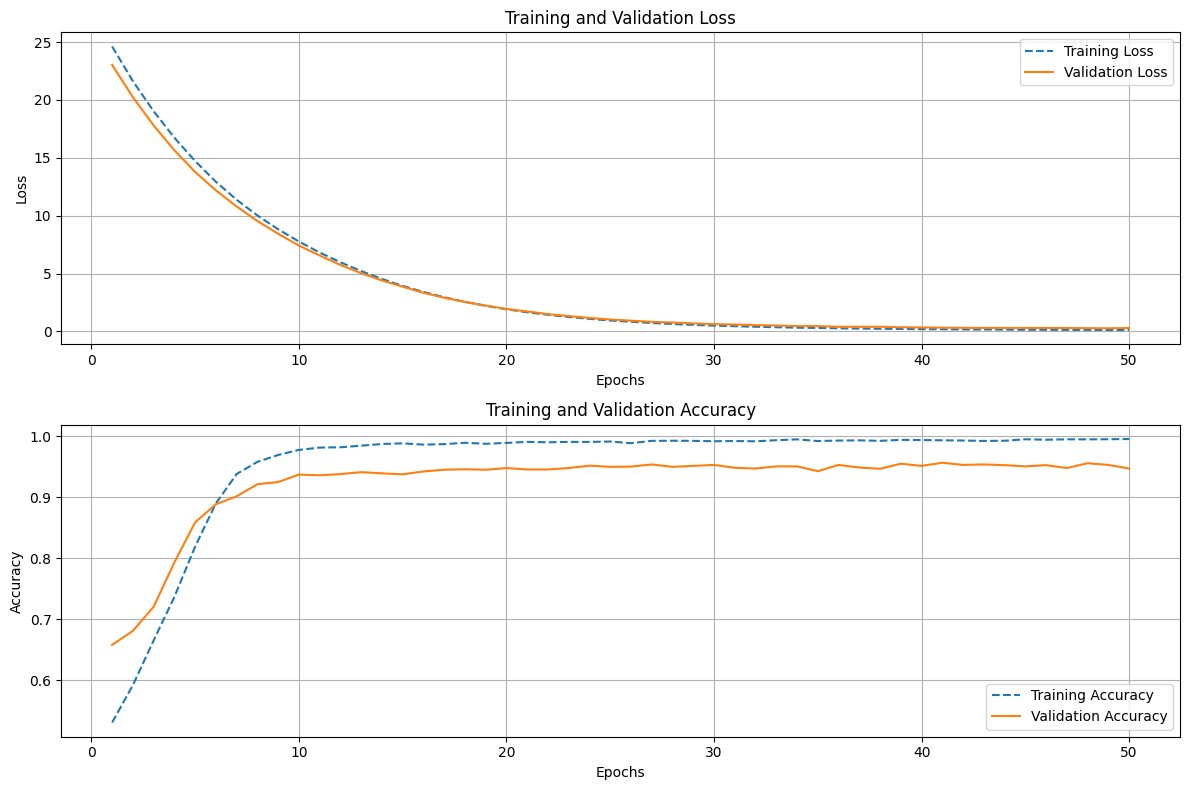

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

2025-01-27 13:47:30.610313: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4560', 220 bytes spill stores, 220 bytes spill loads

2025-01-27 13:47:31.027332: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4560', 4 bytes spill stores, 4 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step


2025-01-27 13:47:45.193028: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


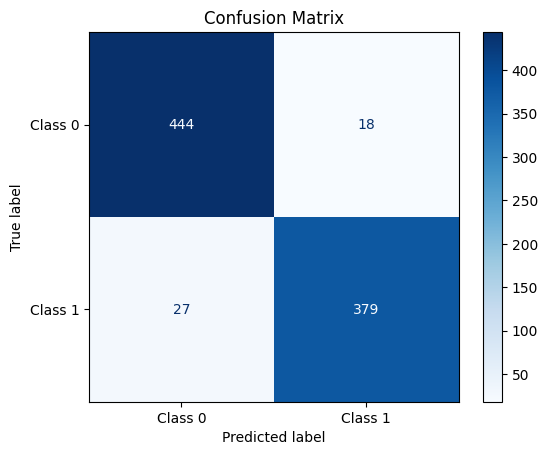


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.94      0.96      0.95       462
     Class 1       0.95      0.93      0.94       406

    accuracy                           0.95       868
   macro avg       0.95      0.95      0.95       868
weighted avg       0.95      0.95      0.95       868


Accuracy: 0.95


In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
# Extract the number of epochs
epochs = range(1, len(DenseNet169_model_history_new.history['loss']) + 1)

# Create subplots
plt.figure(figsize=(12, 8))

# Plot accuracy (training and validation)
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second subplot
plt.plot(epochs, DenseNet169_model_history_new.history['accuracy'], label='Training Accuracy', linestyle='--')
plt.plot(epochs, DenseNet169_model_history_new.history['val_accuracy'], label='Validation Accuracy', linestyle='-')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss (training and validation)
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first subplot
plt.plot(epochs, DenseNet169_model_history_new.history['loss'], label='Training Loss', linestyle='--')
plt.plot(epochs, DenseNet169_model_history_new.history['val_loss'], label='Validation Loss', linestyle='-')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


# Adjust layout and show the plots
plt.tight_layout()
plt.show()



# Step 1: Get True Labels and Predictions
true_labels = []
predicted_labels = []

# Iterate through the test dataset to get all labels and predictions
for images, labels in test_dataset:
    true_labels.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot to class index
    predictions = DenseNet169_model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))  # Get predicted class index

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Step 2: Build and Display Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])  # Update labels as per your classes
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Step 3: Calculate Metrics
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=["Class 0", "Class 1"]))

# Calculate overall accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"\nAccuracy: {accuracy:.2f}")


In [ ]:
import gc
# After training, free up memory
tf.keras.backend.clear_session()
gc.collect()

9. DenseNet201

In [3]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import pickle


def try_model_DenseNet201():
    # Load the base model with VGG16
    base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze all layers initially
    for layer in base_model.layers:
        layer.trainable = False

    # Calculate the index to start unfreezing layers
    from_index = int(np.round((len(base_model.layers) - 1) * (1.0 - 70.0 / 100.0)))

    # Unfreeze layers from the calculated index onwards
    for layer in base_model.layers[from_index:]:
        layer.trainable = True

    # Add custom layers on top (Upper-Layers)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    predictions = Dense(2, activation='softmax', kernel_regularizer=l2(0.01))(x)  # Assuming binary classification

    DenseNet201_model = Model(inputs=base_model.input, outputs=predictions)
    
    # Define callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
    checkpoint = ModelCheckpoint(
        'best_DenseNet201_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
    
    return DenseNet201_model, early_stopping, checkpoint

# Create the model
DenseNet201_model, early_stopping, checkpoint = try_model_DenseNet201()

# Compile the model
DenseNet201_model.compile(optimizer=Adam(learning_rate=1e-5),
                       loss='categorical_crossentropy',
                       metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

# Train the model
DenseNet201_model_history_new = DenseNet201_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size=32,
    epochs=50, 
    callbacks=[early_stopping, checkpoint]
)

DenseNet201_model.save('DenseNet201_model_new.h5')

# Assume `model_history` is the variable storing the history returned by model.fit()
with open('DenseNet201_model_history_new.pkl', 'wb') as file:
    pickle.dump(DenseNet201_model_history_new.history, file)


Epoch 1/50


I0000 00:00:1737975039.990647  662456 service.cc:148] XLA service 0x750ad4001da0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737975039.990673  662456 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2025-01-27 13:50:41.512671: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737975046.815483  662456 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-27 13:50:51.590516: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_42247', 16 bytes spill stores, 16 bytes spill loads

2025-01-27 13:50:51.780308: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_

425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.5132 - loss: 26.0111 - precision: 0.5132 - recall: 0.5132

2025-01-27 13:55:04.233876: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5522_0', 88 bytes spill stores, 120 bytes spill loads

2025-01-27 13:55:05.236194: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5522', 220 bytes spill stores, 220 bytes spill loads




Epoch 1: val_loss improved from inf to 23.42861, saving model to best_DenseNet201_model.keras
425/425 ━━━━━━━━━━━━━━━━━━━━ 320s 322ms/step - accuracy: 0.5132 - loss: 26.0090 - precision: 0.5132 - recall: 0.5132 - val_accuracy: 0.6258 - val_loss: 23.4286 - val_precision: 0.6258 - val_recall: 0.6258
Epoch 2/50
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.5703 - loss: 22.6844 - precision: 0.5703 - recall: 0.5703
Epoch 2: val_loss improved from 23.42861 to 20.46567, saving model to best_DenseNet201_model.keras
425/425 ━━━━━━━━━━━━━━━━━━━━ 121s 285ms/step - accuracy: 0.5704 - loss: 22.6827 - precision: 0.5704 - recall: 0.5704 - val_accuracy: 0.6677 - val_loss: 20.4657 - val_precision: 0.6677 - val_recall: 0.6677
Epoch 3/50
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.6366 - loss: 19.8249 - precision: 0.6366 - recall: 0.6366
Epoch 3: val_loss improved from 20.46567 to 17.89924, saving model to best_DenseNet201_model.keras
425/425 ━━━━━━━━━━━━━━━━━━━━ 121s 285ms/step 

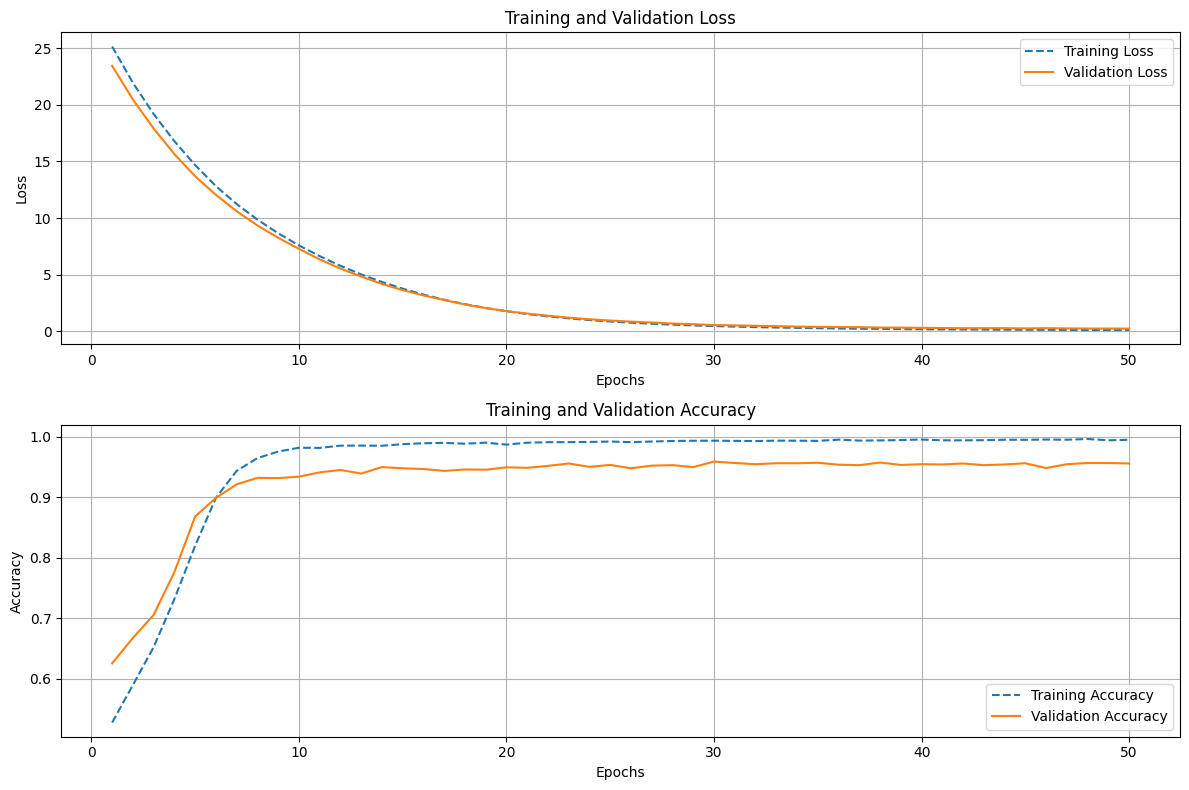

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

2025-01-27 15:42:12.862856: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5408', 220 bytes spill stores, 220 bytes spill loads

2025-01-27 15:42:13.077812: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5408', 4 bytes spill stores, 4 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step


2025-01-27 15:42:29.023956: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


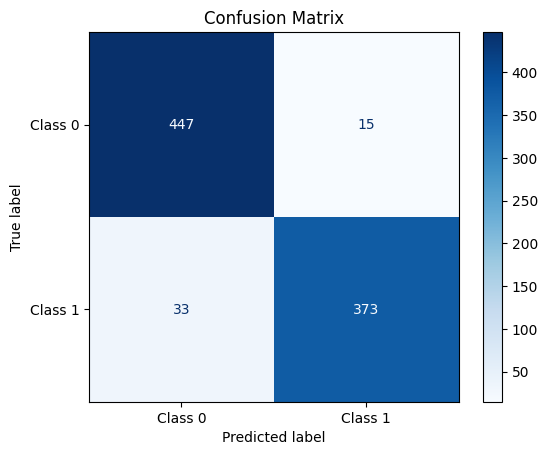


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.93      0.97      0.95       462
     Class 1       0.96      0.92      0.94       406

    accuracy                           0.94       868
   macro avg       0.95      0.94      0.94       868
weighted avg       0.95      0.94      0.94       868


Accuracy: 0.94


In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

# Extract the number of epochs
epochs = range(1, len(DenseNet201_model_history_new.history['loss']) + 1)

# Create subplots
plt.figure(figsize=(12, 8))

# Plot accuracy (training and validation)
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second subplot
plt.plot(epochs, DenseNet201_model_history_new.history['accuracy'], label='Training Accuracy', linestyle='--')
plt.plot(epochs, DenseNet201_model_history_new.history['val_accuracy'], label='Validation Accuracy', linestyle='-')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss (training and validation)
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first subplot
plt.plot(epochs, DenseNet201_model_history_new.history['loss'], label='Training Loss', linestyle='--')
plt.plot(epochs, DenseNet201_model_history_new.history['val_loss'], label='Validation Loss', linestyle='-')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


# Adjust layout and show the plots
plt.tight_layout()
plt.show()


# Step 1: Get True Labels and Predictions
true_labels = []
predicted_labels = []

# Iterate through the test dataset to get all labels and predictions
for images, labels in test_dataset:
    true_labels.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot to class index
    predictions = DenseNet201_model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))  # Get predicted class index

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Step 2: Build and Display Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])  # Update labels as per your classes
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Step 3: Calculate Metrics
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=["Class 0", "Class 1"]))

# Calculate overall accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"\nAccuracy: {accuracy:.2f}")


In [ ]:
import gc
# After training, free up memory
tf.keras.backend.clear_session()
gc.collect()

10. ResNet50V2

In [4]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import pickle

def try_model_ResNet50V2():
    # Load the base model with VGG16
    base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze all layers initially
    for layer in base_model.layers:
        layer.trainable = False

    # Calculate the index to start unfreezing layers
    from_index = int(np.round((len(base_model.layers) - 1) * (1.0 - 70.0 / 100.0)))

    # Unfreeze layers from the calculated index onwards
    for layer in base_model.layers[from_index:]:
        layer.trainable = True

    # Add custom layers on top (Upper-Layers)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    predictions = Dense(2, activation='softmax', kernel_regularizer=l2(0.01))(x)  # Assuming binary classification

    ResNet50V2_model = Model(inputs=base_model.input, outputs=predictions)
    
    # Define callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
    checkpoint = ModelCheckpoint(
        'best_ResNet50V2_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
    
    return ResNet50V2_model, early_stopping, checkpoint

# Create the model
ResNet50V2_model, early_stopping, checkpoint = try_model_ResNet50V2()

# Compile the model
ResNet50V2_model.compile(optimizer=Adam(learning_rate=1e-5),
                       loss='categorical_crossentropy',
                       metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

# Train the model
ResNet50V2_model_history_new = ResNet50V2_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size=32,
    epochs=50,
    callbacks=[early_stopping, checkpoint]
)

ResNet50V2_model.save('ResNet50V2_model_new.h5')


# Assume `model_history` is the variable storing the history returned by model.fit()
with open('ResNet50V2_model_history_new.pkl', 'wb') as file:
    pickle.dump(ResNet50V2_model_history_new.history, file)


Epoch 1/50


I0000 00:00:1738036585.574094  776675 service.cc:148] XLA service 0x7acb78002390 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738036585.574139  776675 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2025-01-28 06:56:25.959621: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738036587.445077  776675 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-28 06:56:29.163672: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12367_0', 112 bytes spill stores, 224 bytes spill loads

2025-01-28 06:56:29.394919: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_

  1/425 ━━━━━━━━━━━━━━━━━━━━ 3:55:26 33s/step - accuracy: 0.5000 - loss: 24.2699 - precision: 0.5000 - recall: 0.5000

I0000 00:00:1738036609.084590  776675 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.5107 - loss: 23.5619 - precision: 0.5107 - recall: 0.5107

2025-01-28 06:58:09.841570: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1602_0', 88 bytes spill stores, 120 bytes spill loads

2025-01-28 06:58:10.046261: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1602', 220 bytes spill stores, 220 bytes spill loads




Epoch 1: val_loss improved from inf to 21.73127, saving model to best_ResNet50V2_model.keras
425/425 ━━━━━━━━━━━━━━━━━━━━ 123s 211ms/step - accuracy: 0.5108 - loss: 23.5604 - precision: 0.5108 - recall: 0.5108 - val_accuracy: 0.6297 - val_loss: 21.7313 - val_precision: 0.6297 - val_recall: 0.6297
Epoch 2/50
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.5739 - loss: 21.1733 - precision: 0.5739 - recall: 0.5739
Epoch 2: val_loss improved from 21.73127 to 19.45206, saving model to best_ResNet50V2_model.keras
425/425 ━━━━━━━━━━━━━━━━━━━━ 86s 202ms/step - accuracy: 0.5739 - loss: 21.1720 - precision: 0.5739 - recall: 0.5739 - val_accuracy: 0.6741 - val_loss: 19.4521 - val_precision: 0.6741 - val_recall: 0.6741
Epoch 3/50
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.6490 - loss: 18.9332 - precision: 0.6490 - recall: 0.6490
Epoch 3: val_loss improved from 19.45206 to 17.34018, saving model to best_ResNet50V2_model.keras
425/425 ━━━━━━━━━━━━━━━━━━━━ 86s 202ms/step - acc

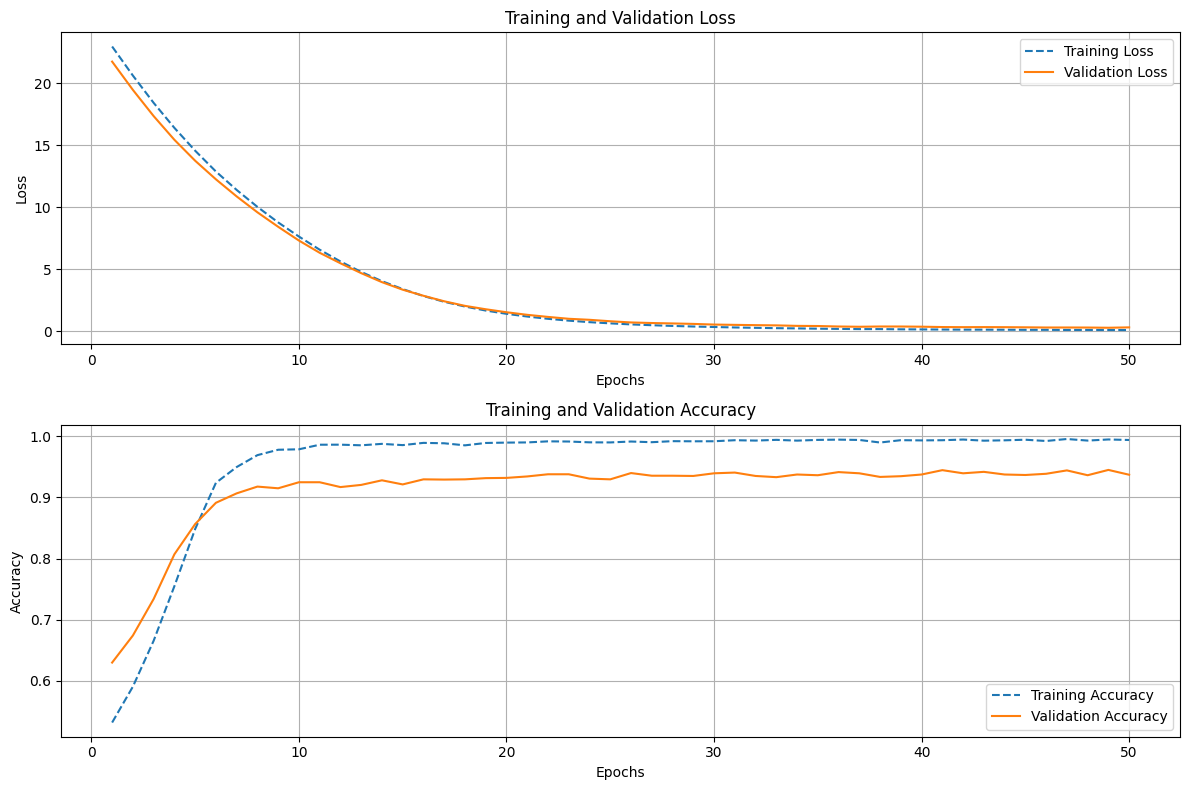

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━

2025-01-28 09:13:30.334417: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1491_0', 8 bytes spill stores, 8 bytes spill loads

2025-01-28 09:13:30.673036: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1498', 4 bytes spill stores, 4 bytes spill loads

2025-01-28 09:13:31.412169: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1498', 220 bytes spill stores, 220 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


2025-01-28 09:13:35.294606: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


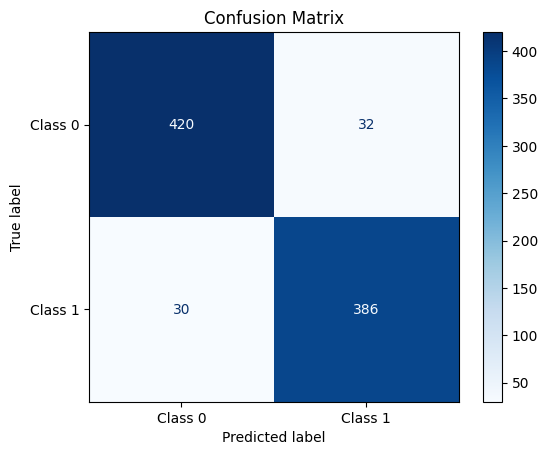


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.93      0.93      0.93       452
     Class 1       0.92      0.93      0.93       416

    accuracy                           0.93       868
   macro avg       0.93      0.93      0.93       868
weighted avg       0.93      0.93      0.93       868


Accuracy: 0.93


In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

# Extract the number of epochs
epochs = range(1, len(ResNet50V2_model_history_new.history['loss']) + 1)

# Create subplots
plt.figure(figsize=(12, 8))

# Plot accuracy (training and validation)
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second subplot
plt.plot(epochs, ResNet50V2_model_history_new.history['accuracy'], label='Training Accuracy', linestyle='--')
plt.plot(epochs, ResNet50V2_model_history_new.history['val_accuracy'], label='Validation Accuracy', linestyle='-')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss (training and validation)
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first subplot
plt.plot(epochs, ResNet50V2_model_history_new.history['loss'], label='Training Loss', linestyle='--')
plt.plot(epochs, ResNet50V2_model_history_new.history['val_loss'], label='Validation Loss', linestyle='-')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


# Adjust layout and show the plots
plt.tight_layout()
plt.show()



# Step 1: Get True Labels and Predictions
true_labels = []
predicted_labels = []

# Iterate through the test dataset to get all labels and predictions
for images, labels in test_dataset:
    true_labels.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot to class index
    predictions = ResNet50V2_model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))  # Get predicted class index

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Step 2: Build and Display Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])  # Update labels as per your classes
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Step 3: Calculate Metrics
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=["Class 0", "Class 1"]))

# Calculate overall accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"\nAccuracy: {accuracy:.2f}")


In [ ]:
import gc
# After training, free up memory
tf.keras.backend.clear_session()
gc.collect()

11. ResNet152V2

In [3]:
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import pickle

def try_model_ResNet152V2():
    # Load the base model with VGG16
    base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze all layers initially
    for layer in base_model.layers:
        layer.trainable = False

    # Calculate the index to start unfreezing layers
    from_index = int(np.round((len(base_model.layers) - 1) * (1.0 - 70.0 / 100.0)))

    # Unfreeze layers from the calculated index onwards
    for layer in base_model.layers[from_index:]:
        layer.trainable = True

    # Add custom layers on top (Upper-Layers)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    predictions = Dense(2, activation='softmax', kernel_regularizer=l2(0.01))(x)  # Assuming binary classification

    ResNet152V2_model = Model(inputs=base_model.input, outputs=predictions)
    
    # Define callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
    checkpoint = ModelCheckpoint(
        'best_ResNet152V2_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
    
    return ResNet152V2_model, early_stopping, checkpoint

# Create the model
ResNet152V2_model, early_stopping, checkpoint = try_model_ResNet152V2()

# Compile the model
ResNet152V2_model.compile(optimizer=Adam(learning_rate=1e-5),
                       loss='categorical_crossentropy',
                       metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

# Train the model
ResNet152V2_model_history_new = ResNet152V2_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size=16,
    callbacks=[early_stopping, checkpoint],
    epochs=50
)

ResNet152V2_model.save('ResNet152V2_model_new.h5')



# Assume `model_history` is the variable storing the history returned by model.fit()
with open('ResNet152V2_model_history_new.pkl', 'wb') as file:
    pickle.dump(ResNet152V2_model_history_new.history, file)


Epoch 1/50


I0000 00:00:1738049142.370480  799260 service.cc:148] XLA service 0x7534fc005ae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738049142.370497  799260 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2025-01-28 10:25:43.606238: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738049147.960209  799260 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-28 10:25:51.655849: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_34441_0', 204 bytes spill stores, 204 bytes spill loads

I0000 00:00:1738049167.732898  799260 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.5305 - loss: 22.7659 - precision: 0.5305 - recall: 0.5305
Epoch 1: val_loss improved from inf to 18.77098, saving model to best_ResNet152V2_model.keras
850/850 ━━━━━━━━━━━━━━━━━━━━ 330s 324ms/step - accuracy: 0.5306 - loss: 22.7643 - precision: 0.5305 - recall: 0.5305 - val_accuracy: 0.6081 - val_loss: 18.7710 - val_precision: 0.6081 - val_recall: 0.6081
Epoch 2/50
850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.5830 - loss: 17.5947 - precision: 0.5830 - recall: 0.5830
Epoch 2: val_loss improved from 18.77098 to 14.33084, saving model to best_ResNet152V2_model.keras
850/850 ━━━━━━━━━━━━━━━━━━━━ 271s 318ms/step - accuracy: 0.5830 - loss: 17.5934 - precision: 0.5830 - recall: 0.5830 - val_accuracy: 0.6285 - val_loss: 14.3308 - val_precision: 0.6285 - val_recall: 0.6285
Epoch 3/50
850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.6262 - loss: 13.4549 - precision: 0.6262 - recall: 0.6262
Epoch 3: val_loss improved fro

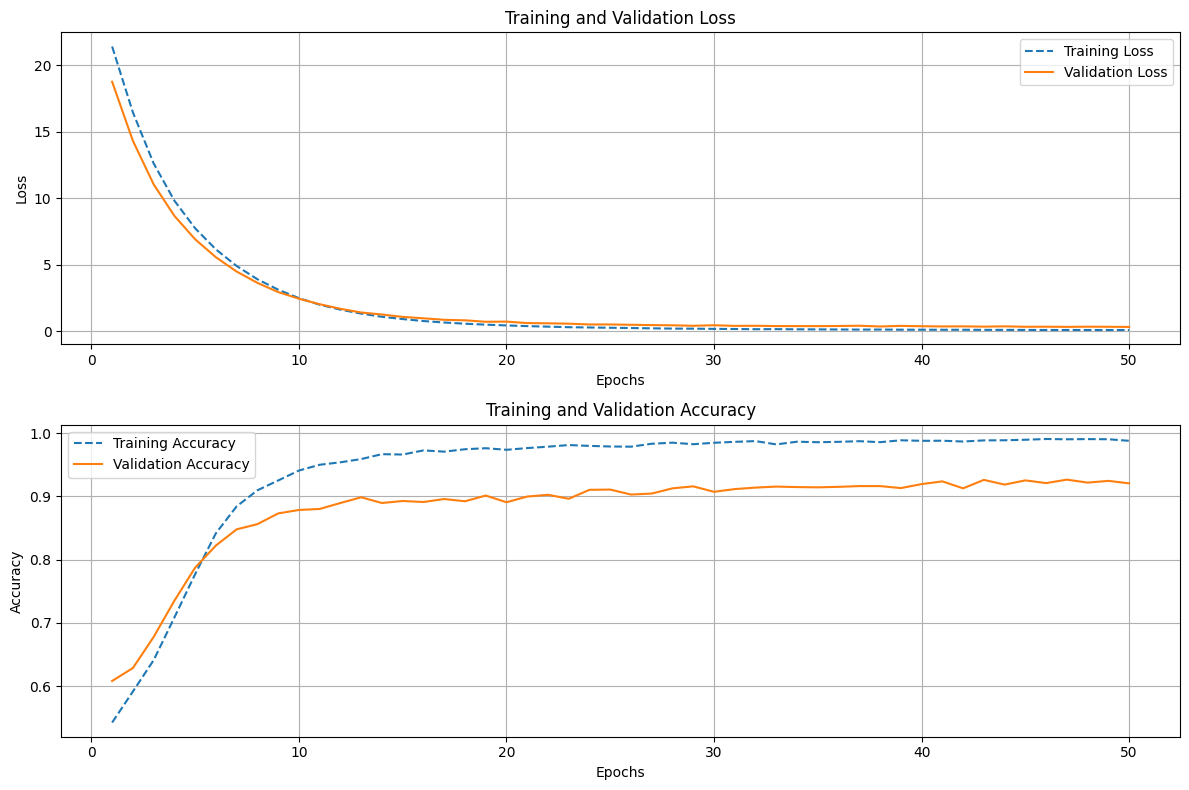

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

2025-01-28 14:16:43.645560: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4415_0', 8 bytes spill stores, 8 bytes spill loads

2025-01-28 14:16:44.783765: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4422', 4 bytes spill stores, 4 bytes spill loads

2025-01-28 14:16:44.793410: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4422', 220 bytes spill stores, 220 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


2025-01-28 14:16:48.915721: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


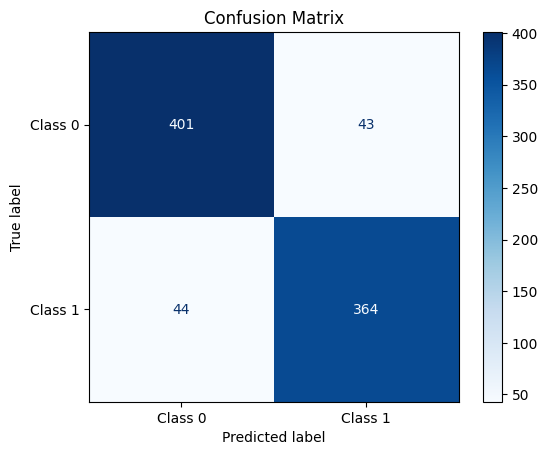


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.90      0.90      0.90       444
     Class 1       0.89      0.89      0.89       408

    accuracy                           0.90       852
   macro avg       0.90      0.90      0.90       852
weighted avg       0.90      0.90      0.90       852


Accuracy: 0.90


In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

# Extract the number of epochs
epochs = range(1, len(ResNet152V2_model_history_new.history['loss']) + 1)

# Create subplots
plt.figure(figsize=(12, 8))

# Plot accuracy (training and validation)
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second subplot
plt.plot(epochs, ResNet152V2_model_history_new.history['accuracy'], label='Training Accuracy', linestyle='--')
plt.plot(epochs, ResNet152V2_model_history_new.history['val_accuracy'], label='Validation Accuracy', linestyle='-')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss (training and validation)
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first subplot
plt.plot(epochs, ResNet152V2_model_history_new.history['loss'], label='Training Loss', linestyle='--')
plt.plot(epochs, ResNet152V2_model_history_new.history['val_loss'], label='Validation Loss', linestyle='-')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


# Adjust layout and show the plots
plt.tight_layout()
plt.show()



# Step 1: Get True Labels and Predictions
true_labels = []
predicted_labels = []

# Iterate through the test dataset to get all labels and predictions
for images, labels in test_dataset:
    true_labels.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot to class index
    predictions = ResNet152V2_model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))  # Get predicted class index

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Step 2: Build and Display Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])  # Update labels as per your classes
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Step 3: Calculate Metrics
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=["Class 0", "Class 1"]))

# Calculate overall accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"\nAccuracy: {accuracy:.2f}")


In [3]:
import numpy as np
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def try_ResNet101V2_model():
    # Load the ResNet101V2 base model
    base_model = ResNet101V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze all layers initially
    for layer in base_model.layers:
        layer.trainable = False

    # Calculate the index to start unfreezing layers
    from_index = int(np.round((len(base_model.layers) - 1) * (1.0 - 70.0 / 100.0)))

    # Unfreeze layers from the calculated index onwards
    for layer in base_model.layers[from_index:]:
        layer.trainable = True

    # Add custom layers on top (Upper-Layers)
        x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)
    predictions = Dense(2, activation='softmax', kernel_regularizer=l2(0.01))(x)  # Sigmoid for binary classification

    # Create the model
    ResNet101V2_model = Model(inputs=base_model.input, outputs=predictions)

    # Define callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
    checkpoint = ModelCheckpoint(
        'best_ResNet101V2_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    return ResNet101V2_model, early_stopping, checkpoint


In [4]:
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
import pickle


# Unpack the model and early_stopping
ResNet101V2_model, early_stopping, checkpoint= try_ResNet101V2_model()

# Compile the model
ResNet101V2_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

# Summary
# ResNet101.summary()


# Train the model with a unique history variable name
ResNet101V2_model_history_new = ResNet101V2_model.fit(
    train_dataset,  # Replace with your training dataset
    validation_data=validation_dataset,  # Replace with your validation dataset
    epochs=50,  # Number of epochs
    batch_size=16,
    callbacks=[early_stopping, checkpoint]
)

# Save the trained model
ResNet101V2_model.save("ResNet101V2_model_new.h5")

# Assume `model_history` is the variable storing the history returned by model.fit()
with open('ResNet101V2_model_history_new.pkl', 'wb') as file:
    pickle.dump(ResNet101V2_model_history_new.history, file)


Epoch 1/50


I0000 00:00:1738256529.821049 1048698 service.cc:148] XLA service 0x712afc002020 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738256529.821073 1048698 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2025-01-30 20:02:10.675147: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738256533.702175 1048698 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-30 20:02:17.225770: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_23388_0', 204 bytes spill stores, 204 bytes spill loads

I0000 00:00:1738256552.139687 1048698 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.5269 - loss: 22.8619 - precision: 0.5269 - recall: 0.5269
Epoch 1: val_loss improved from inf to 19.14310, saving model to best_ResNet101V2_model.keras
850/850 ━━━━━━━━━━━━━━━━━━━━ 238s 231ms/step - accuracy: 0.5269 - loss: 22.8604 - precision: 0.5269 - recall: 0.5269 - val_accuracy: 0.6006 - val_loss: 19.1431 - val_precision: 0.6006 - val_recall: 0.6006
Epoch 2/50
850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.5876 - loss: 18.0438 - precision: 0.5876 - recall: 0.5876
Epoch 2: val_loss improved from 19.14310 to 14.95923, saving model to best_ResNet101V2_model.keras
850/850 ━━━━━━━━━━━━━━━━━━━━ 191s 225ms/step - accuracy: 0.5876 - loss: 18.0425 - precision: 0.5876 - recall: 0.5876 - val_accuracy: 0.6521 - val_loss: 14.9592 - val_precision: 0.6521 - val_recall: 0.6521
Epoch 3/50
850/850 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.6651 - loss: 14.0912 - precision: 0.6651 - recall: 0.6651
Epoch 3: val_loss improved fro

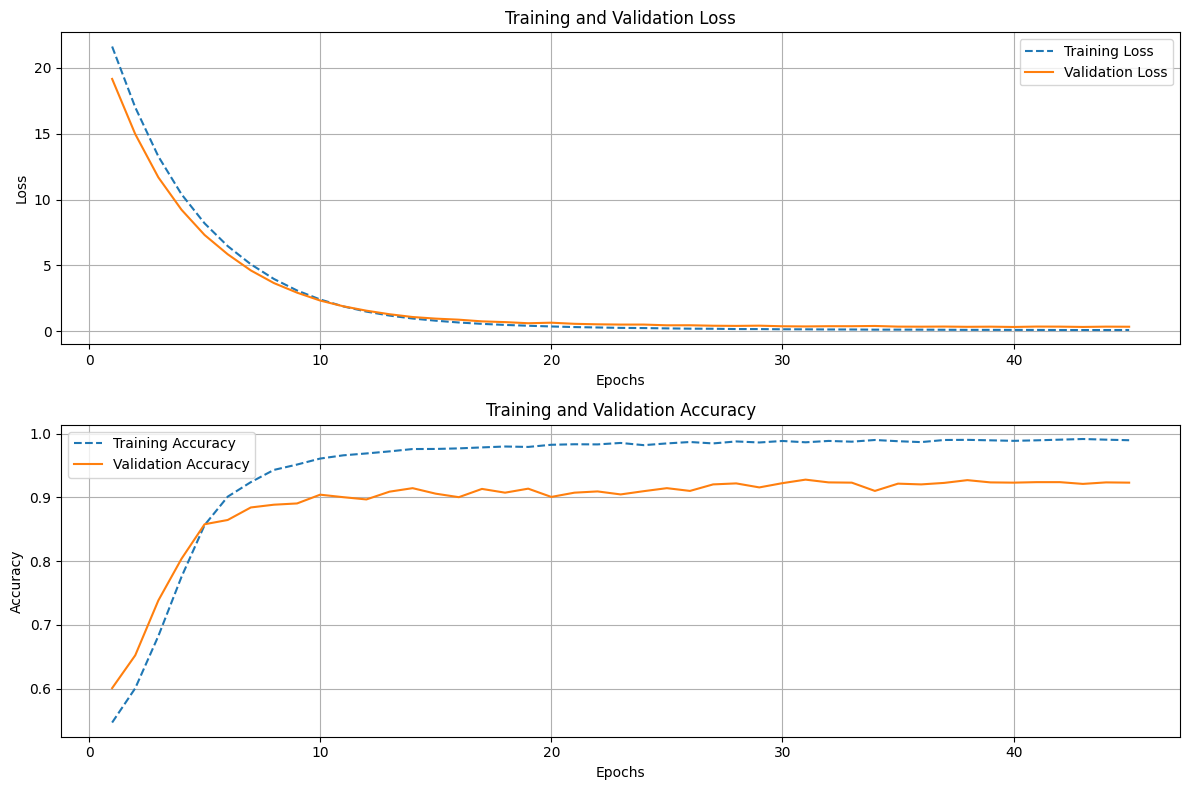

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━

2025-01-31 07:51:49.169136: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2953_0', 8 bytes spill stores, 8 bytes spill loads

2025-01-31 07:51:49.795248: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2960', 220 bytes spill stores, 220 bytes spill loads

2025-01-31 07:51:50.075596: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2960', 4 bytes spill stores, 4 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


2025-01-31 07:51:54.196669: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


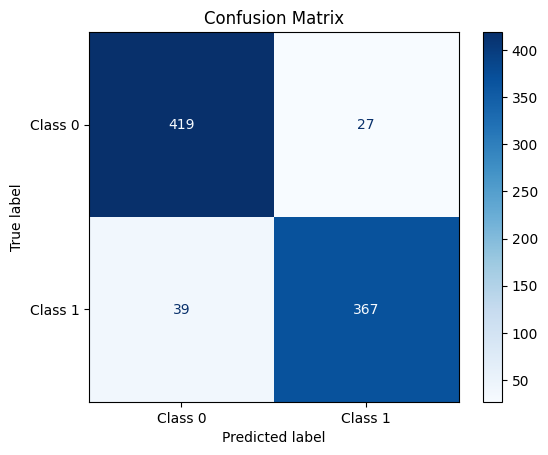


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.91      0.94      0.93       446
     Class 1       0.93      0.90      0.92       406

    accuracy                           0.92       852
   macro avg       0.92      0.92      0.92       852
weighted avg       0.92      0.92      0.92       852


Accuracy: 0.92


In [5]:
# Plot training and validation metrics
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import matplotlib.pyplot as plt

# Extract the number of epochs
epochs = range(1, len(ResNet101V2_model_history_new.history['loss']) + 1)

# Create subplots
plt.figure(figsize=(12, 8))

# Plot accuracy (training and validation)
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second subplot
plt.plot(epochs, ResNet101V2_model_history_new.history['accuracy'], label='Training Accuracy', linestyle='--')
plt.plot(epochs, ResNet101V2_model_history_new.history['val_accuracy'], label='Validation Accuracy', linestyle='-')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss (training and validation)
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first subplot
plt.plot(epochs, ResNet101V2_model_history_new.history['loss'], label='Training Loss', linestyle='--')
plt.plot(epochs, ResNet101V2_model_history_new.history['val_loss'], label='Validation Loss', linestyle='-')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


# Adjust layout and show the plots
plt.tight_layout()
plt.show()




# Step 1: Get True Labels and Predictions
true_labels = []
predicted_labels = []

# Iterate through the test dataset to get all labels and predictions
for images, labels in test_dataset:
    true_labels.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot to class index
    predictions = ResNet101V2_model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))  # Get predicted class index

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Step 2: Build and Display Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])  # Update labels as per your classes
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Step 3: Calculate Metrics
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=["Class 0", "Class 1"]))

# Calculate overall accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"\nAccuracy: {accuracy:.2f}")



In [ ]:
# import matplotlib.pyplot as plt
# import pickle
# from tensorflow.keras.models import load_model

# # Function to load model and history
# def load_model_and_history(model_path, history_path):
#     model = load_model(model_path)
#     with open(history_path, 'rb') as file:
#         history = pickle.load(file)
#     return model, history

# # Load the saved models and their history
# model_vgg19, history_vgg19 = load_model_and_history('model_vgg19_new.h5', 'vgg19_model_history_new.pkl')
# model_vgg16, history_vgg16 = load_model_and_history('model_vgg16_new.h5', 'vgg16_model_history_new.pkl')

# model_resnet50, history_resnet50 = load_model_and_history('resnet50_model_new.h5', 'ResNet50_model_history_new.pkl')
# ResNet101_model, ResNet101_history = load_model_and_history('ResNet101_model.h5', 'ResNet101_history.pkl')
# resnet152_model, resnet152_history = load_model_and_history('resnet152_model.h5', 'resnet152_history.pkl')

# Mobile_Net_new, Mobile_Net_history_new = load_model_and_history('Mobile_Net_new.h5', 'Mobile_Net_history_new.pkl')
# InceptionV3_model, InceptionV3_model_history_new = load_model_and_history('InceptionV3_model_new.h5', 'InceptionV3_model_history_new.pkl')

# model_resnet50V2, history_resnet50V2 = load_model_and_history('ResNet50V2_model_new.h5', 'ResNet50V2_model_history_new.pkl')
# model_resnet152V2, history_resnet152V2 = load_model_and_history('ResNet152V2_model_new.h5', 'ResNet152V2_model_history_new.pkl')
# model_resnet101V2, history_resnet101V2 = load_model_and_history('ResNet101V2_model.h5', 'ResNet101V2_model_history.pkl')

# model_densenet121, history_densenet121 = load_model_and_history('model_DenseNet121_new.h5', 'DenseNet121_model_history_new.pkl')
# model_densenet169, history_densenet169 = load_model_and_history('DenseNet169_model_new.h5', 'DenseNet169_model_history_new.pkl')
# model_densenet201, history_densenet201 = load_model_and_history('DenseNet201_model_new.h5', 'DenseNet201_model_history_new.pkl')

# # Plot accuracy
# plt.figure(figsize=(10, 5))
# plt.plot(history_vgg19['accuracy'], label='VGG19 Train Accuracy')
# plt.plot(history_vgg19['val_accuracy'], label='VGG19 Validation Accuracy')
# plt.plot(history_vgg16['accuracy'], label='VGG16 Train Accuracy')
# plt.plot(history_vgg16['val_accuracy'], label='VGG16 Validation Accuracy')
# plt.plot(Mobile_Net_history_new['accuracy'], label='MobielNet Train Accuracy')
# plt.plot(Mobile_Net_history_new['val_accuracy'], label='MobileNet Validation Accuracy')
# plt.plot(InceptionV3_model_history_new['accuracy'], label='InceptionV3 Train Accuracy')
# plt.plot(InceptionV3_model_history_new['val_accuracy'], label='InceptionV3 Validation Accuracy')

# plt.plot(history_resnet50['accuracy'], label='ResNet50 Train Accuracy')
# plt.plot(history_resnet50['val_accuracy'], label='ResNet50 Validation Accuracy')
# plt.plot(ResNet101_history['accuracy'], label='ResNet101 Train Accuracy')
# plt.plot(ResNet101_history['val_accuracy'], label='ResNet101 Validation Accuracy')
# plt.plot(resnet152_history['accuracy'], label='ResNet152 Train Accuracy')
# plt.plot(resnet152_history['val_accuracy'], label='ResNet152 Validation Accuracy')


# plt.plot(history_resnet50V2['accuracy'], label='ResNet50V2 Train Accuracy')
# plt.plot(history_resnet50V2['val_accuracy'], label='ResNet50V2 Validation Accuracy')
# plt.plot(history_resnet152V2['accuracy'], label='ResNet101V2 Train Accuracy')
# plt.plot(history_resnet152V2['val_accuracy'], label='ResNet101V2 Validation Accuracy')
# plt.plot(history_resnet101V2['accuracy'], label='ResNet152V2 Train Accuracy')
# plt.plot(history_resnet101V2['val_accuracy'], label='ResNet152V2 Validation Accuracy')



# plt.plot(history_densenet121['accuracy'], label='DenseNet121 Train Accuracy')
# plt.plot(history_densenet121['val_accuracy'], label='DenseNet121 Validation Accuracy')

# plt.plot(history_densenet169['accuracy'], label='DenseNet169 Train Accuracy')
# plt.plot(history_densenet169['val_accuracy'], label='DenseNet169 Validation Accuracy')

# plt.plot(history_densenet201['accuracy'], label='DenseNet201 Train Accuracy')
# plt.plot(history_densenet201['val_accuracy'], label='DenseNet201 Validation Accuracy')

# plt.title('Model Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.grid()
# plt.show()

# # Plot loss
# plt.figure(figsize=(10, 5))
# plt.plot(history_vgg19['loss'], label='VGG19 Train Loss')
# plt.plot(history_vgg19['val_loss'], label='VGG19 Validation Loss')
# plt.plot(history_vgg16['loss'], label='VGG16 Train Loss')
# plt.plot(history_vgg16['val_loss'], label='VGG16 Validation Loss')
# plt.plot(Mobile_Net_history_new['loss'], label='MobielNet Train Loss')
# plt.plot(Mobile_Net_history_new['val_loss'], label='MobielNet Validation Loss')
# plt.plot(InceptionV3_model_history_new['loss'], label='InceptionV3 Train Loss')
# plt.plot(InceptionV3_model_history_new['val_loss'], label='InceptionV3 Validation Loss')


# plt.plot(history_resnet50['loss'], label='ResNet50 Train Loss')
# plt.plot(history_resnet50['val_loss'], label='ResNet50 Validation Loss')
# plt.plot(ResNet101_history['loss'], label='ResNet101 Train Loss')
# plt.plot(ResNet101_history['val_loss'], label='ResNet101 Validation Loss')
# plt.plot(resnet152_history['loss'], label='ResNet152 Train Loss')
# plt.plot(resnet152_history['val_loss'], label='ResNet152 Validation Loss')


# plt.plot(history_resnet50V2['loss'], label='ResNet50V2 Train Loss')
# plt.plot(history_resnet50V2['val_loss'], label='ResNet50V2 Validation Loss')
# plt.plot(history_resnet101V2['loss'], label='ResNet101V2 Train Loss')
# plt.plot(history_resnet101V2['val_loss'], label='ResNet101V2 Validation Loss')
# plt.plot(history_resnet152V2['loss'], label='ResNet152V2 Train Loss')
# plt.plot(history_resnet152V2['val_loss'], label='ResNet152V2 Validation Loss')


# plt.plot(history_densenet121['loss'], label='DenseNet121 Train Loss')
# plt.plot(history_densenet121['val_loss'], label='DenseNet121 Validation Loss')
# plt.plot(history_densenet169['loss'], label='DenseNet169 Train Loss')
# plt.plot(history_densenet169['val_loss'], label='DenseNet169 Validation Loss')
# plt.plot(history_densenet201['loss'], label='DenseNet201 Train Loss')
# plt.plot(history_densenet201['val_loss'], label='DenseNet201 Validation Loss')
# plt.title('Model Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.grid()
# plt.show()


In [ ]:
import pickle

# Function to load history from a file
def load_history(history_path):
    with open(history_path, 'rb') as file:
        return pickle.load(file)

# Load histories
history_vgg19 = load_history('vgg19_model_history_new.pkl')
history_vgg16 = load_history('vgg16_model_history_new.pkl')
Mobile_Net_history_new = load_history('Mobile_Net_history_new.pkl')
InceptionV3_model_history_new = load_history('InceptionV3_model_history_new.pkl')
history_resnet50 = load_history('ResNet50_model_history_new.pkl')
ResNet101_history = load_history('ResNet101_history_new.pkl')
resnet152_history = load_history('resnet152_history_new.pkl')
history_resnet50V2 = load_history('ResNet50V2_model_history_new.pkl')
history_resnet101V2 = load_history('ResNet101V2_model_history_new.pkl')
history_resnet152V2 = load_history('ResNet152V2_model_history_new.pkl')
history_densenet121 = load_history('DenseNet121_model_history_new.pkl')
history_densenet169 = load_history('DenseNet169_model_history_new.pkl')
history_densenet201 = load_history('DenseNet201_model_history_new.pkl')

# Correct the model_histories list
model_histories = [
    ('VGG19', history_vgg19),
    ('VGG16', history_vgg16),
    ('MobileNet', Mobile_Net_history_new),
    ('InceptionV3', InceptionV3_model_history_new),
    ('ResNet50', history_resnet50),
    ('ResNet101', ResNet101_history),
    ('ResNet152', resnet152_history),
    ('ResNet50V2', history_resnet50V2),
    ('ResNet101V2', history_resnet101V2),
    ('ResNet152V2', history_resnet152V2),
    ('DenseNet121', history_densenet121),
    ('DenseNet169', history_densenet169),
    ('DenseNet201', history_densenet201),
]

# Plot accuracy
plot_metrics(model_histories, title_prefix='Model', metric='accuracy', ylabel='Accuracy')

# Plot loss
plot_metrics(model_histories, title_prefix='Model', metric='loss', ylabel='Loss')


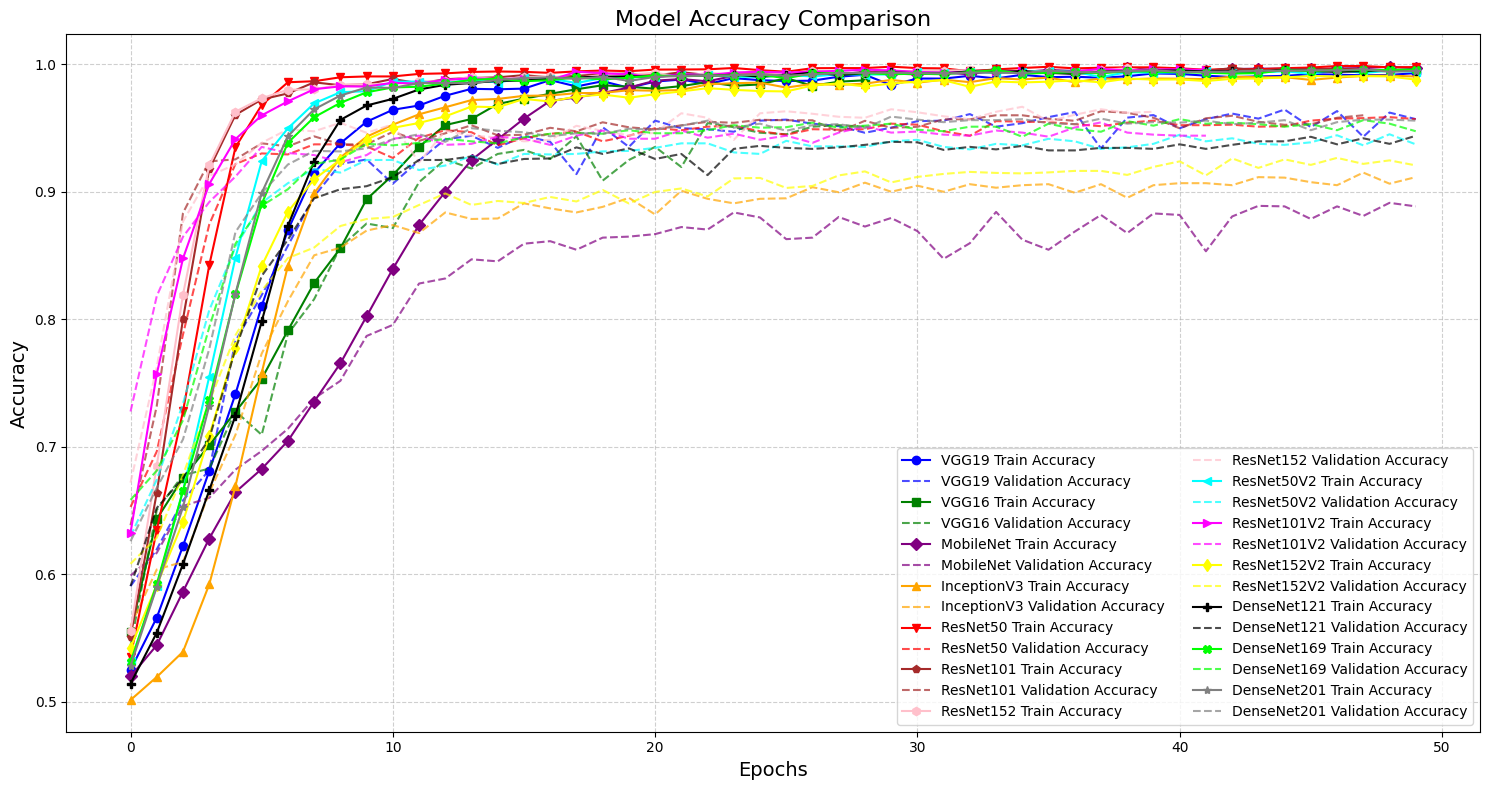

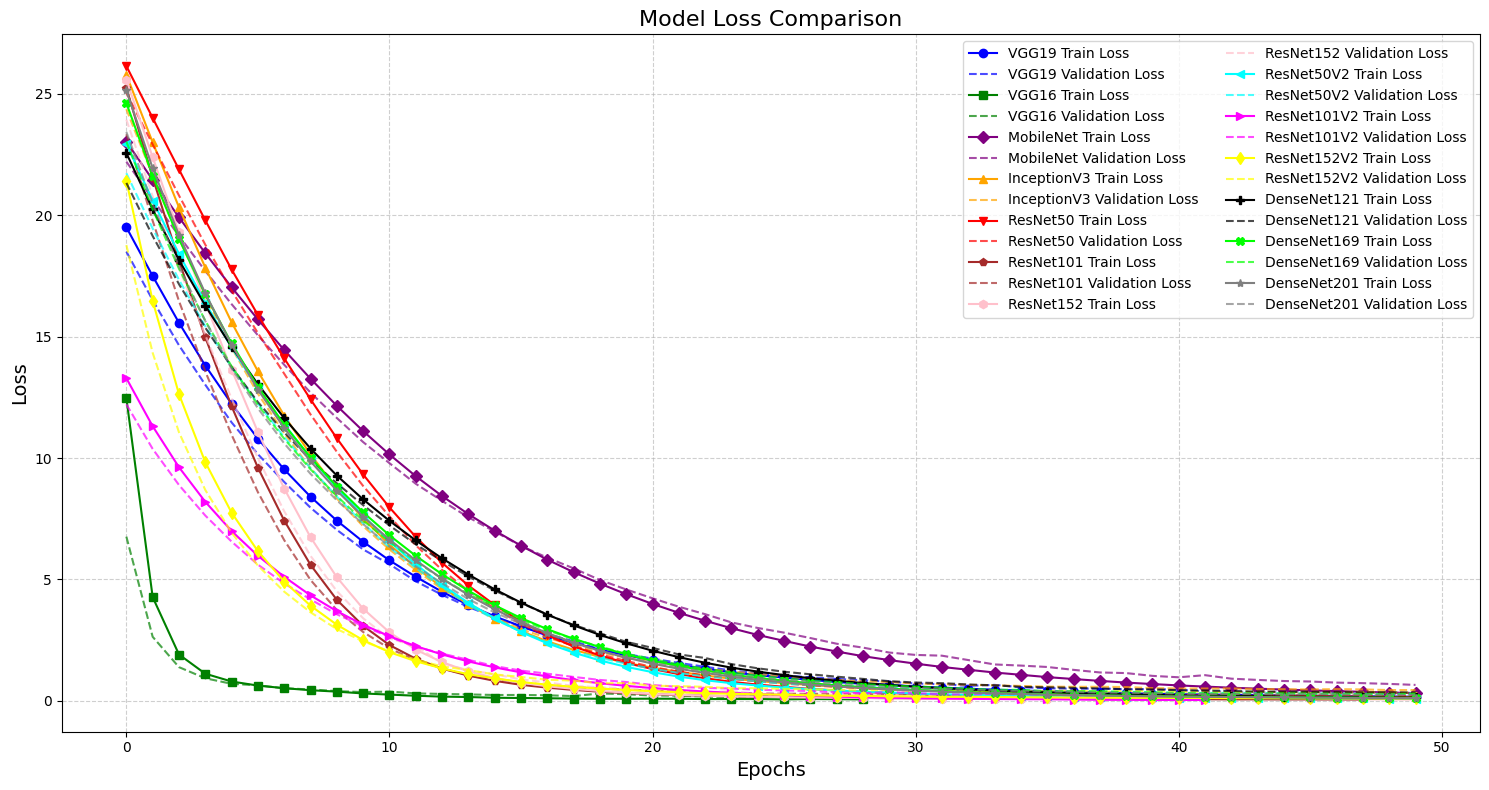

In [7]:
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras.models import load_model

# Function to load history
def load_history(history_path):
    with open(history_path, 'rb') as file:
        history = pickle.load(file)
    return history

# Paths to history files
history_files = {
    'VGG19': 'vgg19_model_history_new.pkl',
    'VGG16': 'vgg16_model_history_new.pkl',
    'MobileNet': 'Mobile_Net_history_new.pkl',
    'InceptionV3': 'InceptionV3_model_history_new.pkl',
    'ResNet50': 'ResNet50_model_history_new.pkl',
    'ResNet101': 'ResNet101_history_new.pkl',
    'ResNet152': 'resnet152_history_new.pkl',
    'ResNet50V2': 'ResNet50V2_model_history_new.pkl',
    'ResNet101V2': 'ResNet101V2_model_history.pkl',
    'ResNet152V2': 'ResNet152V2_model_history_new.pkl',
    'DenseNet121': 'DenseNet121_model_history_new.pkl',
    'DenseNet169': 'DenseNet169_model_history_new.pkl',
    'DenseNet201': 'DenseNet201_model_history_new.pkl'
}

# Load all histories
model_histories = {name: load_history(path) for name, path in history_files.items()}

# Define styles for better decoration
styles = {
    'VGG19': ('blue', 'o'),
    'VGG16': ('green', 's'),
    'MobileNet': ('purple', 'D'),
    'InceptionV3': ('orange', '^'),
    'ResNet50': ('red', 'v'),
    'ResNet101': ('brown', 'p'),
    'ResNet152': ('pink', 'h'),
    'ResNet50V2': ('cyan', '<'),
    'ResNet101V2': ('magenta', '>'),
    'ResNet152V2': ('yellow', 'd'),
    'DenseNet121': ('black', 'P'),
    'DenseNet169': ('lime', 'X'),
    'DenseNet201': ('gray', '*')
}

# Plot accuracy
plt.figure(figsize=(15, 8))
for model_name, history in model_histories.items():
    color, marker = styles[model_name]
    plt.plot(history['accuracy'], linestyle='-', color=color, label=f'{model_name} Train Accuracy', marker=marker)
    plt.plot(history['val_accuracy'], linestyle='--', color=color, label=f'{model_name} Validation Accuracy', alpha=0.7)

plt.title('Model Accuracy Comparison', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(loc='lower right', fontsize=10, ncol=2)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('model_accuracy_comparison.jpg', dpi=300, format='jpg')  # Save as JPG
plt.show()

# Plot loss
plt.figure(figsize=(15, 8))
for model_name, history in model_histories.items():
    color, marker = styles[model_name]
    plt.plot(history['loss'], linestyle='-', color=color, label=f'{model_name} Train Loss', marker=marker)
    plt.plot(history['val_loss'], linestyle='--', color=color, label=f'{model_name} Validation Loss', alpha=0.7)

plt.title('Model Loss Comparison', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', fontsize=10, ncol=2)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('model_loss_comparison.jpg', dpi=300, format='jpg')  # Save as JPG
plt.show()


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Paths to the saved model files
model_paths = {
    'VGG19': '/home/maruf/Documents/New/code/model_vgg19_new.h5',
    'VGG16': '/home/maruf/Documents/New/code/model_vgg16_new.h5',
    'MobileNet': '/home/maruf/Documents/New/code/Mobile_Net_new.h5',
    'InceptionV3': '/home/maruf/Documents/New/code/InceptionV3_model_new.h5',
    'ResNet50': '/home/maruf/Documents/New/code/resnet50_model_new.h5',
    'ResNet101': '/home/maruf/Documents/New/code/ResNet101_model_new.h5',
    'ResNet152': '/home/maruf/Documents/New/code/resnet152_model_new.h5',
    'ResNet50V2': '/home/maruf/Documents/New/code/ResNet50V2_model_new.h5',
    'ResNet101V2': '/home/maruf/Documents/New/code/ResNet101V2_model_new.h5',
    'ResNet152V2': '/home/maruf/Documents/New/code/ResNet152V2_model_new.h5',
    'DenseNet121': '/home/maruf/Documents/New/code/model_DenseNet121_new.h5',
    'DenseNet169': '/home/maruf/Documents/New/code/DenseNet169_model_new.h5',
    'DenseNet201': '/home/maruf/Documents/New/code/DenseNet201_model_new.h5'
}

# Ensure test dataset is loaded correctly
# Replace '...' with your actual dataset loading method
test_dataset = test_dataset

# Collect true labels once to avoid redundancy
true_labels = []
for images, labels in test_dataset:
    true_labels.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot to class index
true_labels = np.array(true_labels)  # Convert to numpy array

# Create a figure with subplots to hold all confusion matrices
num_models = len(model_paths)
cols = 3  # Set the number of columns in the figure
rows = (num_models // cols) + (num_models % cols > 0)  # Adjust rows dynamically
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))  # Adjust size dynamically
axes = axes.ravel()  # Flatten axes array for easy indexing

# Loop through the models and generate confusion matrices for each
for idx, (model_name, model_path) in enumerate(model_paths.items()):
    print(f"Processing model: {model_name}")

    # Load the model
    model = tf.keras.models.load_model(model_path)

    # Collect predictions
    predicted_labels = []
    for images, _ in test_dataset:
        predictions = model.predict(images)
        predicted_labels.extend(np.argmax(predictions, axis=1))  # Get predicted class index
    predicted_labels = np.array(predicted_labels)  # Convert to numpy array

    # Generate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
    disp.plot(cmap=plt.cm.Blues, ax=axes[idx])
    axes[idx].set_title(f"Confusion Matrix - {model_name}")

# Hide empty subplots if any
for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout for better visualization
plt.tight_layout()
plt.show()


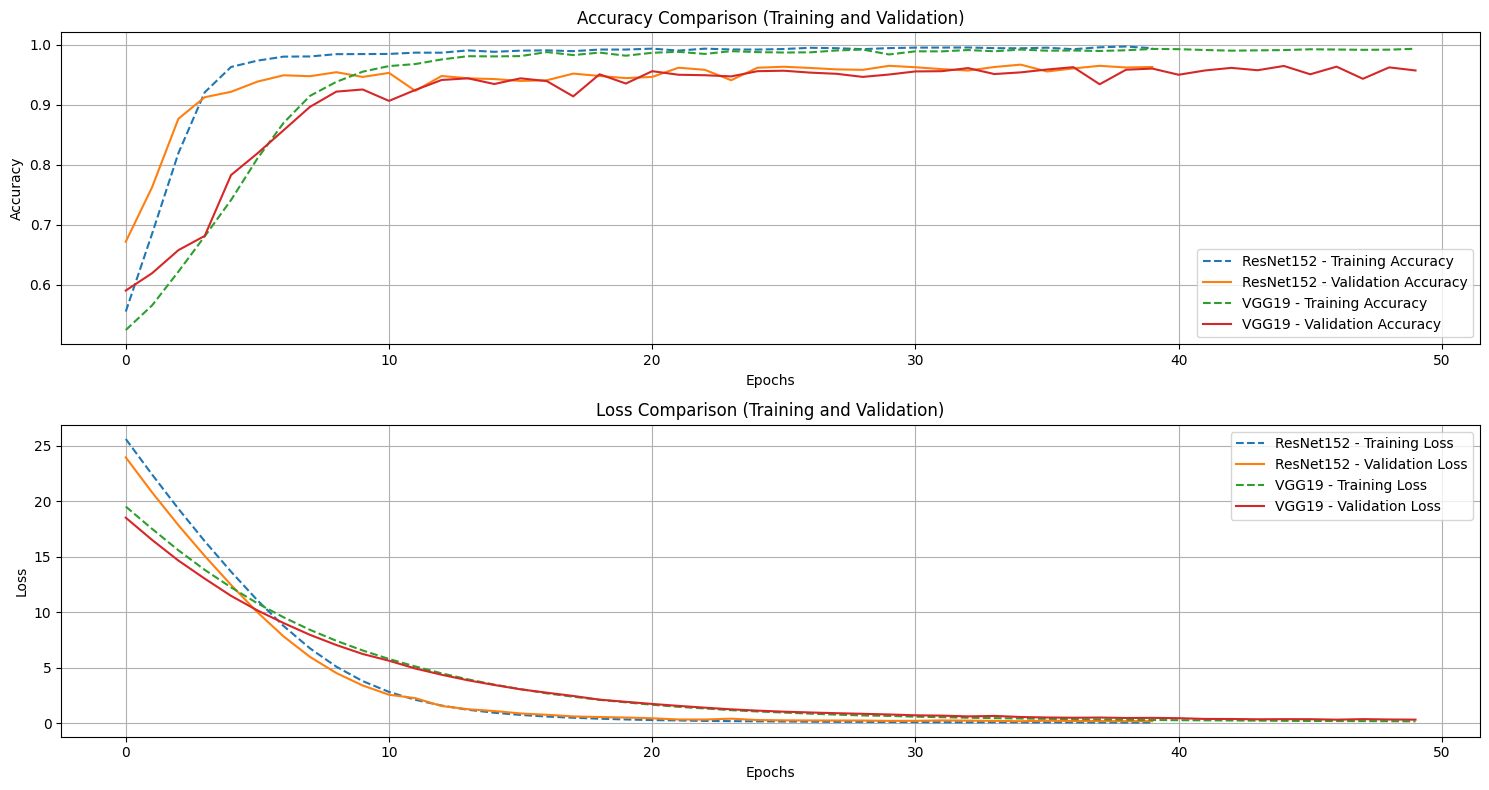

<Figure size 640x480 with 0 Axes>

In [6]:
import pickle
import matplotlib.pyplot as plt

# Paths to the saved history files
history_paths = {
    'ResNet152': '/home/maruf/Documents/New/code/resnet152_history_new.pkl',
    'VGG19': '/home/maruf/Documents/New/code/vgg19_model_history_new.pkl'
}

# Load the history data
history_data = {}
for model_name, history_path in history_paths.items():
    with open(history_path, 'rb') as file:
        history_data[model_name] = pickle.load(file)

# Create subplots: 1 row, 2 columns, with the first one for accuracy and the second one for loss
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Plot accuracy (upper side)
for model_name, history in history_data.items():
    axes[0].plot(history['accuracy'], label=f'{model_name} - Training Accuracy', linestyle='--')
    axes[0].plot(history['val_accuracy'], label=f'{model_name} - Validation Accuracy', linestyle='-')

axes[0].set_title('Accuracy Comparison (Training and Validation)')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Plot loss (lower side)
for model_name, history in history_data.items():
    axes[1].plot(history['loss'], label=f'{model_name} - Training Loss', linestyle='--')
    axes[1].plot(history['val_loss'], label=f'{model_name} - Validation Loss', linestyle='-')

axes[1].set_title('Loss Comparison (Training and Validation)')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()
plt.savefig(f'VGG19_152.jpg', dpi=300) 


In [4]:
import cairosvg
from PIL import Image

# Convert SVG to PNG first (cairosvg does not directly support JPG)
cairosvg.svg2png(url="/home/maruf/Pictures/152_vgg", write_to="/home/maruf/Pictures/152_vgg.png")

# Open PNG and convert to JPG
image = Image.open("/home/maruf/Pictures/152_vgg.png")
image = image.convert("RGB")  # Ensure no transparency issues
image.save("output.jpg", "JPEG", quality=95)  # Save as JPG with high quality


In [ ]:
import tensorflow as tf
import numpy as np
import pickle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Paths to the saved model files
model_paths = {
    'VGG19': '/home/maruf/Documents/New/code/model_vgg19_new.h5',
    'VGG16': '/home/maruf/Documents/New/code/model_vgg16_new.h5',
    # 'MobileNet': '/home/maruf/Documents/New/code/Mobile_Net_new.h5',
    'InceptionV3': '/home/maruf/Documents/New/code/InceptionV3_model_new.h5',
    'ResNet50': '/home/maruf/Documents/New/code/resnet50_model_new.h5',
    'ResNet101': '/home/maruf/Documents/New/code/ResNet101_model_new.h5',
    'ResNet152': '/home/maruf/Documents/New/code/resnet152_model_new.h5',
    'ResNet50V2': '/home/maruf/Documents/New/code/ResNet50V2_model_new.h5',
    'ResNet101V2': '/home/maruf/Documents/New/code/ResNet101V2_model_new.h5',
    'ResNet152V2': '/home/maruf/Documents/New/code/ResNet152V2_model_new.h5',
    'DenseNet121': '/home/maruf/Documents/New/code/model_DenseNet121_new.h5',
    'DenseNet169': '/home/maruf/Documents/New/code/DenseNet169_model_new.h5',
    'DenseNet201': '/home/maruf/Documents/New/code/DenseNet201_model_new.h5'
}

# Load the corresponding model and test data
def load_and_predict(model_name, test_dataset):
    model_path = model_paths[model_name]
    model = tf.keras.models.load_model(model_path)
    
    true_labels = []
    predicted_labels = []

    # Get true labels and predictions for this model
    for images, labels in test_dataset:
        true_labels.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot to class index
        predictions = model.predict(images)
        predicted_labels.extend(np.argmax(predictions, axis=1))  # Get predicted class index

    # Convert lists to numpy arrays
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    return true_labels, predicted_labels

# Create a figure with subplots to hold all confusion matrices
fig, axes = plt.subplots(4, 3, figsize=(15, 20))  # Adjust size as needed
axes = axes.ravel()

# Loop through the models and generate confusion matrices for each
for idx, model_name in enumerate(model_paths.keys()):
    true_labels, predicted_labels = load_and_predict(model_name, test_dataset)

    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
    disp.plot(cmap=plt.cm.Blues, ax=axes[idx])
    axes[idx].set_title(f"Confusion Matrix - {model_name}")

# Adjust layout to make it nicer
plt.tight_layout()
plt.show()


I0000 00:00:1738424766.190153  229157 service.cc:148] XLA service 0x7efea040cbc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738424766.190181  229157 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2025-02-01 18:46:06.202952: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738424766.271072  229157 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step

I0000 00:00:1738424774.851847  229157 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/ste

2025-02-01 18:46:23.084344: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_227', 220 bytes spill stores, 220 bytes spill loads

2025-02-01 18:46:23.114013: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_227', 4 bytes spill stores, 4 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


2025-02-01 18:46:26.780611: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━

2025-02-01 18:46:35.830299: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━

2025-02-01 18:46:46.439396: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_671', 4 bytes spill stores, 4 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


2025-02-01 18:46:53.261283: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1950_0', 204 bytes spill stores, 204 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━

2025-02-01 18:47:07.797052: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1950_0', 8 bytes spill stores, 8 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


2025-02-01 18:47:14.073903: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━

2025-02-01 18:48:25.638950: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━

2025-02-01 18:49:45.009969: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3539', 24 bytes spill stores, 24 bytes spill loads

2025-02-01 18:49:45.122218: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3539_0', 244 bytes spill stores, 244 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━

2025-02-01 18:50:18.390210: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4195_0', 244 bytes spill stores, 244 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━

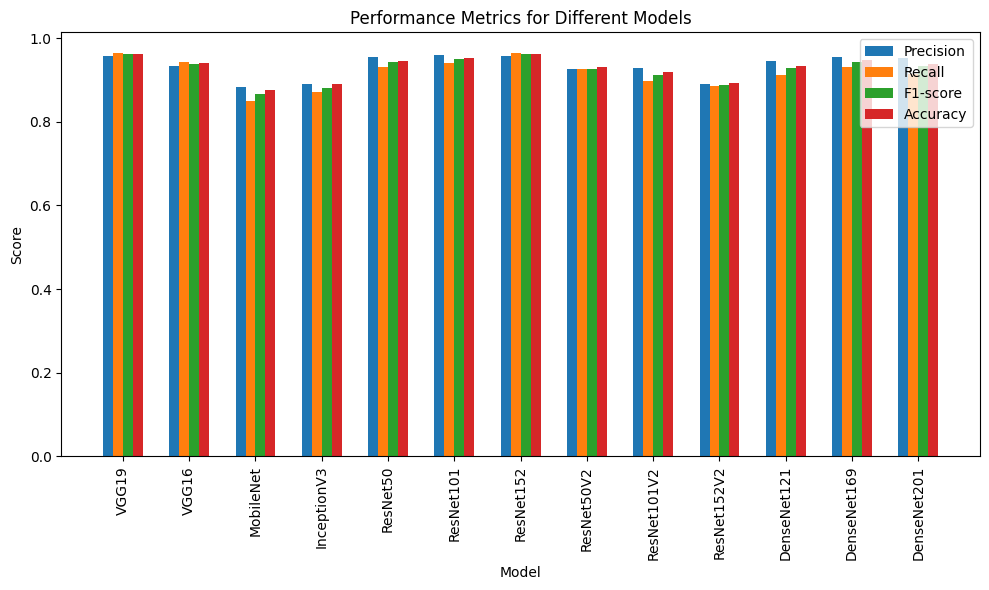

In [3]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt

# Paths to the saved model files
model_paths = {
    'VGG19': '/home/maruf/Documents/New/code/model_vgg19_new.h5',
    'VGG16': '/home/maruf/Documents/New/code/model_vgg16_new.h5',
    'MobileNet': '/home/maruf/Documents/New/code/Mobile_Net_new.h5',
    'InceptionV3': '/home/maruf/Documents/New/code/InceptionV3_model_new.h5',
    'ResNet50': '/home/maruf/Documents/New/code/resnet50_model_new.h5',
    'ResNet101': '/home/maruf/Documents/New/code/ResNet101_model_new.h5',
    'ResNet152': '/home/maruf/Documents/New/code/resnet152_model_new.h5',
    'ResNet50V2': '/home/maruf/Documents/New/code/ResNet50V2_model_new.h5',
    'ResNet101V2': '/home/maruf/Documents/New/code/ResNet101V2_model_new.h5',
    'ResNet152V2': '/home/maruf/Documents/New/code/ResNet152V2_model_new.h5',
    'DenseNet121': '/home/maruf/Documents/New/code/model_DenseNet121_new.h5',
    'DenseNet169': '/home/maruf/Documents/New/code/DenseNet169_model_new.h5',
    'DenseNet201': '/home/maruf/Documents/New/code/DenseNet201_model_new.h5'
}

# Load the corresponding model and test data
def load_and_predict(model_name, test_dataset):
    model_path = model_paths[model_name]
    model = tf.keras.models.load_model(model_path)
    
    true_labels = []
    predicted_labels = []

    # Get true labels and predictions for this model
    for images, labels in test_dataset:
        true_labels.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot to class index
        predictions = model.predict(images)
        predicted_labels.extend(np.argmax(predictions, axis=1))  # Get predicted class index

    # Convert lists to numpy arrays
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    return true_labels, predicted_labels

# Store performance metrics for the bar chart
metrics = {
    'Model': [],
    'Precision': [],
    'Recall': [],
    'F1-score': [],
    'Accuracy': []
}

# Loop through the models and generate metrics for each
for model_name in model_paths.keys():
    true_labels, predicted_labels = load_and_predict(model_name, test_dataset)

    # Calculate precision, recall, F1-score, and accuracy
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    accuracy = accuracy_score(true_labels, predicted_labels)

    # Append metrics to the list
    metrics['Model'].append(model_name)
    metrics['Precision'].append(precision)
    metrics['Recall'].append(recall)
    metrics['F1-score'].append(f1)
    metrics['Accuracy'].append(accuracy)

# Create a bar chart for the performance metrics of all models
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.15  # Width of the bars
index = np.arange(len(model_paths))  # The x location for the groups

# Plotting the bar chart
ax.bar(index, metrics['Precision'], bar_width, label='Precision')
ax.bar(index + bar_width, metrics['Recall'], bar_width, label='Recall')
ax.bar(index + 2*bar_width, metrics['F1-score'], bar_width, label='F1-score')
ax.bar(index + 3*bar_width, metrics['Accuracy'], bar_width, label='Accuracy')

ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Performance Metrics for Different Models')
ax.set_xticks(index + 1.5 * bar_width)
ax.set_xticklabels(metrics['Model'], rotation=90)
ax.legend()

plt.tight_layout()
plt.show()


I0000 00:00:1738476258.486627  312962 service.cc:148] XLA service 0x75aea000c9c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738476258.486655  312962 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2025-02-02 09:04:18.495556: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738476258.587786  312962 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step

I0000 00:00:1738476267.027318  312962 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 

2025-02-02 09:04:34.727905: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_227', 220 bytes spill stores, 220 bytes spill loads

2025-02-02 09:04:35.795894: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_227', 4 bytes spill stores, 4 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


2025-02-02 09:04:38.440153: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━

2025-02-02 09:04:47.154595: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━

2025-02-02 09:04:57.116128: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_671', 4 bytes spill stores, 4 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


2025-02-02 09:05:04.022228: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1950_0', 204 bytes spill stores, 204 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━

2025-02-02 09:05:17.781249: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1950_0', 8 bytes spill stores, 8 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


2025-02-02 09:05:23.645493: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━

2025-02-02 09:06:30.224613: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━

2025-02-02 09:07:43.292276: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3539', 24 bytes spill stores, 24 bytes spill loads

2025-02-02 09:07:43.400185: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3539_0', 244 bytes spill stores, 244 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━

2025-02-02 09:08:13.924585: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4195_0', 244 bytes spill stores, 244 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━

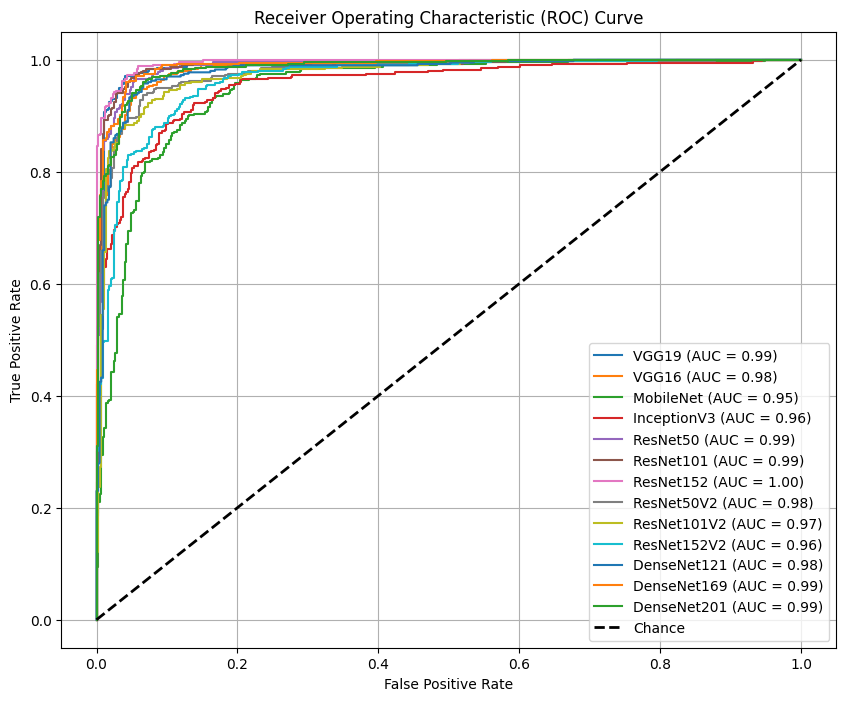

In [3]:
import tensorflow as tf
import numpy as np
import pickle
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Paths to the saved model files
model_paths = {
    'VGG19': '/home/maruf/Documents/New/code/model_vgg19_new.h5',
    'VGG16': '/home/maruf/Documents/New/code/model_vgg16_new.h5',
    'MobileNet': '/home/maruf/Documents/New/code/Mobile_Net_new.h5',
    'InceptionV3': '/home/maruf/Documents/New/code/InceptionV3_model_new.h5',
    'ResNet50': '/home/maruf/Documents/New/code/resnet50_model_new.h5',
    'ResNet101': '/home/maruf/Documents/New/code/ResNet101_model_new.h5',
    'ResNet152': '/home/maruf/Documents/New/code/resnet152_model_new.h5',
    'ResNet50V2': '/home/maruf/Documents/New/code/ResNet50V2_model_new.h5',
    'ResNet101V2': '/home/maruf/Documents/New/code/ResNet101V2_model_new.h5',
    'ResNet152V2': '/home/maruf/Documents/New/code/ResNet152V2_model_new.h5',
    'DenseNet121': '/home/maruf/Documents/New/code/model_DenseNet121_new.h5',
    'DenseNet169': '/home/maruf/Documents/New/code/DenseNet169_model_new.h5',
    'DenseNet201': '/home/maruf/Documents/New/code/DenseNet201_model_new.h5'
}

# Load the corresponding model and test data
def load_and_predict(model_name, test_dataset):
    model_path = model_paths[model_name]
    model = tf.keras.models.load_model(model_path)
    
    true_labels = []
    predicted_probs = []  # Store predicted probabilities for ROC

    # Get true labels and predictions for this model
    for images, labels in test_dataset:
        true_labels.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot to class index
        predictions = model.predict(images)
        predicted_probs.extend(predictions[:, 1])  # Use the predicted probabilities for class 1

    # Convert lists to numpy arrays
    true_labels = np.array(true_labels)
    predicted_probs = np.array(predicted_probs)

    return true_labels, predicted_probs

# Plotting ROC curve for all models
plt.figure(figsize=(10, 8))

for model_name in model_paths.keys():
    true_labels, predicted_probs = load_and_predict(model_name, test_dataset)

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
    auc = roc_auc_score(true_labels, predicted_probs)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')

# Plot the diagonal (chance line)
plt.plot([0, 1], [0, 1], 'k--', label='Chance', linewidth=2)

plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
